In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from cycler import cycler
import numpy as np
from pyspark.sql import SparkSession
from IPython.display import Markdown
plt.style.use('seaborn')

### Start a spark session and the spark Context

In [2]:
spark = SparkSession.builder.appName("PySpark SQL").getOrCreate()
spark

In [3]:
sc = spark.sparkContext

### Open the data set and scale it- Available on Preprocessing NoteBook

In [4]:
dataRDD = sc.textFile("/home/ubuntu/Notebooks/Data/Scaled_Preprocessed_data_07_01_to_07_07.csv", 16)
dataRDD.first()

'di_account_num,viewing_duration_seconds,program_runtime,station_digital,station_analog,station_hdtv,station_sdtv,station_sports,station_tve,Drama,Sports,Reality,Entertainment,Documentary,Kids,Family,Animals,News,Movie,Music,Teen,Science & Technology,Health & Fitness,Religion,Shopping,Misellaneous'

In [5]:
df = spark.read.csv("scaled_df.csv", sep=",", inferSchema="true", header="true")
df.printSchema()

root
 |-- di_account_num: string (nullable = true)
 |-- viewing_duration_seconds: double (nullable = true)
 |-- program_runtime: double (nullable = true)
 |-- station_digital: double (nullable = true)
 |-- station_analog: double (nullable = true)
 |-- station_hdtv: double (nullable = true)
 |-- station_sdtv: double (nullable = true)
 |-- station_sports: double (nullable = true)
 |-- station_tve: double (nullable = true)
 |-- Drama: double (nullable = true)
 |-- Sports: double (nullable = true)
 |-- Reality: double (nullable = true)
 |-- Entertainment: double (nullable = true)
 |-- Documentary: double (nullable = true)
 |-- Kids: double (nullable = true)
 |-- Family: double (nullable = true)
 |-- Animals: double (nullable = true)
 |-- News: double (nullable = true)
 |-- Movie: double (nullable = true)
 |-- Music: double (nullable = true)
 |-- Teen: double (nullable = true)
 |-- Science & Technology: double (nullable = true)
 |-- Health & Fitness: double (nullable = true)
 |-- Religion: 

### Prepare the data for K Means in pyspark

In [6]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

In [7]:
cols = df.columns
cols[1:]

['viewing_duration_seconds',
 'program_runtime',
 'station_digital',
 'station_analog',
 'station_hdtv',
 'station_sdtv',
 'station_sports',
 'station_tve',
 'Drama',
 'Sports',
 'Reality',
 'Entertainment',
 'Documentary',
 'Kids',
 'Family',
 'Animals',
 'News',
 'Movie',
 'Music',
 'Teen',
 'Science & Technology',
 'Health & Fitness',
 'Religion',
 'Shopping',
 'Misellaneous']

In [8]:
assembler = VectorAssembler(inputCols=cols[1:], outputCol='features')

In [9]:
assembled_data = assembler.transform(df)

### Run K-Means with 2 clusters for a test

In [10]:
k_means_2 = KMeans(featuresCol='features', k=2)
#k_means_3 = KMeans(featuresCol='scaledFeatures', k=3)

In [11]:
model_k2 = k_means_2.fit(assembled_data)
#model_k3 = k_means_3.fit(scaled_data)

In [12]:
model_k2_data = model_k2.transform(assembled_data)

In [13]:
model_k2_data.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|         1|152348|
|         0|928359|
+----------+------+



### Run K - Means with more clusters

In [10]:
k_means_17 = KMeans(featuresCol='features', k=17)
model_k17 = k_means_17.fit(assembled_data)
model_k17_data = model_k17.transform(assembled_data)
model_k17_data.groupBy('prediction').count().show()

+----------+------+
|prediction| count|
+----------+------+
|        12|519343|
|         1| 64339|
|        13| 24629|
|        16| 49242|
|         6|   655|
|         3| 13206|
|         5|   902|
|        15| 37076|
|         9|  8672|
|         4|  7705|
|         8|  9929|
|         7|  3522|
|        10|  3441|
|        11| 65260|
|        14|  4015|
|         2| 33227|
|         0|235544|
+----------+------+



In [18]:
import numpy as np
k_max = 50
cost = np.zeros(k_max)
for k in range(2,k_max):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(assembled_data)
    cost[k] = model.computeCost(assembled_data)

Text(0, 0.5, 'cost')

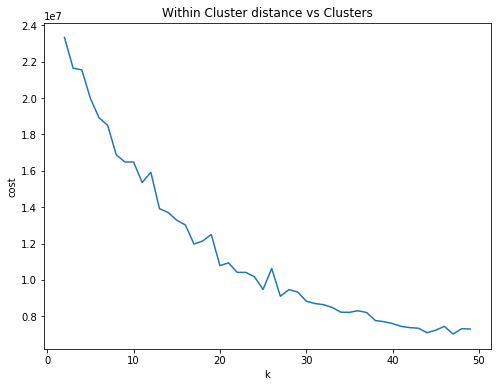

In [23]:
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,k_max),cost[2:k_max])
ax.set_title("Within Cluster distance vs Clusters")
ax.set_xlabel('k')
ax.set_ylabel('cost')


In [11]:
py_df = model_k17_data.drop('features').toPandas().set_index('di_account_num')
py_df.head()


,viewing_duration_seconds,program_runtime,station_digital,station_analog,station_hdtv,station_sdtv,station_sports,station_tve,Drama,Sports,...,News,Movie,Music,Teen,Science & Technology,Health & Fitness,Religion,Shopping,Misellaneous,prediction
di_account_num,,,,,,,,,,,,,,,,,,,,,
++++yXWkYNIEvfB83VGZTvx8hyDTT0WthqMuggmF9Iw=,-0.365201,0.741807,-0.155412,-0.040113,-0.050810,-0.24003,-0.21262,-0.809473,0.496454,-0.233171,...,1.698536,-0.318846,-0.112859,-0.290289,-0.030168,-0.047555,-0.053394,-0.096609,-0.069362,11
+++5Cs2yHlqypQ0OybE3Ga0Hj5Fuf2ZCA6uCazOxFk8=,-0.955418,-0.578642,-0.848922,-0.040113,-0.772460,-0.24003,-0.21262,-0.682119,-0.572009,-0.233171,...,-0.332967,-0.318846,-0.112859,-0.290289,-0.030168,-0.047555,-0.053394,-0.096609,1.331918,12
+++Brw+WK4d8VrHsTFBTZaXFBGFn4Zy/ZmimCXjSOjw=,-0.893041,-0.705260,-0.848922,-0.040113,-0.772460,-0.24003,-0.21262,-0.682119,-0.572009,-0.233171,...,-0.332967,-0.318846,-0.112859,-0.290289,-0.030168,-0.047555,-0.053394,-0.096609,-0.069362,12
+++HgCK7ZJ1M+Y4rl8wz7GziaC1qvZRcEjqv9BaHSPk=,-0.214457,-0.632907,-0.733337,-0.040113,-0.652185,-0.24003,-0.21262,-0.554765,-0.266734,-0.233171,...,-0.332967,-0.318846,-0.112859,-0.290289,-0.030168,-0.047555,-0.053394,-0.096609,-0.069362,12
+++NblXovoqDgo/sturhLyeDExOX5VCU0kDqDdae8BE=,-0.667162,-0.741437,-0.848922,-0.040113,-0.772460,-0.24003,-0.21262,-0.682119,-0.572009,-0.233171,...,-0.042752,-0.318846,-0.112859,-0.290289,-0.030168,-0.047555,-0.053394,-0.096609,-0.069362,12


In [12]:
py_df = py_df[['prediction']]
py_df.head()

,prediction
di_account_num,
++++yXWkYNIEvfB83VGZTvx8hyDTT0WthqMuggmF9Iw=,11
+++5Cs2yHlqypQ0OybE3Ga0Hj5Fuf2ZCA6uCazOxFk8=,12
+++Brw+WK4d8VrHsTFBTZaXFBGFn4Zy/ZmimCXjSOjw=,12
+++HgCK7ZJ1M+Y4rl8wz7GziaC1qvZRcEjqv9BaHSPk=,12
+++NblXovoqDgo/sturhLyeDExOX5VCU0kDqDdae8BE=,12


In [13]:
data_stb_week = pd.read_csv('/home/ubuntu/Notebooks/Data/Preprocessed_data_07_01_to_07_07.csv')
py_df = data_stb_week.merge(py_df, how = 'inner', right_index = True, left_on = "di_account_num")
py_df.head()

,di_account_num,viewing_duration_seconds,program_runtime,station_digital,station_analog,station_hdtv,station_sdtv,station_sports,station_tve,Drama,...,News,Movie,Music,Teen,Science & Technology,Health & Fitness,Religion,Shopping,Misellaneous,prediction
0,++++yXWkYNIEvfB83VGZTvx8hyDTT0WthqMuggmF9Iw=,70792.0,12300.0,68,0,68,0,54,54,8.0,...,8.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11
2,+++5Cs2yHlqypQ0OybE3Ga0Hj5Fuf2ZCA6uCazOxFk8=,580.0,165.0,1,0,1,0,0,1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,12
3,+++Brw+WK4d8VrHsTFBTZaXFBGFn4Zy/ZmimCXjSOjw=,11781.0,1320.0,22,0,22,0,0,22,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
6,+++HgCK7ZJ1M+Y4rl8wz7GziaC1qvZRcEjqv9BaHSPk=,3716.0,120.0,2,0,2,0,0,2,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12
8,+++NblXovoqDgo/sturhLyeDExOX5VCU0kDqDdae8BE=,13810.0,450.0,8,0,3,5,0,3,0.0,...,8.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12


### Open the AIDB DB for merging (the AIDB Dataset has been created with Athena SQL Query and saved into a new table)

In [14]:
import pyarrow.parquet as pq
import s3fs
 
s3 = s3fs.S3FileSystem()

data_aidb = pq.ParquetDataset('s3://columbia-aidb/test_mehdi', filesystem=s3).read_pandas().to_pandas()
data_aidb.head()

,account_number,afn_ind,age,analog_active_ind,bb_computer_owner_bin,bb_premium_credit_card_bin,bb_presence_of_creditcard_bin,biz_resi_flag,child_age_0t18_v3_bin,child_age_0t3_v3_bin,...,rur_urbn_cntysize_code_bin,showtime,sports_pkg,v_hhld_female_ind_bin,v_hhld_male_ind_bin,video_active_ind,wealthfinder_bin,wireless_active_ind,x1_platform,zip
0,7VrrIrhQRIheQdYFbFUc9CyLi7teRUduNu8SXpFIQg0=,A,55 - 64,N,Y,U,Y,R,5U,5N,...,Metro,N,N,Y,Y,Y,High Value,N,Y,07042
1,uMauADVWEonihLr45ytk4K25EKfG7Cd5nXKuk714jyE=,A,65+ Years,N,U,U,U,R,5N,5N,...,Metro,N,N,N,Y,Y,Low Value,N,Y,02119
2,NBpPnSbdA9kg3eCHzmC1k/cdS3Hu60QxfQDcncryZww=,A,<25 Years,N,Y,U,U,R,5U,5N,...,Metro,N,N,Y,N,Y,Low Value,N,Y,93277
3,TeRL16AWXrXFgRnIGvOiR87TNJSNTRqHN/JAZPIJu+k=,A,65+ Years,N,U,U,U,R,5U,5N,...,Metro,N,N,Y,N,Y,Low Value,N,Y,33024
4,bjTaxsYIhmQVMtbr5cwX282DIGEtyy1mXHF6c97RR3U=,A,55 - 64,N,Y,U,Y,R,5N,5N,...,Metro,Y,N,Y,Y,Y,Low Value,Y,Y,80503


### Merge the STB DataSet with the AIDB DataSet

In [15]:
merged_data = py_df.merge(data_aidb, how = 'inner', left_on = "di_account_num", right_on = "account_number")
merged_data.drop(columns = ["di_account_num"], inplace = True)
merged_data.set_index("account_number", inplace = True)

In [16]:
merged_data.head()

,viewing_duration_seconds,program_runtime,station_digital,station_analog,station_hdtv,station_sdtv,station_sports,station_tve,Drama,Sports,...,rur_urbn_cntysize_code_bin,showtime,sports_pkg,v_hhld_female_ind_bin,v_hhld_male_ind_bin,video_active_ind,wealthfinder_bin,wireless_active_ind,x1_platform,zip
account_number,,,,,,,,,,,,,,,,,,,,,
++++yXWkYNIEvfB83VGZTvx8hyDTT0WthqMuggmF9Iw=,70792.0,12300.0,68,0,68,0,54,54,8.0,17.0,...,Metro,Y,N,Y,Y,Y,Low Value,N,Y,95667
+++5Cs2yHlqypQ0OybE3Ga0Hj5Fuf2ZCA6uCazOxFk8=,580.0,165.0,1,0,1,0,0,1,0.0,0.0,...,None,N,Y,None,None,Y,None,N,Y,33073
+++Brw+WK4d8VrHsTFBTZaXFBGFn4Zy/ZmimCXjSOjw=,11781.0,1320.0,22,0,22,0,0,22,17.0,0.0,...,None,N,N,None,None,Y,None,N,N,15205
+++HgCK7ZJ1M+Y4rl8wz7GziaC1qvZRcEjqv9BaHSPk=,3716.0,120.0,2,0,2,0,0,2,2.0,0.0,...,Metro,Y,N,Y,N,Y,Low Value,N,Y,08077
+++NblXovoqDgo/sturhLyeDExOX5VCU0kDqDdae8BE=,13810.0,450.0,8,0,3,5,0,3,0.0,0.0,...,Metro,N,N,Y,Y,Y,Mid Value,N,Y,33166


In [17]:
merged_data.columns

Index(['viewing_duration_seconds', 'program_runtime', 'station_digital',
       'station_analog', 'station_hdtv', 'station_sdtv', 'station_sports',
       'station_tve', 'Drama', 'Sports', 'Reality', 'Entertainment',
       'Documentary', 'Kids', 'Family', 'Animals', 'News', 'Movie', 'Music',
       'Teen', 'Science & Technology', 'Health & Fitness', 'Religion',
       'Shopping', 'Misellaneous', 'prediction', 'afn_ind', 'age',
       'analog_active_ind', 'bb_computer_owner_bin',
       'bb_premium_credit_card_bin', 'bb_presence_of_creditcard_bin',
       'biz_resi_flag', 'child_age_0t18_v3_bin', 'child_age_0t3_v3_bin',
       'child_age_10t12_v3_bin', 'child_age_13t15_v3_bin',
       'child_age_16t18_v3_bin', 'child_age_4t6_v3_bin',
       'child_age_7t9_v3_bin', 'cinemax', 'dig_sports_tier',
       'digital_active_ind', 'dsf_delivery_type', 'eb_lui_interest_clothing',
       'eb_lui_hi_tech_owner', 'eb_lui_home_enter_tv_vid',
       'eb_lui_mob_music_video', 'est_median_family_income

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Sizes </b> </h2> </center></font></div>

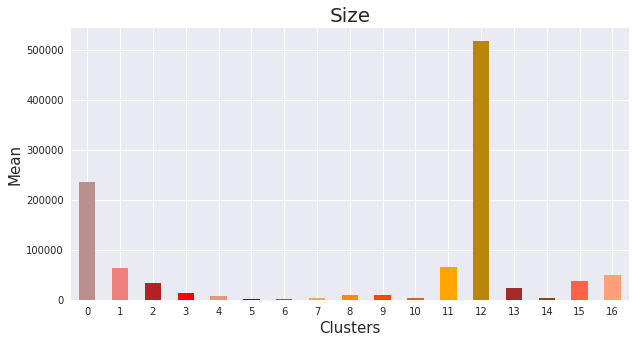

prediction
0     235186
1      64246
2      33181
3      13188
4       7688
5        900
6        655
7       3515
8       9918
9       8661
10      3434
11     65171
12    518516
13     24593
14      4009
15     37026
16     49170
dtype: int64


In [19]:
df = merged_data.groupby(["prediction"]).size()
df.plot(kind = "bar", figsize = (10,5), rot = 0, color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title("Size".capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)
plt.show()
print(df)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Viewing Behaviors </b> </h2> </center></font></div>

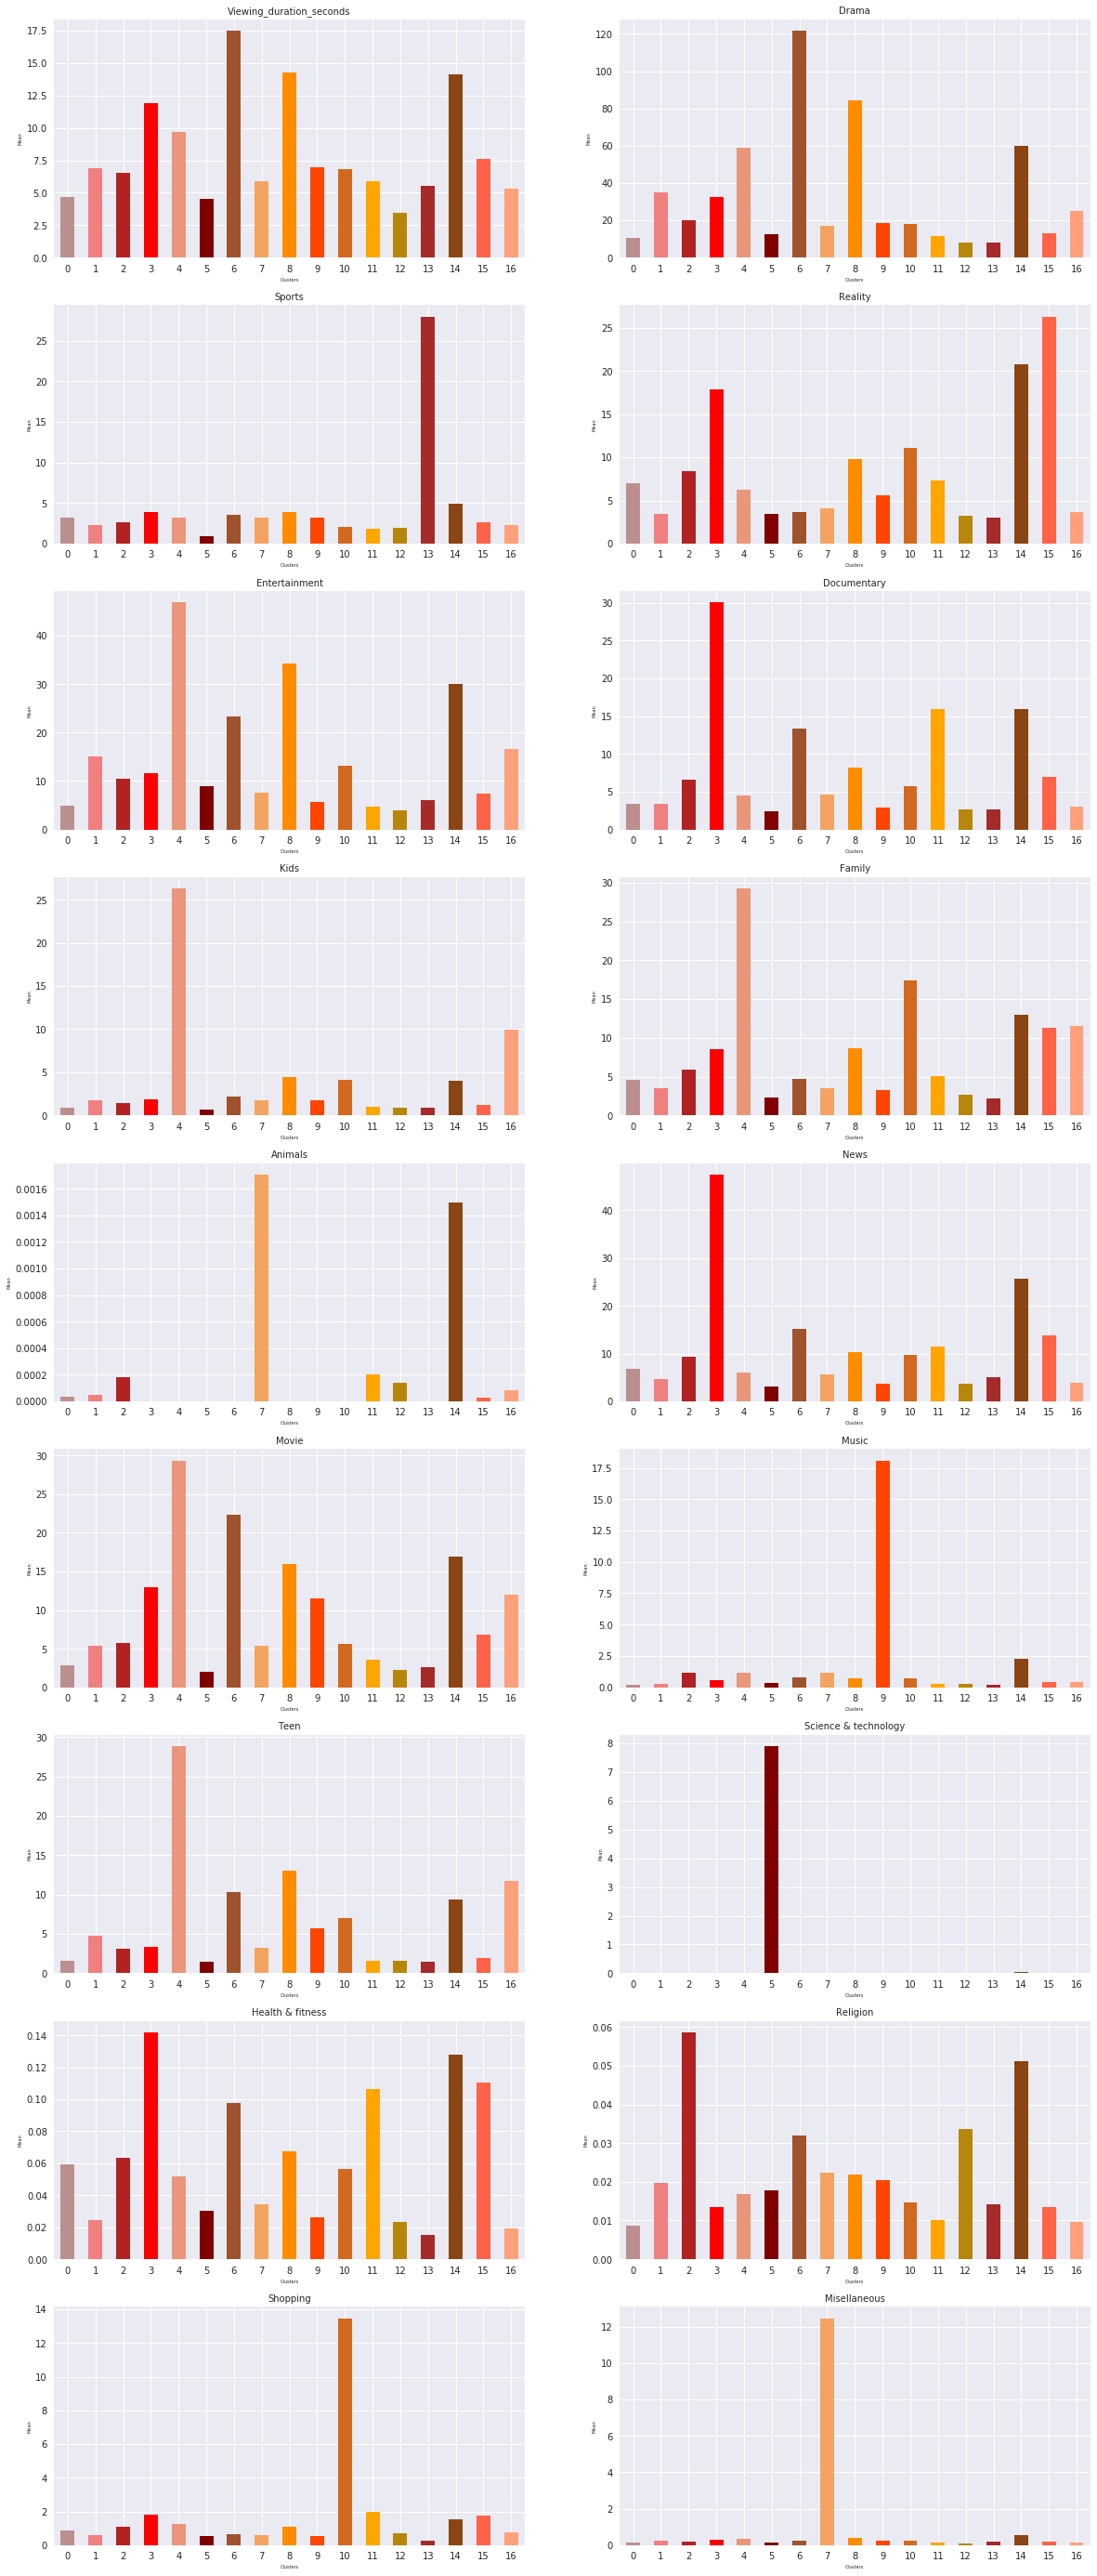

In [20]:
df = merged_data.groupby(["prediction"]).mean()
variables = ['Drama', 'Sports', 'Reality', 'Entertainment',
       'Documentary', 'Kids', 'Family', 'Animals', 'News', 'Movie', 'Music',
       'Teen', 'Science & Technology', 'Health & Fitness', 'Religion',
       'Shopping', 'Misellaneous']

COL_NUM = 2
ROW_NUM = 9
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,50))

ax = axes[0, 0]
    
    
(df["viewing_duration_seconds"]/3600).plot(kind = "bar", rot = 0, color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'], ax = ax)
ax.set_title("viewing_duration_seconds".capitalize(), size = 10)
ax.set_xlabel("Clusters", size = 5)
ax.set_ylabel("Mean", size = 5)

for i in range(1, len(variables)+1):
    variable = variables[i-1]
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    
    
    df[variable].plot(kind = "bar", rot = 0, color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'], ax = ax)
    ax.set_title(variable.capitalize(), size = 10)
    ax.set_xlabel("Clusters", size = 5)
    ax.set_ylabel("Mean", size = 5)
    
    fig.savefig('Clusters behavior.png')


<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Viewing Duration </b> </h2> </center></font></div>

Text(0, 0.5, 'Mean')

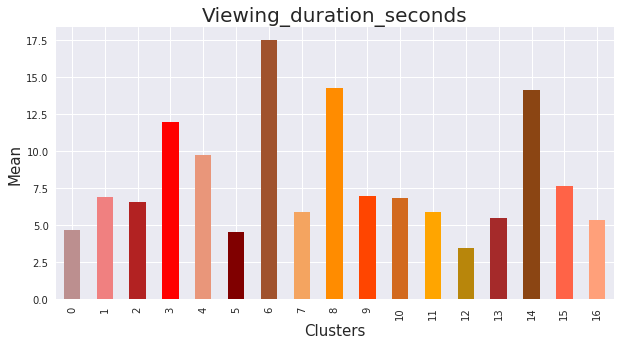

In [21]:
variable = "viewing_duration_seconds"

df = merged_data.groupby(["prediction"]).mean()
(df[variable]/3600).plot(kind = "bar", figsize = (10,5), color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Drama </b> </h2> </center></font></div>

Text(0, 0.5, 'Mean')

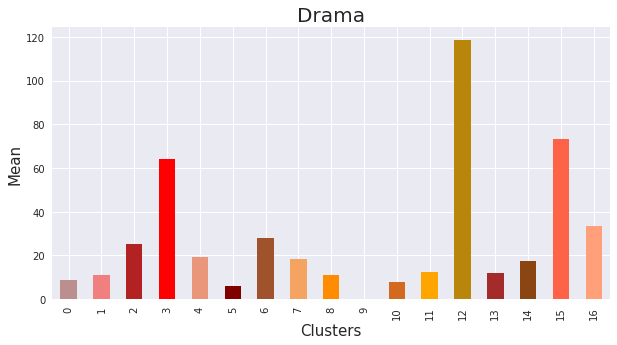

In [68]:
variable = "Drama"

df = merged_data.groupby(["prediction"]).mean()
df[variable].plot(kind = "bar", figsize = (10,5), color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Sports </b> </h2> </center></font></div>

Text(0, 0.5, 'Mean')

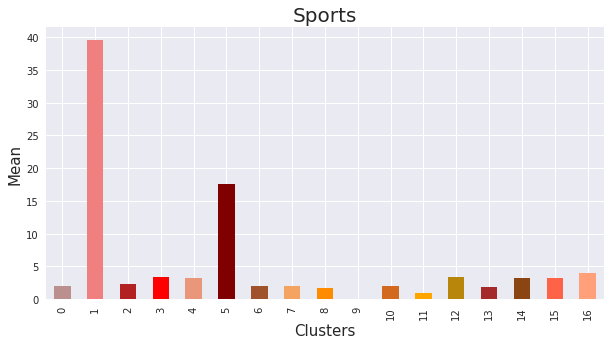

In [69]:
variable = "Sports"

df = merged_data.groupby(["prediction"]).mean()
df[variable].plot(kind = "bar", figsize = (10,5), color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Reality </b> </h2> </center></font></div>

Text(0, 0.5, 'Mean')

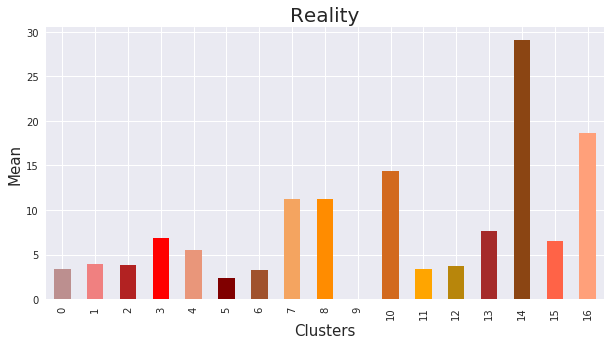

In [70]:
variable = "Reality"

df = merged_data.groupby(["prediction"]).mean()
df[variable].plot(kind = "bar", figsize = (10,5), color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Entertainment </b> </h2> </center></font></div>

Text(0, 0.5, 'Mean')

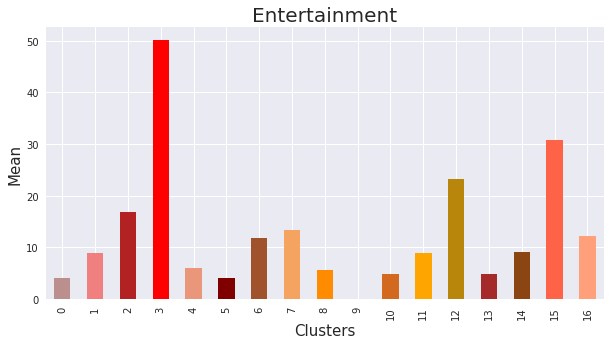

In [71]:
variable = "Entertainment"

df = merged_data.groupby(["prediction"]).mean()
df[variable].plot(kind = "bar", figsize = (10,5), color = ['rosybrown', 'lightcoral', 'firebrick', 'red', 'darksalmon',
                                                          'maroon', 'sienna', 'sandybrown', 'darkorange', 'orangered',
                                                          'chocolate', 'orange', 'darkgoldenrod', 'brown', 'saddlebrown',
                                                          'tomato', 'lightsalmon'])
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Mean", size = 15)

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> Age </b> </h2> </center></font></div>

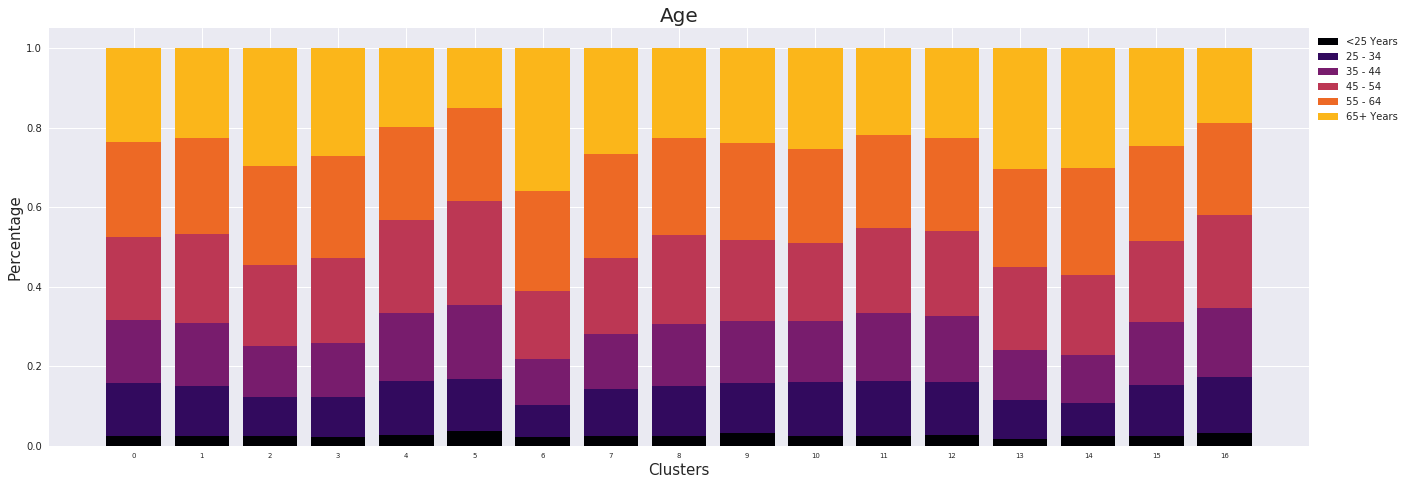

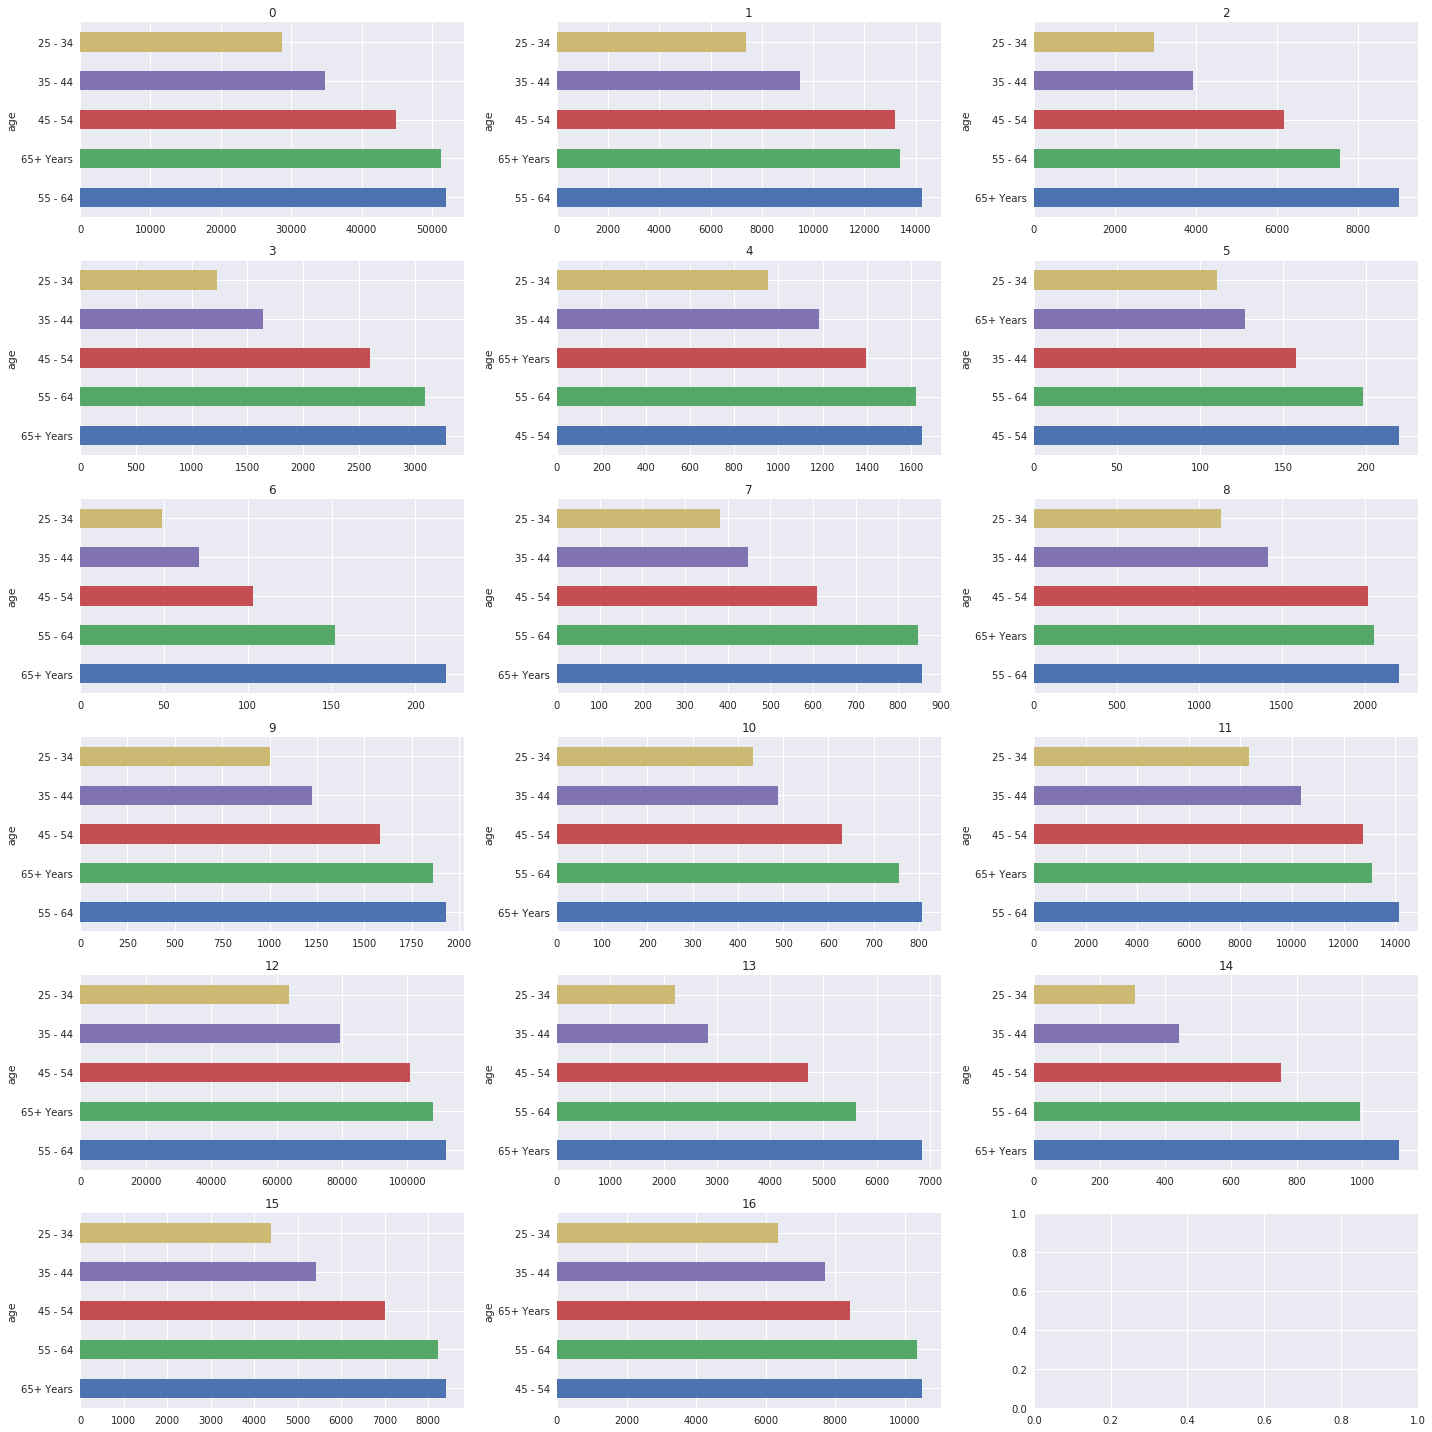

In [22]:
variable = "age"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]
degList = [degList[-1]] + degList[:-1]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <font color ="ForestGreen"><center> <h2> <b> AFN IND </b> </h2> </center></font></div>

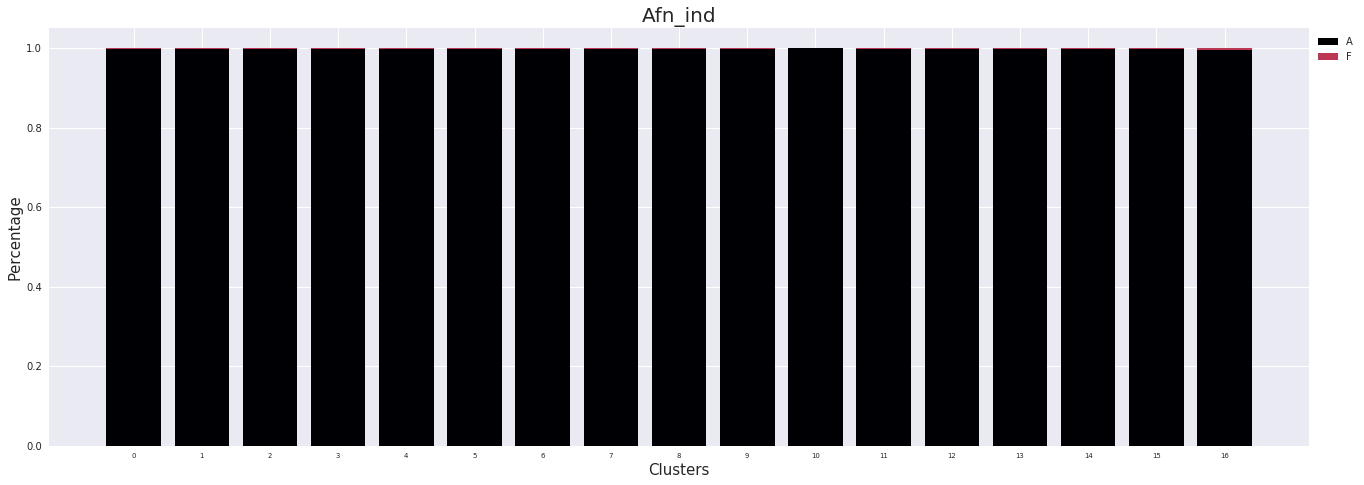

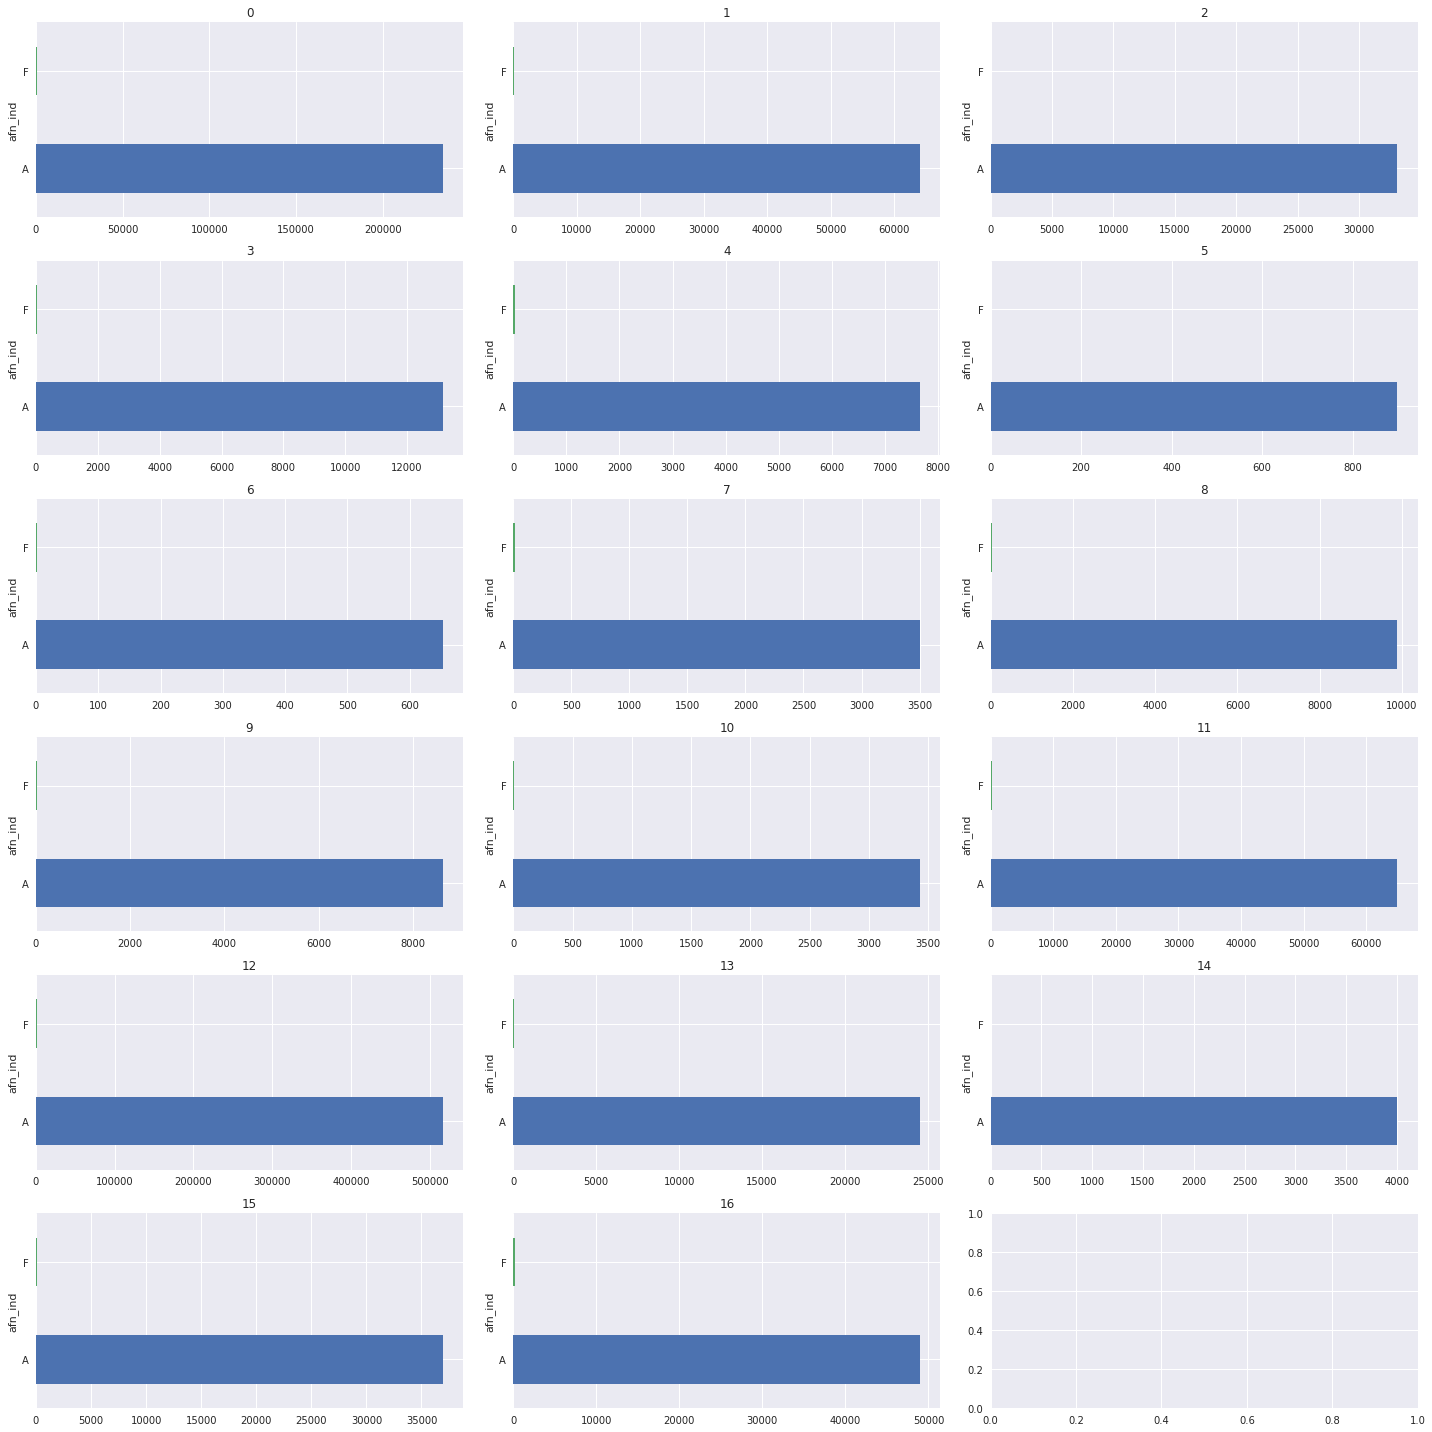

In [23]:
variable = "afn_ind"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> Analog Use: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

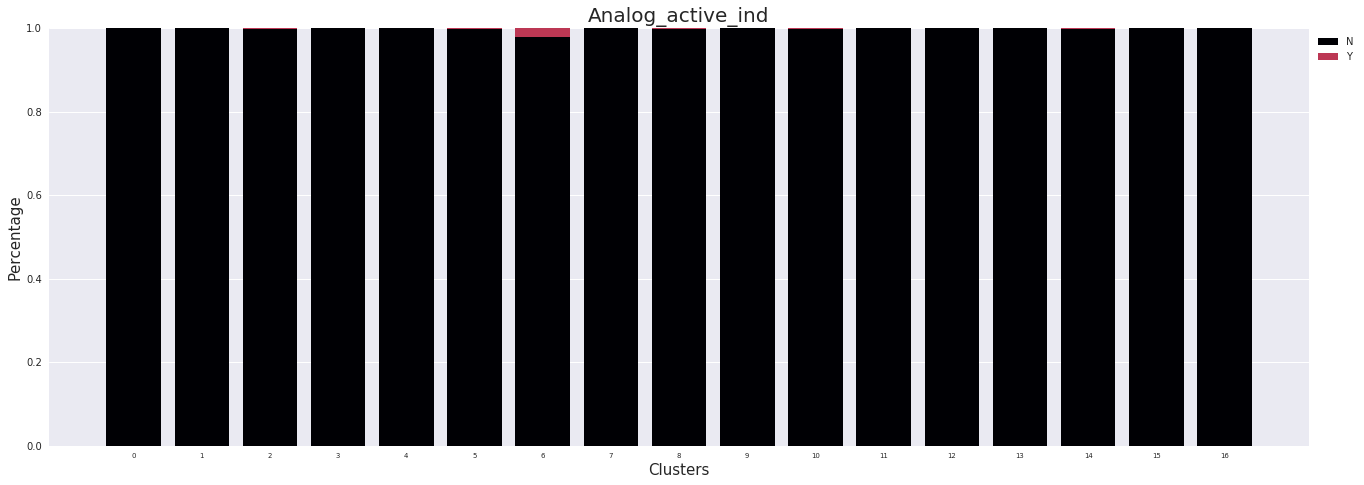

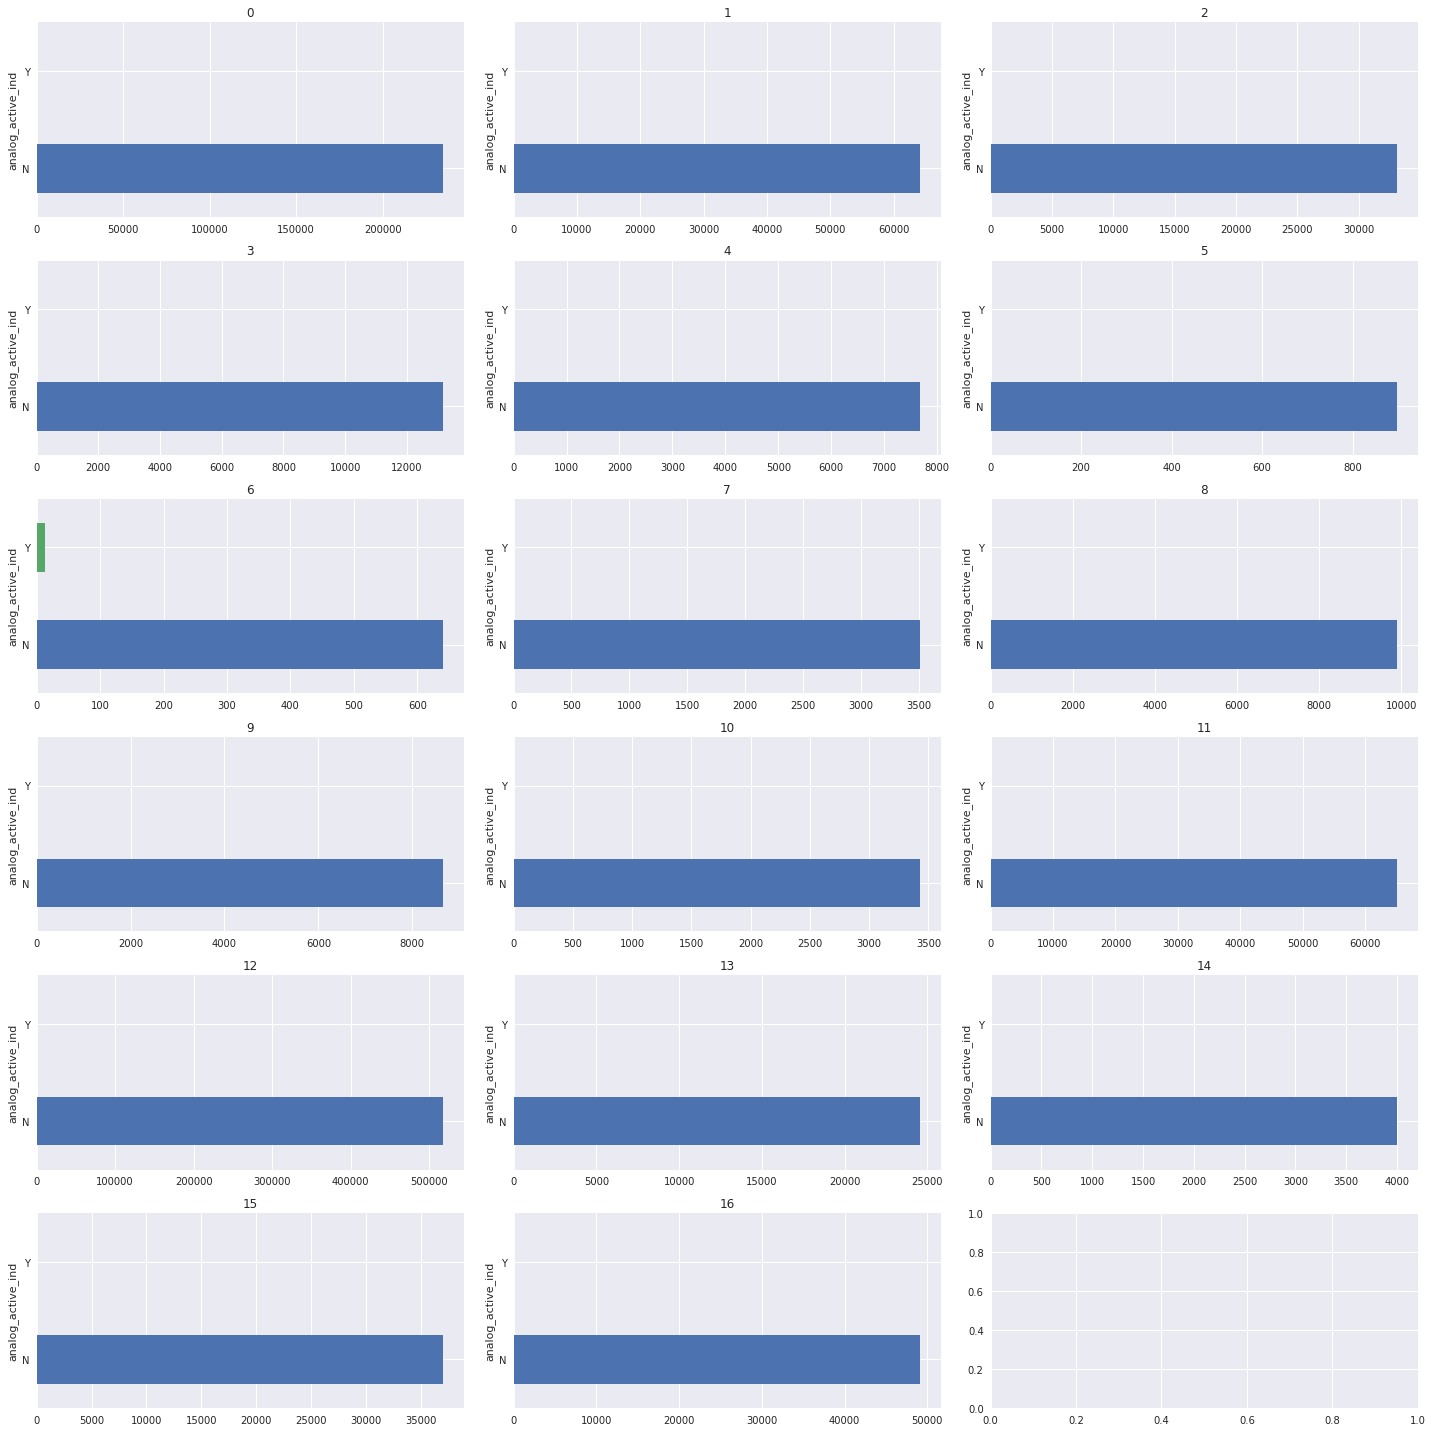

In [24]:
variable = "analog_active_ind"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> Computer Ownership: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

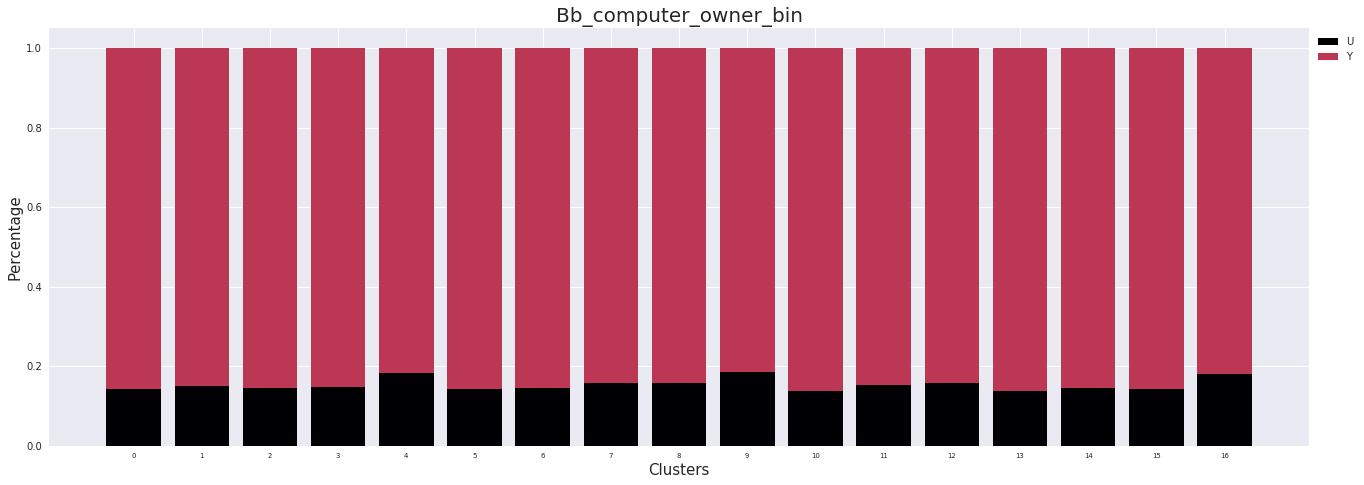

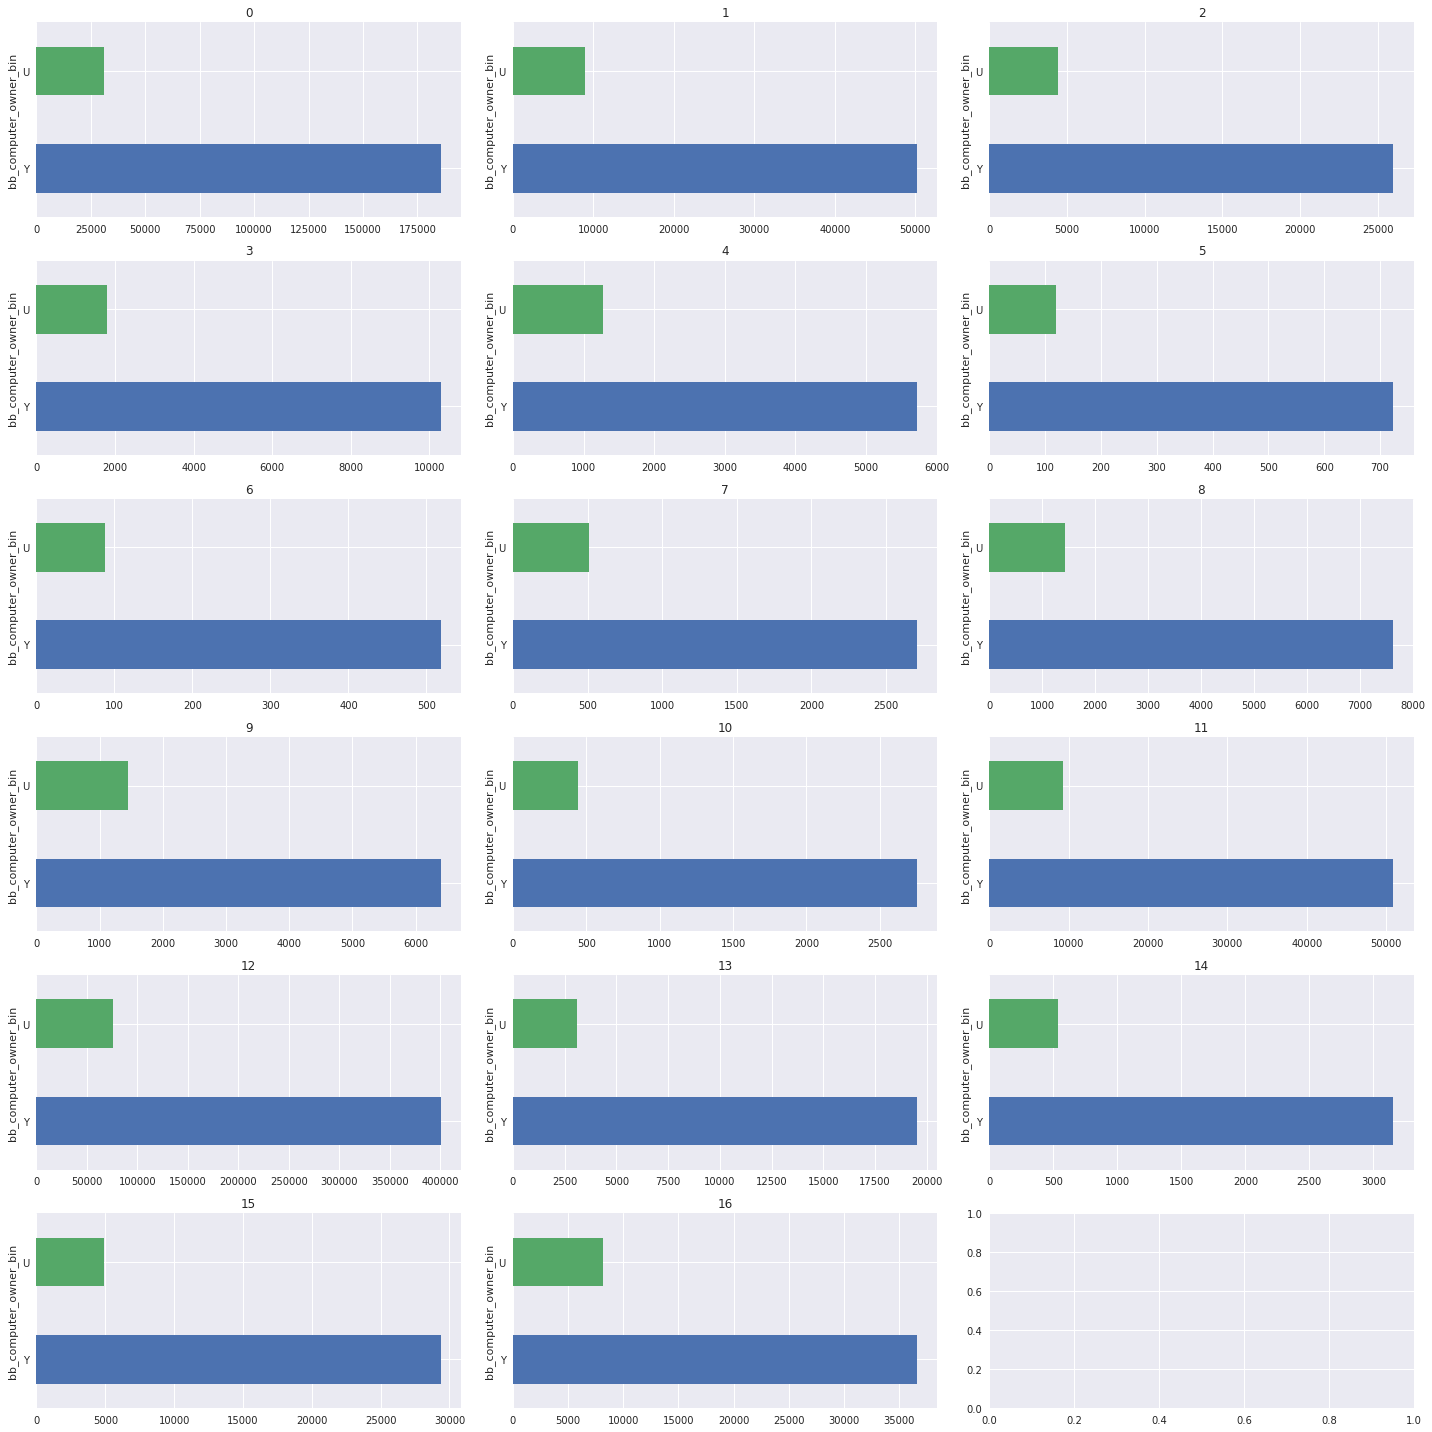

In [25]:
variable = "bb_computer_owner_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> bb_premium_credit_card_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

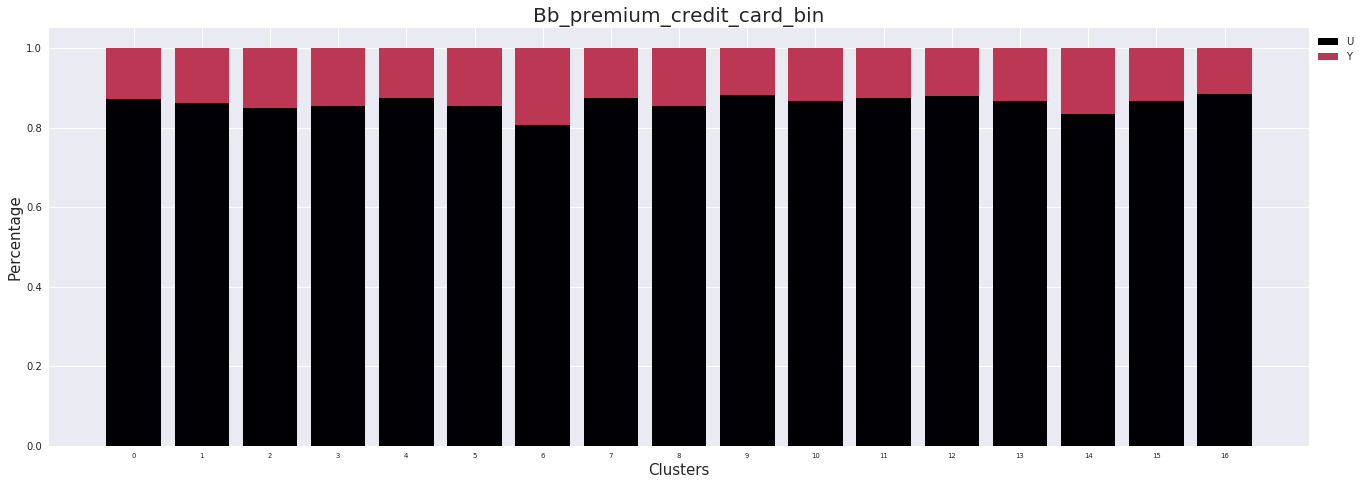

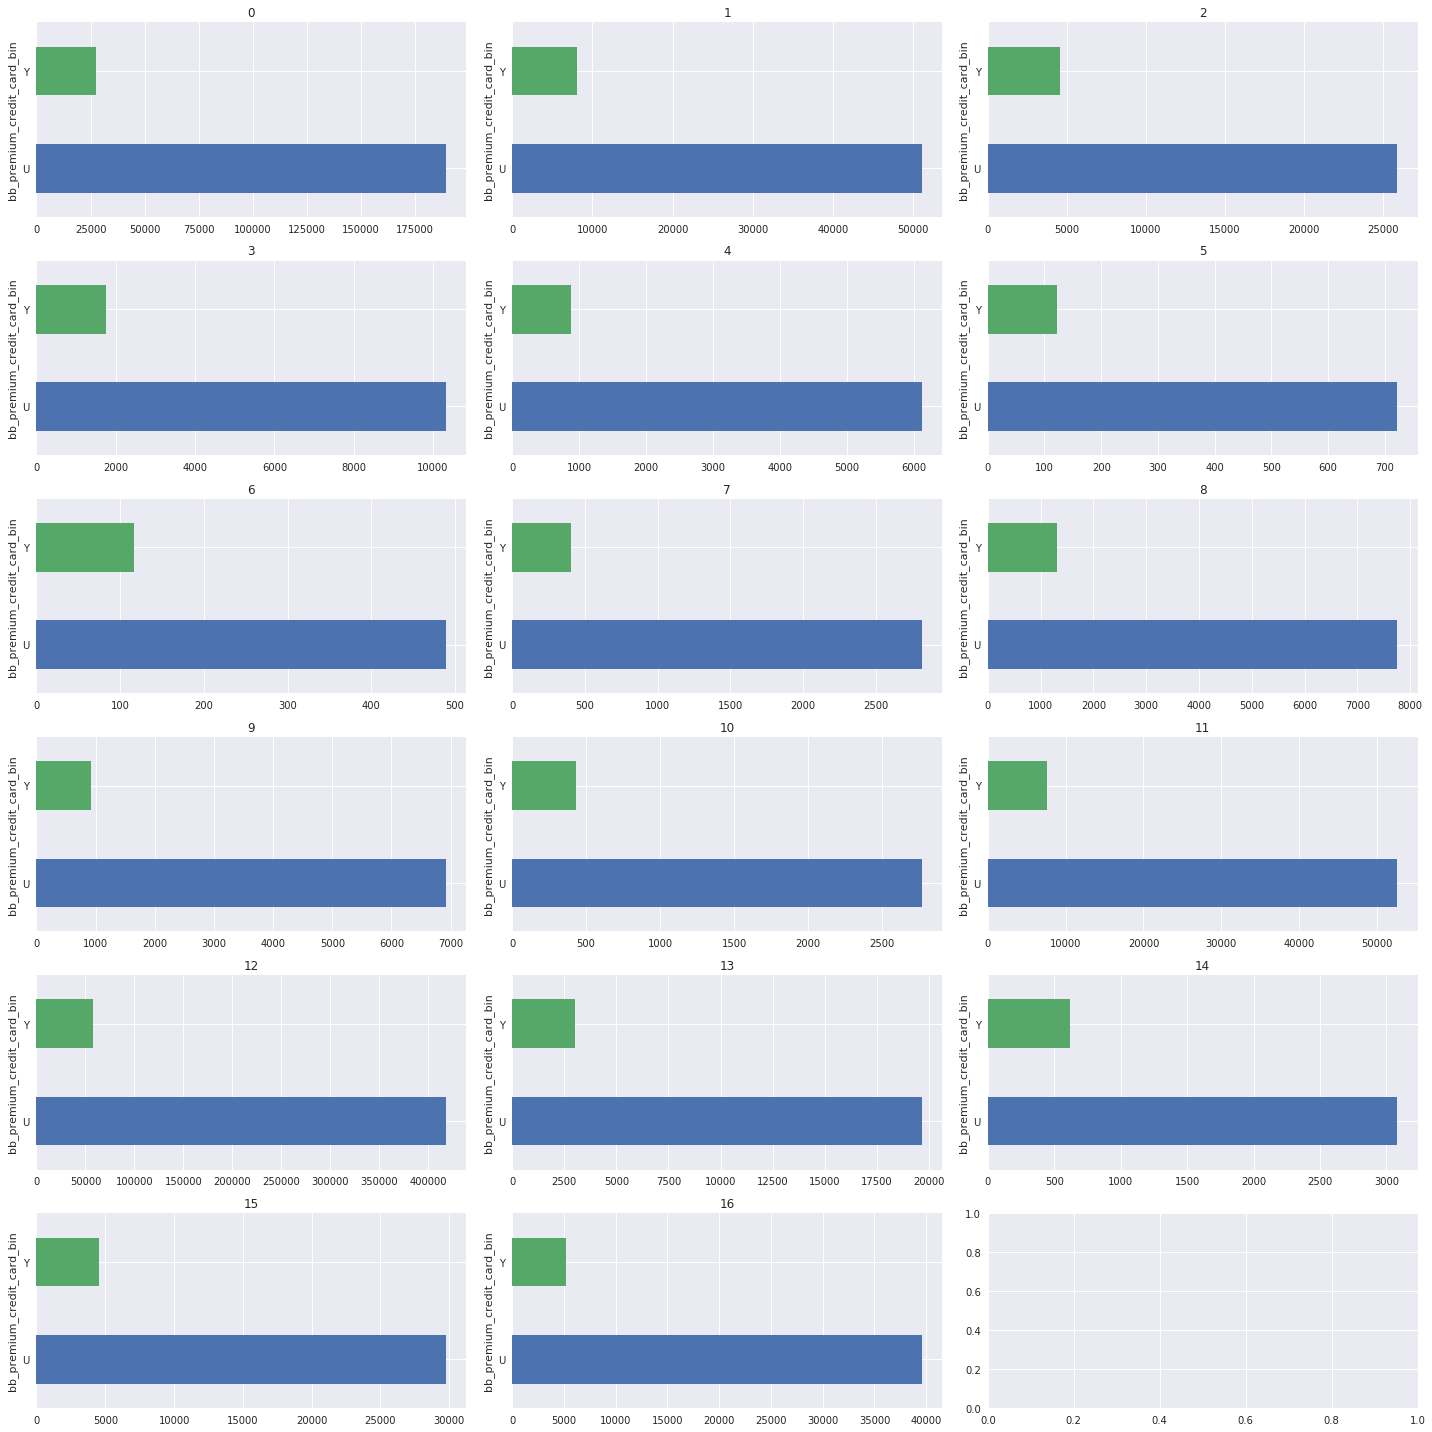

In [26]:
variable = "bb_premium_credit_card_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> bb_presence_of_creditcard_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


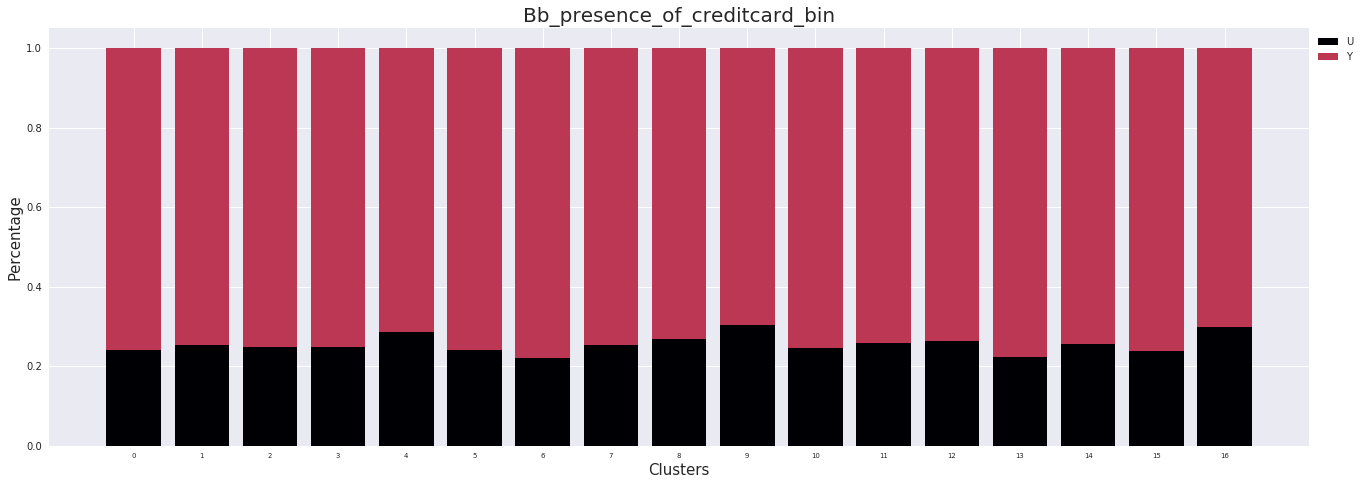

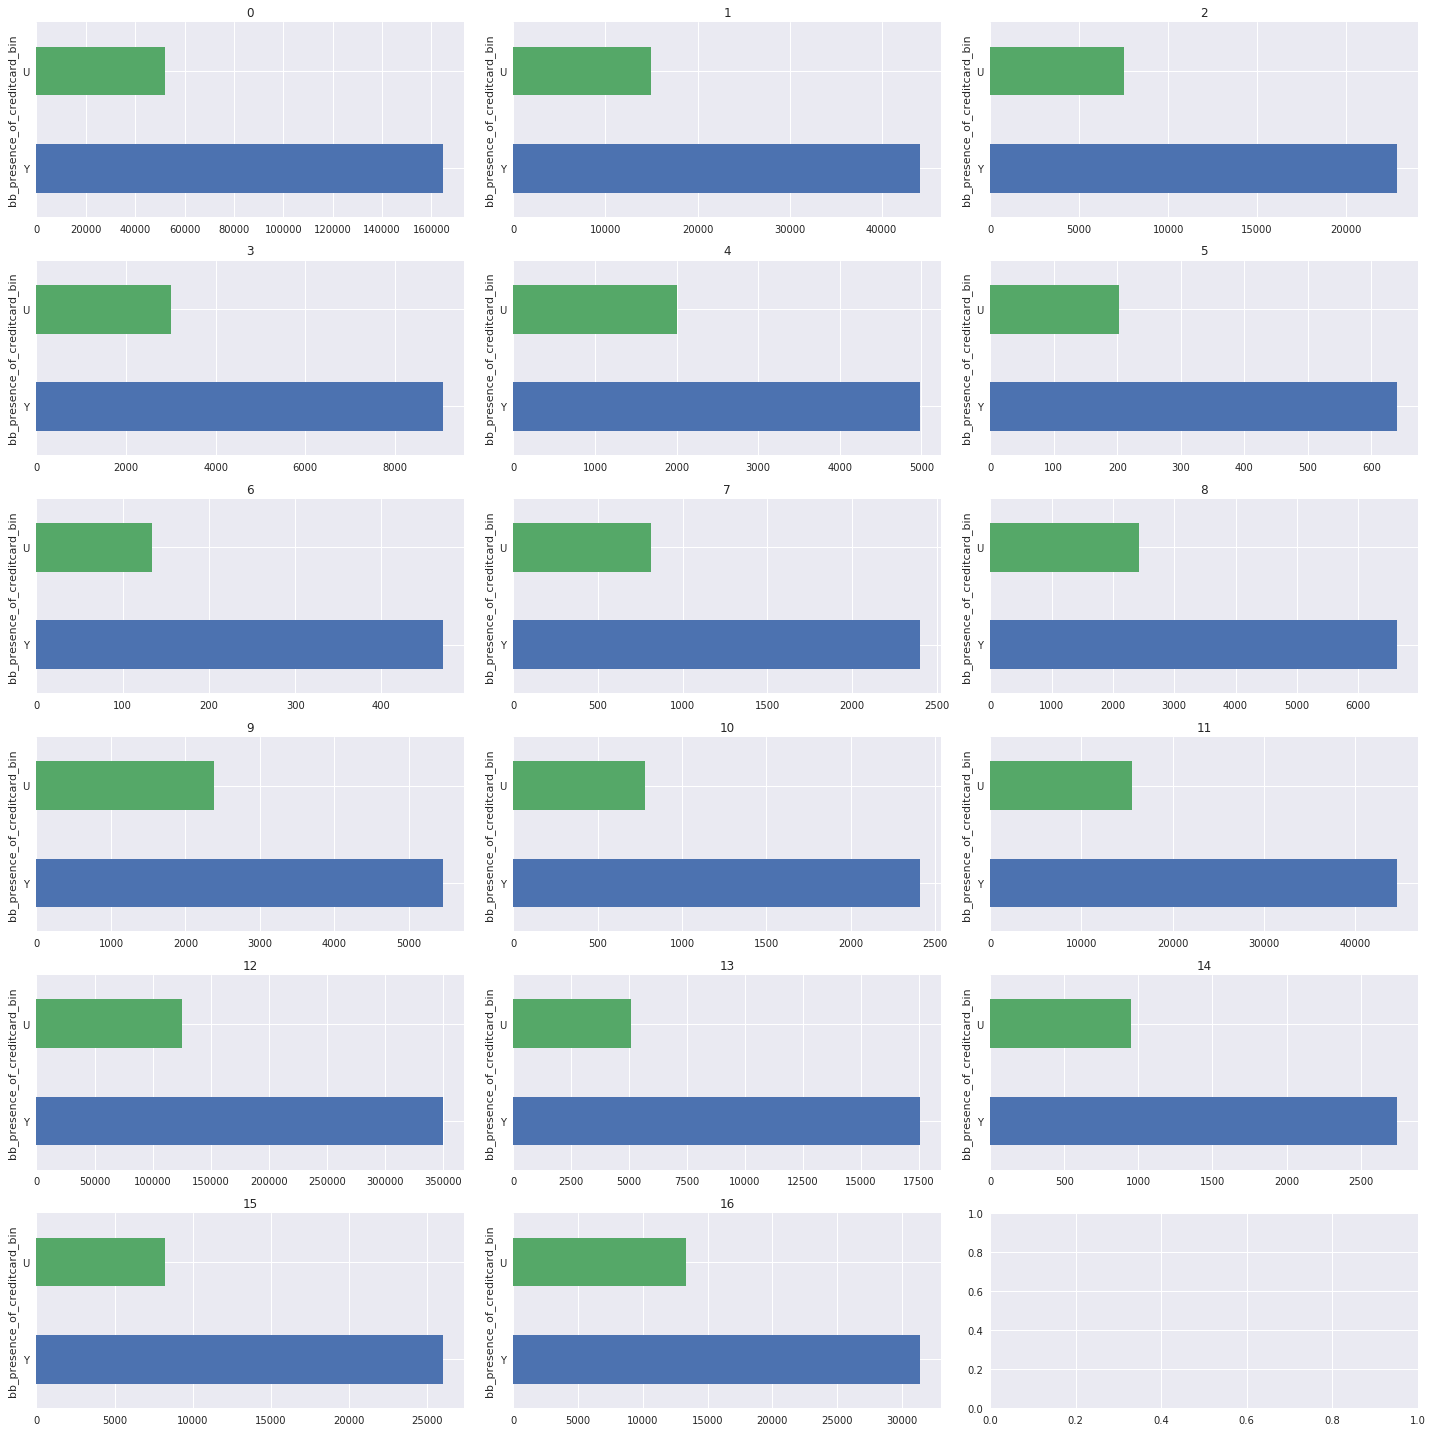

In [27]:
variable = "bb_presence_of_creditcard_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> biz_resi_flag: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


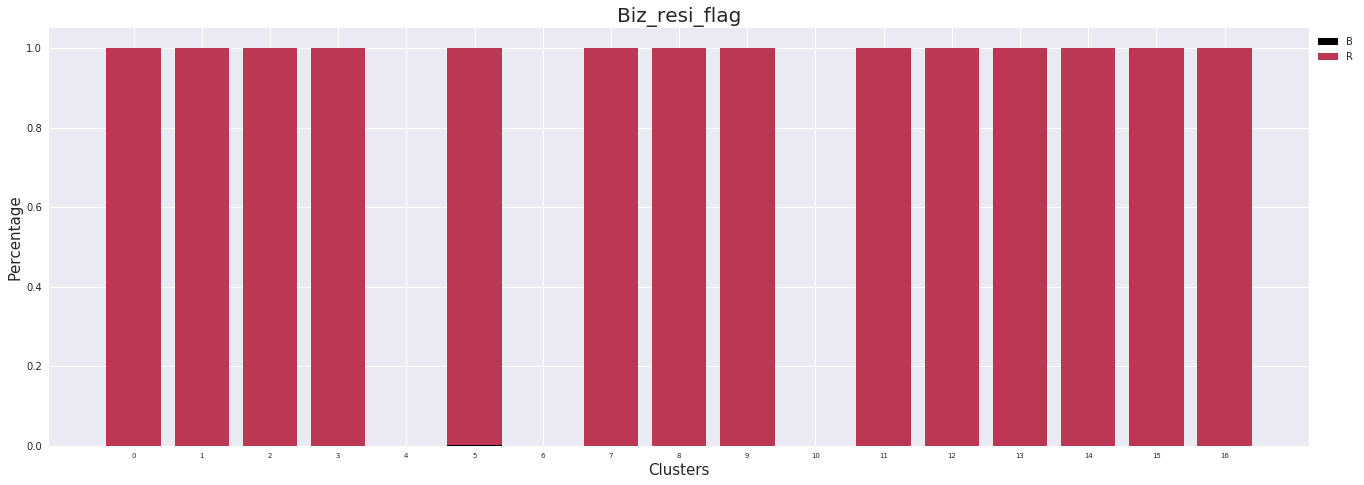

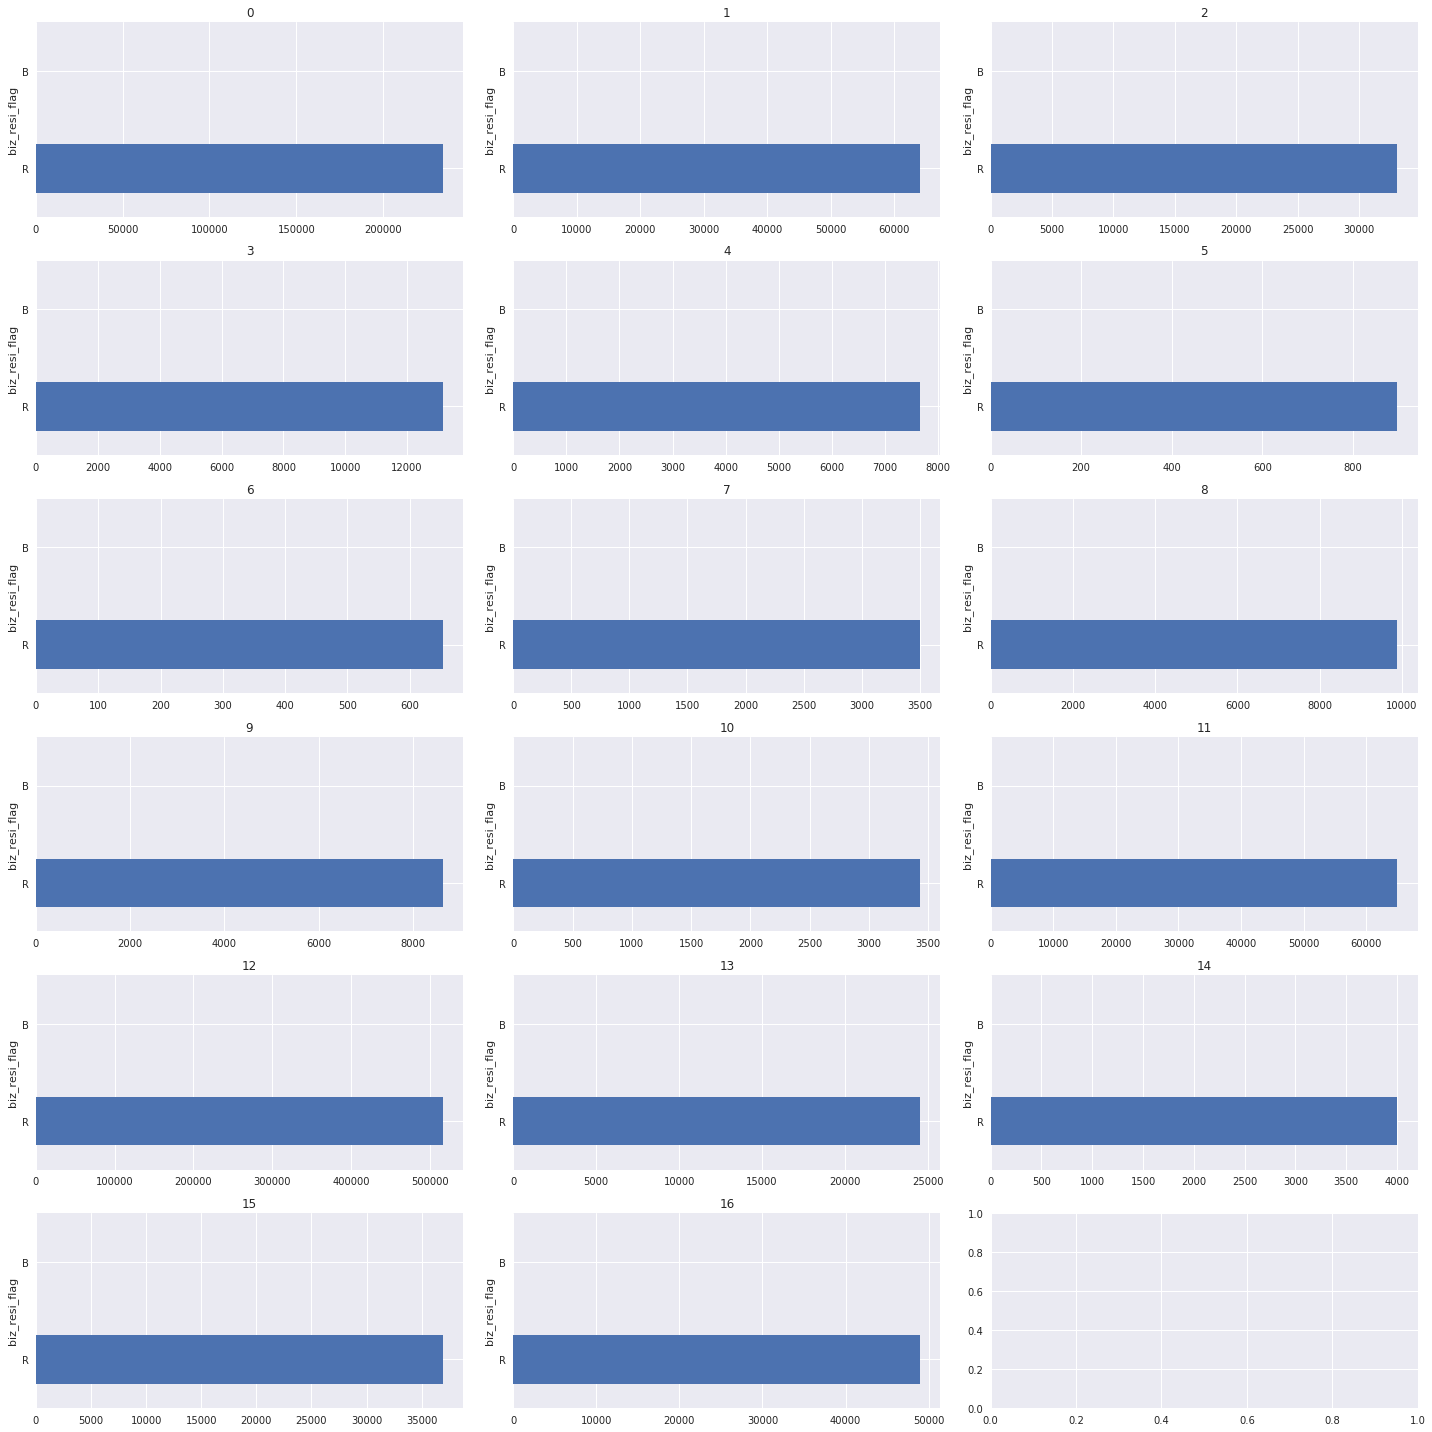

In [28]:
variable = "biz_resi_flag"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_0t18_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


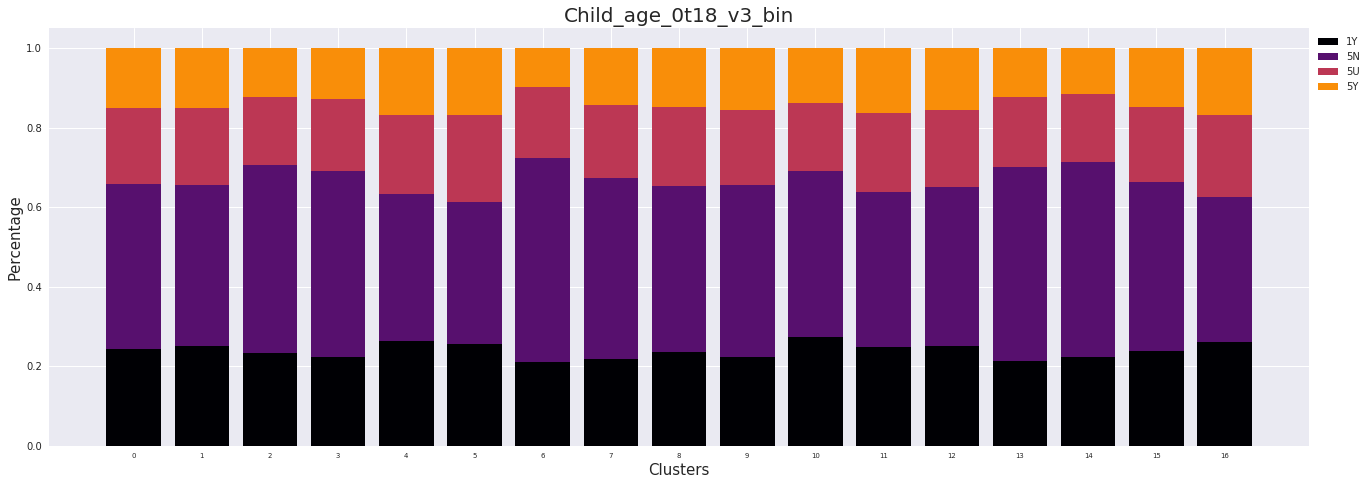

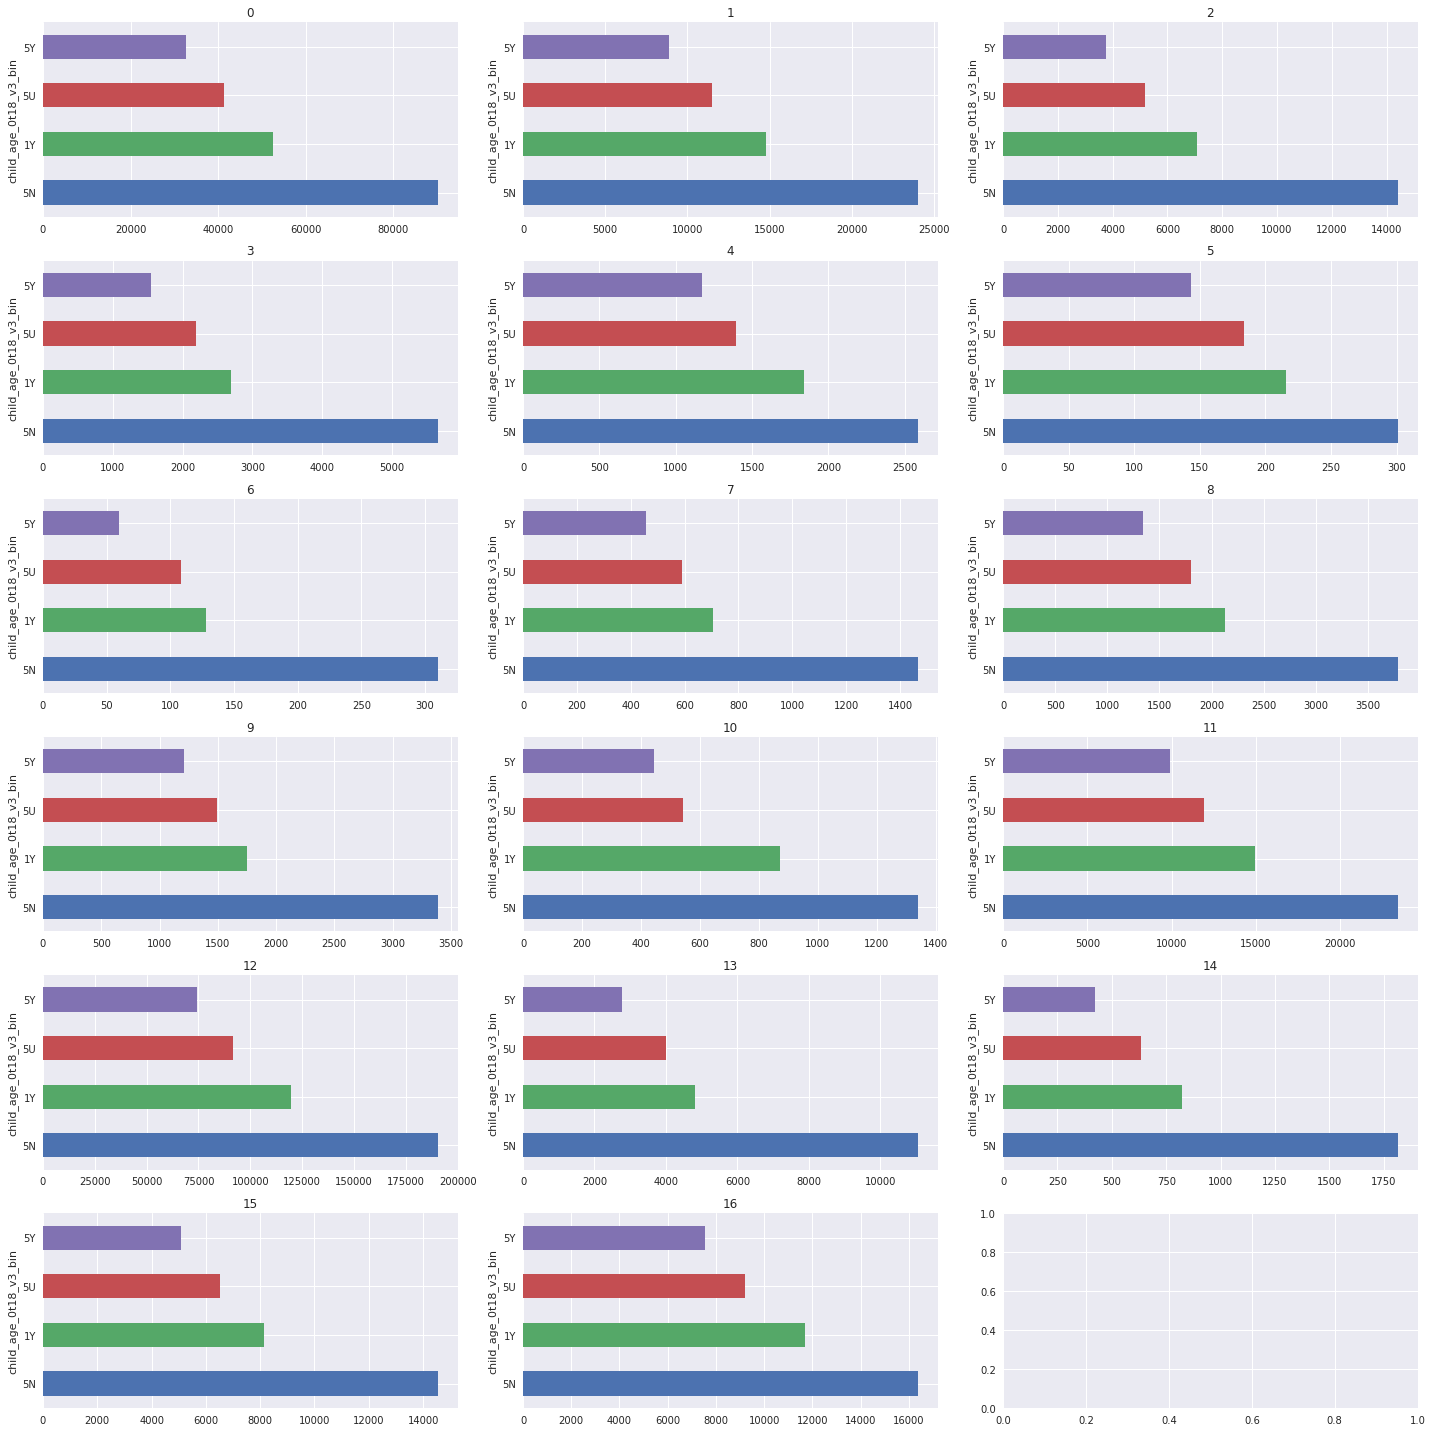

In [29]:
variable = "child_age_0t18_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_0t3_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


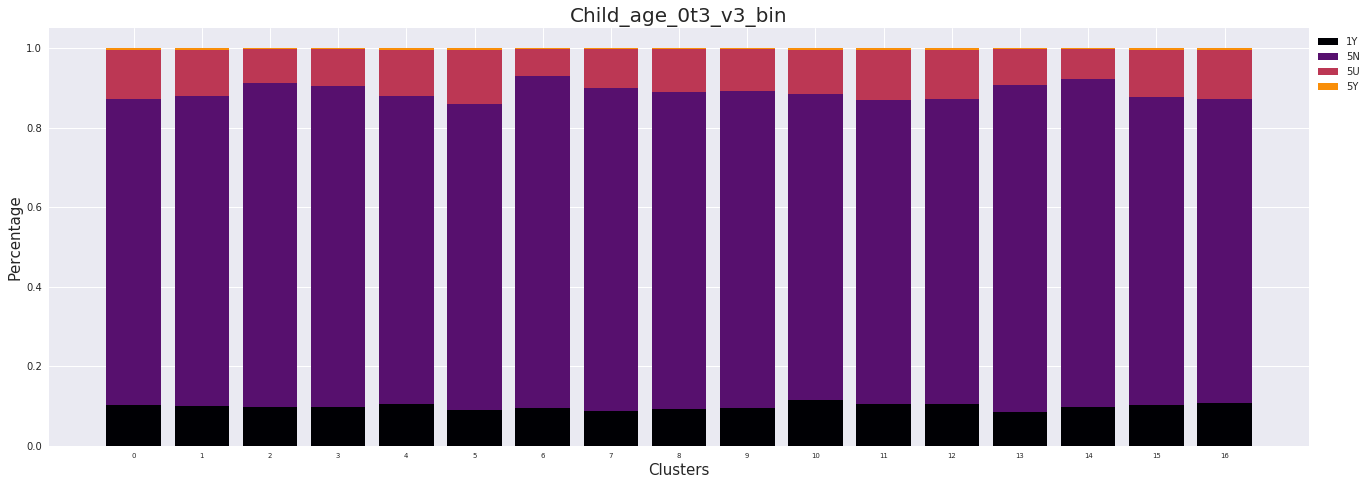

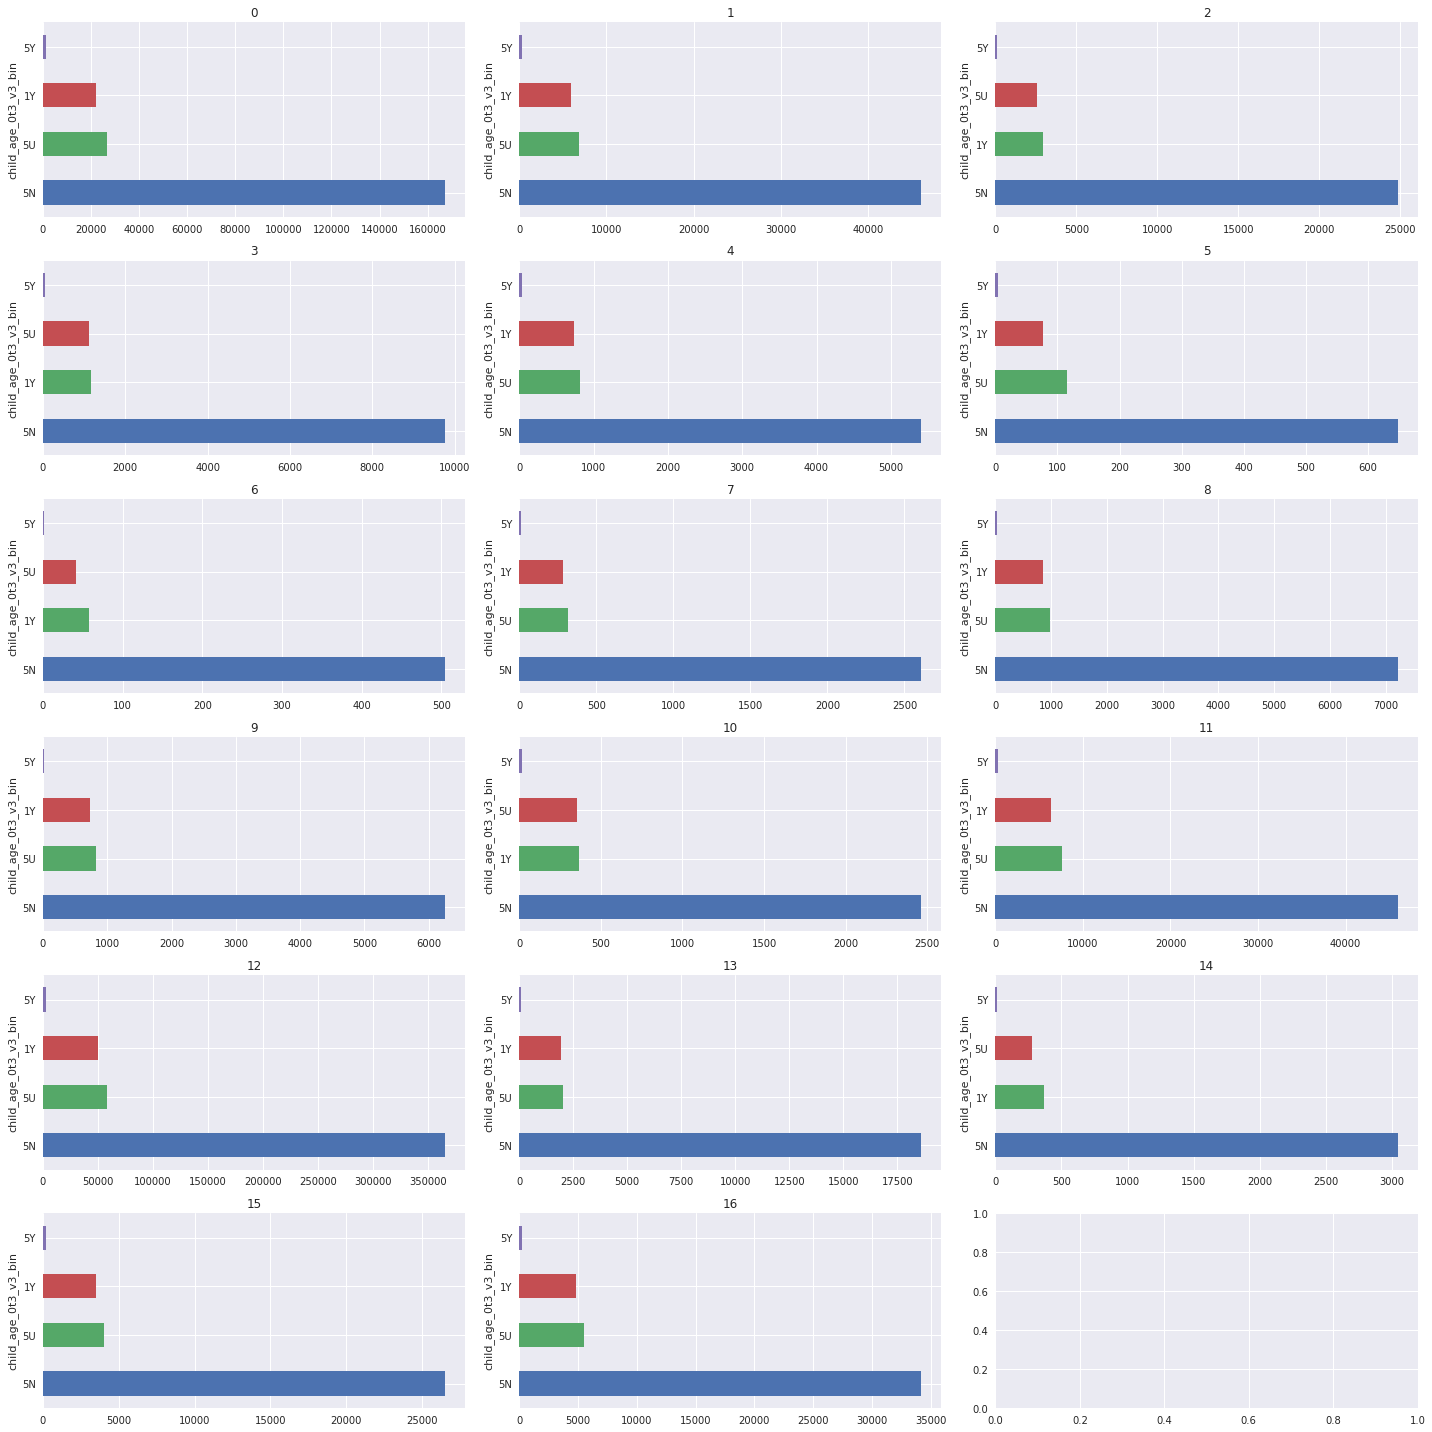

In [30]:
variable = "child_age_0t3_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_4t6_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


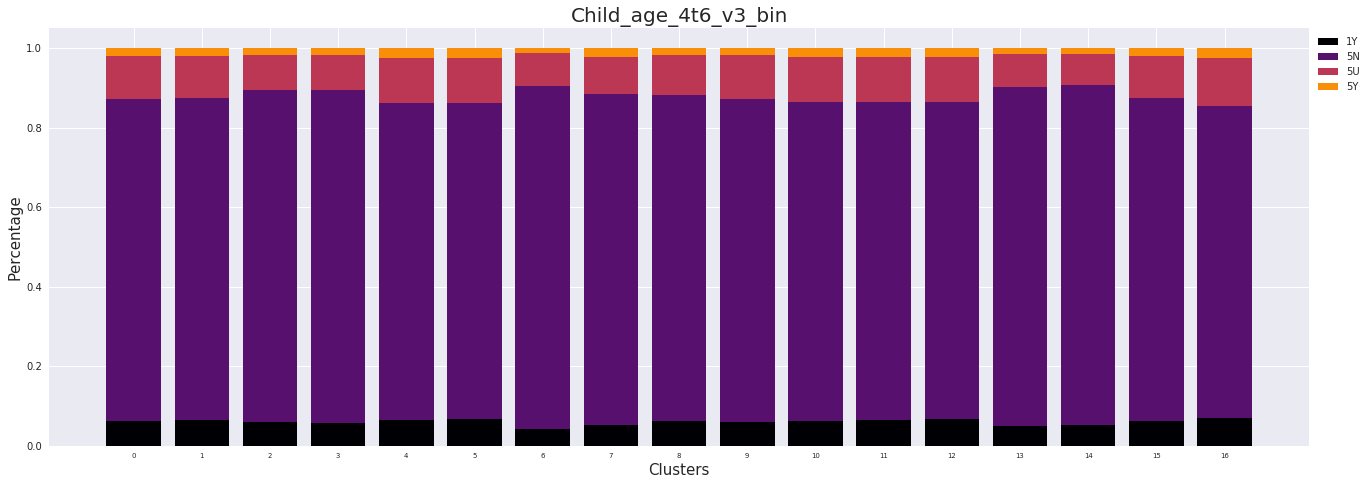

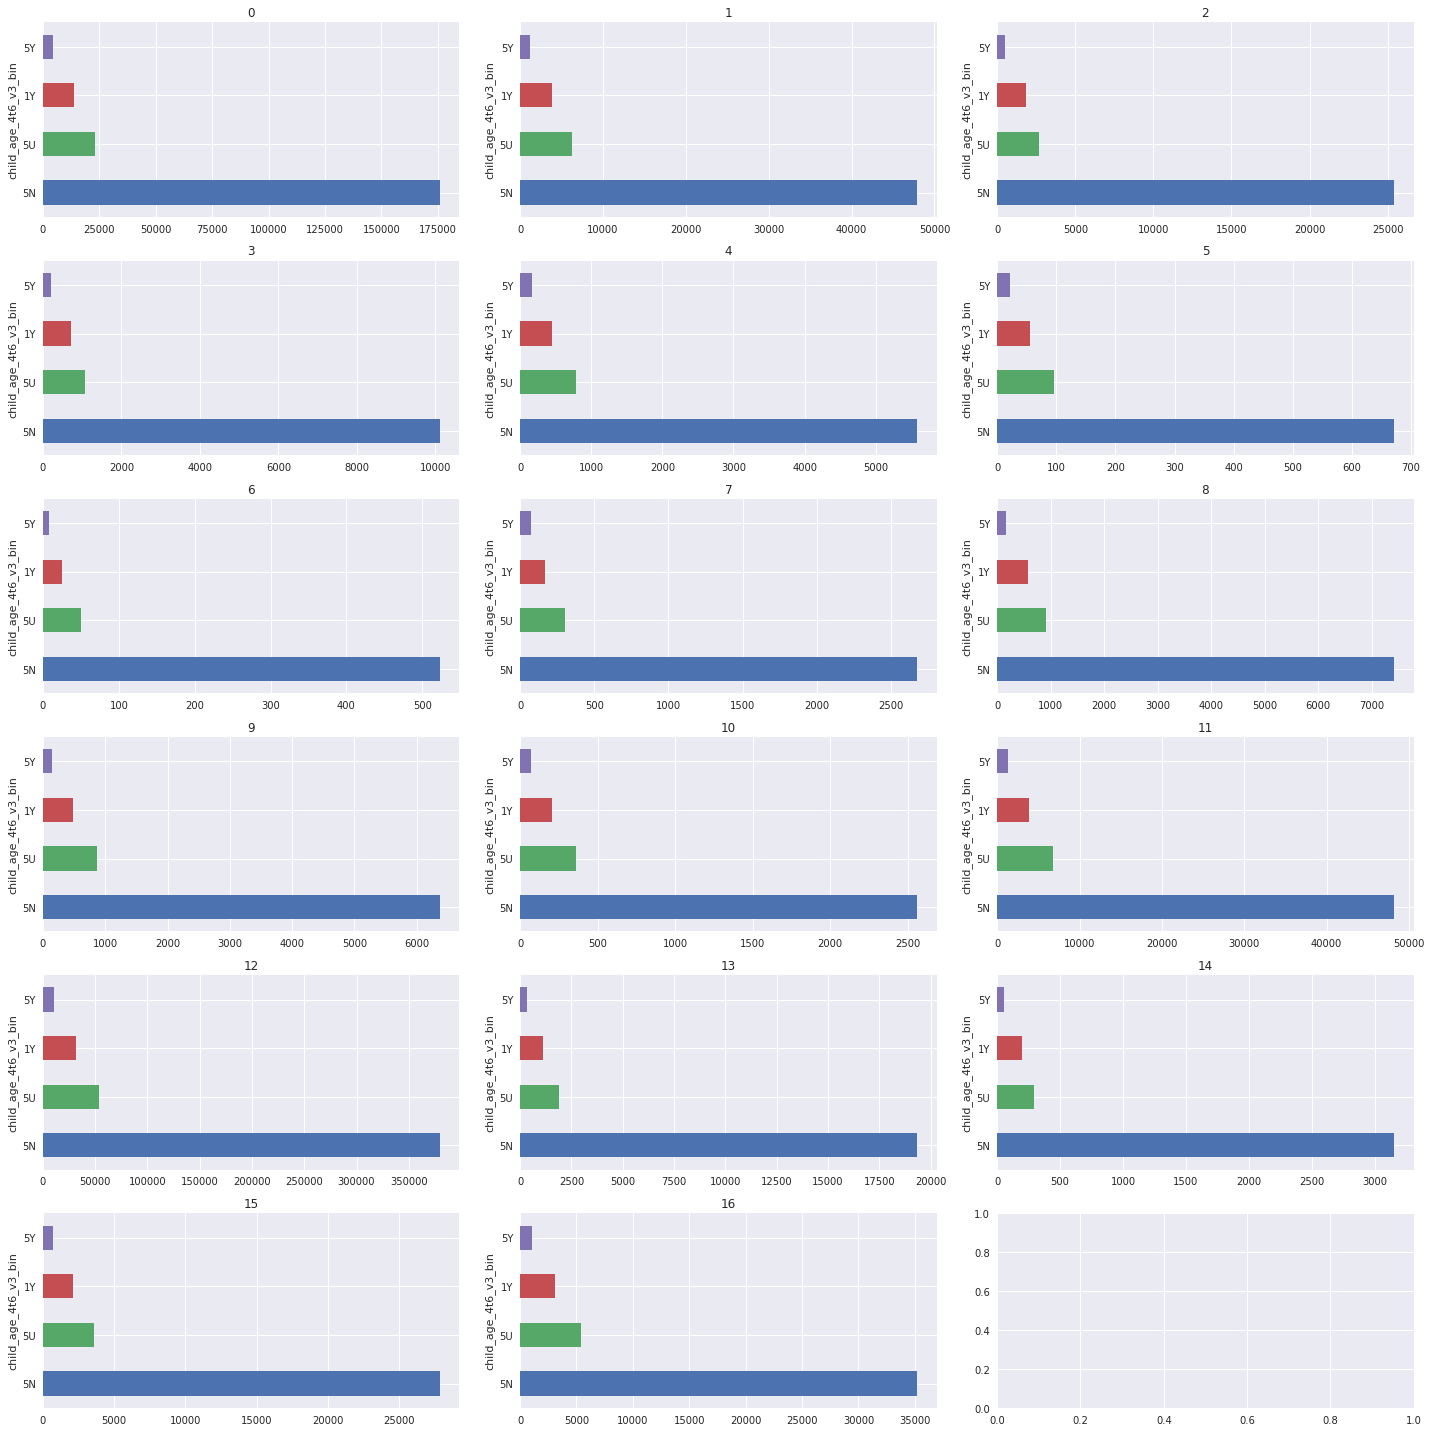

In [31]:
variable = "child_age_4t6_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_7t9_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>


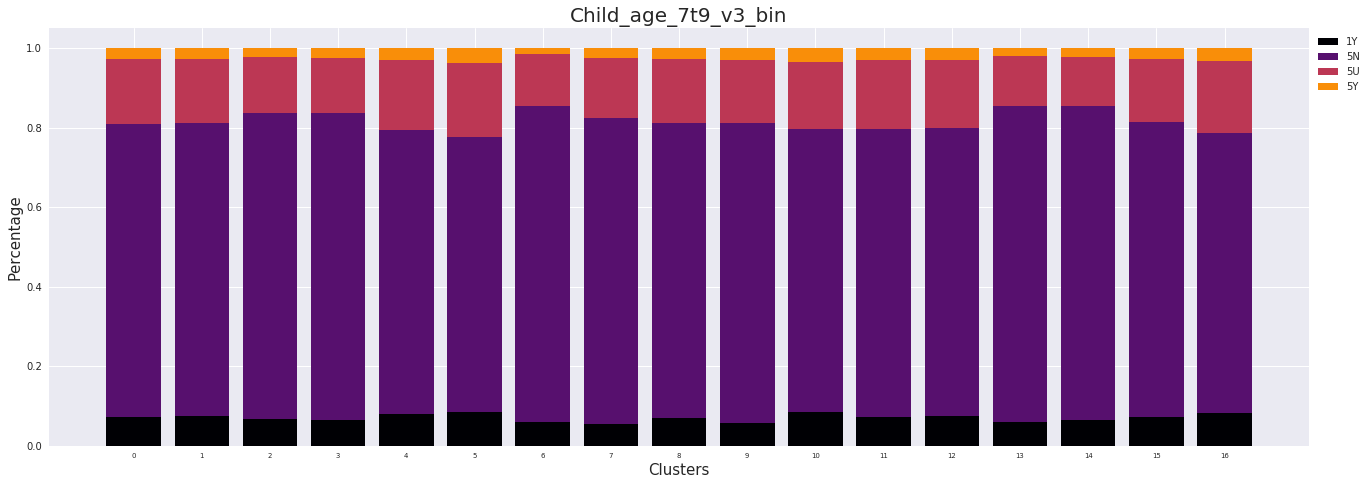

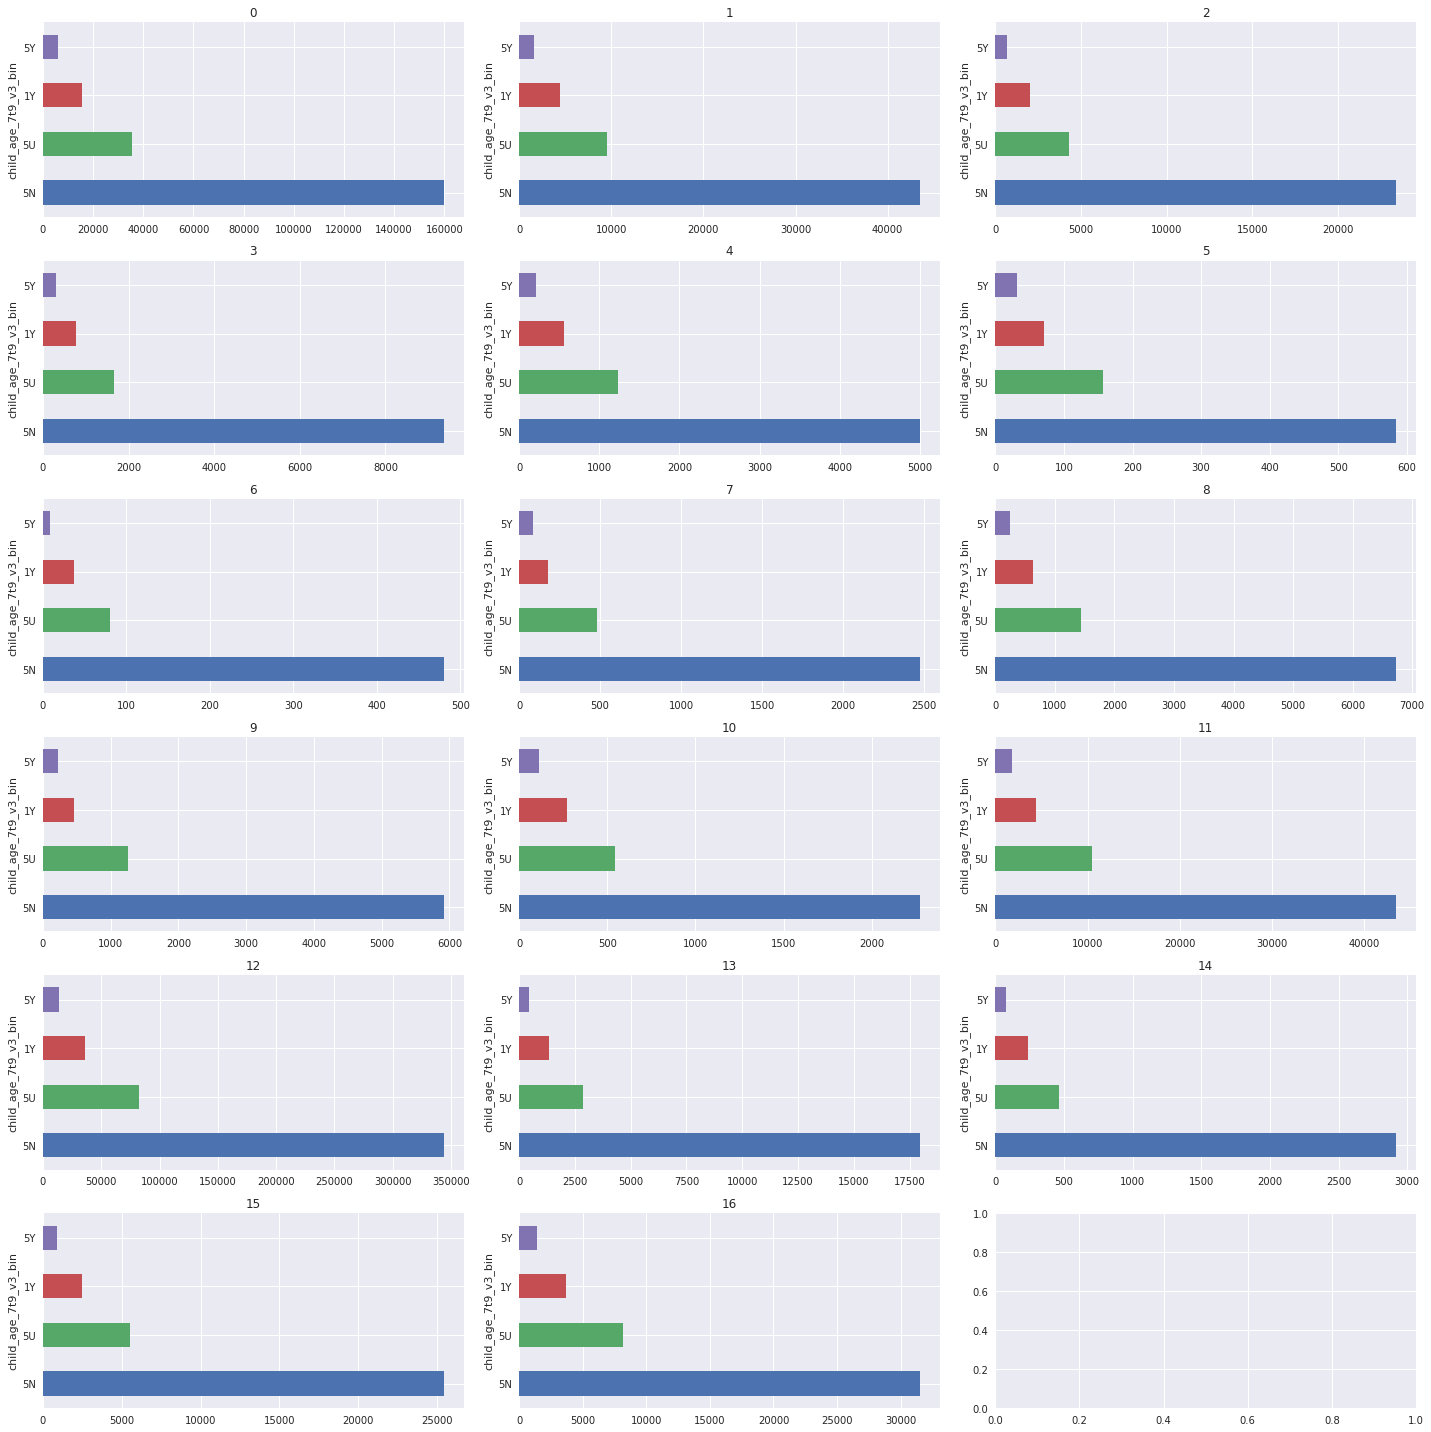

In [32]:
variable = "child_age_7t9_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

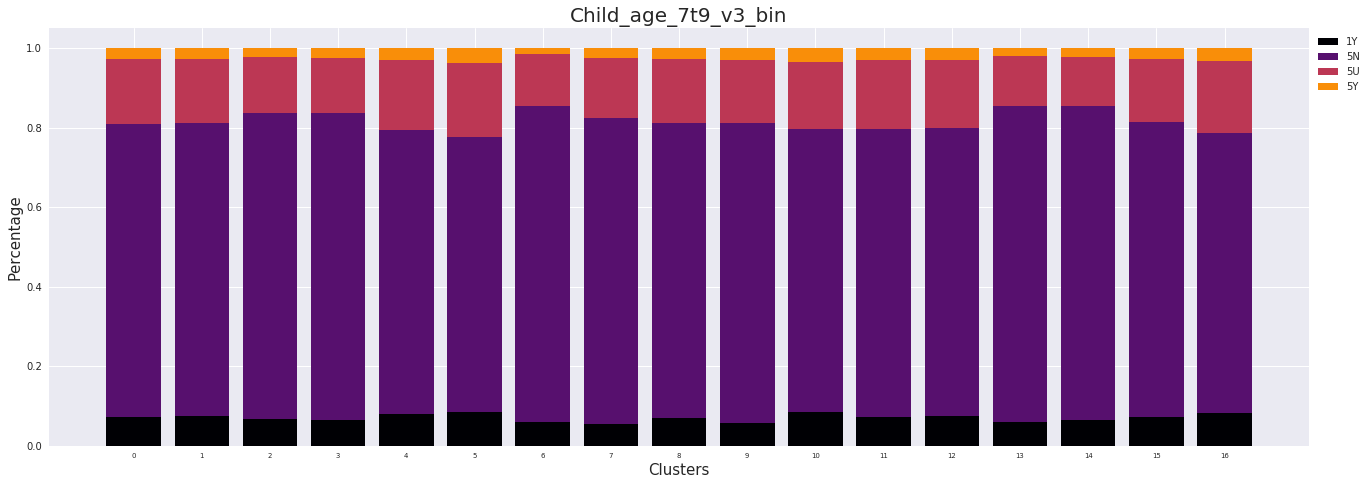

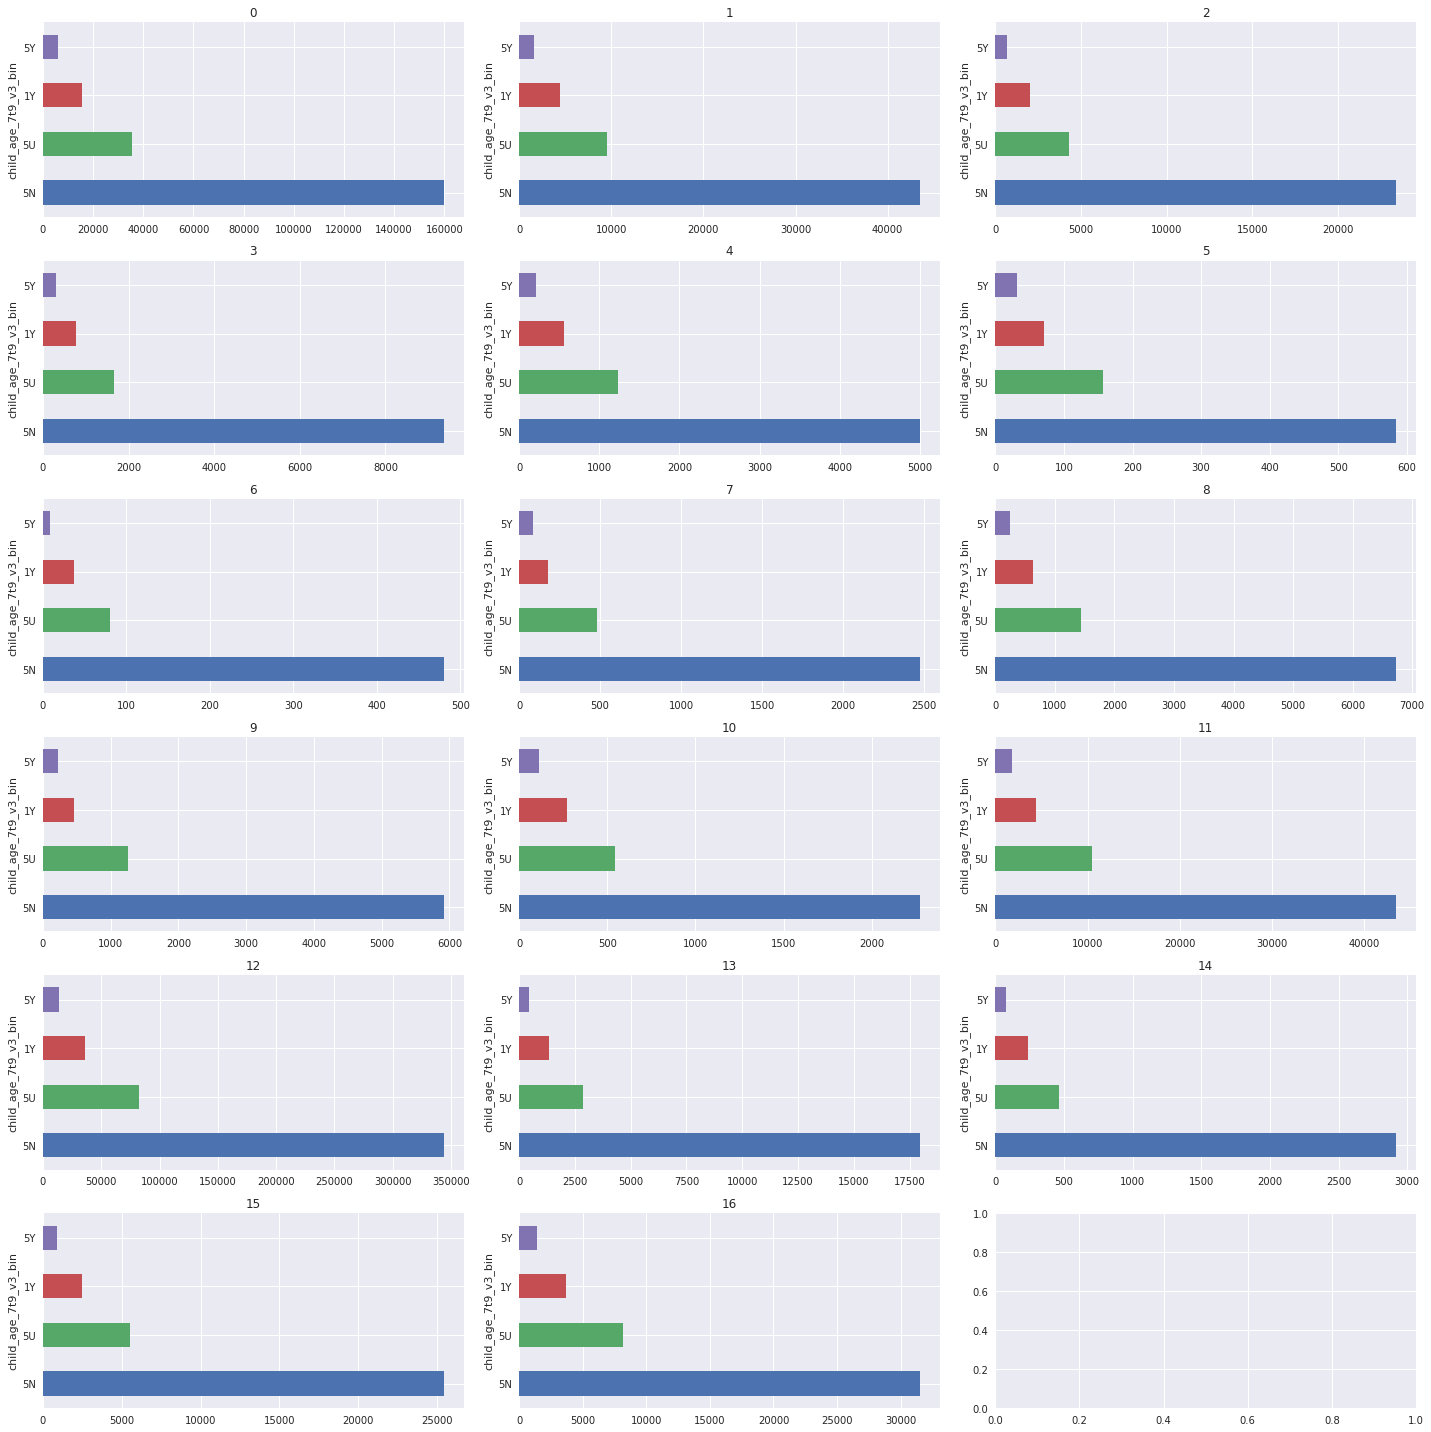

In [33]:
variable = "child_age_7t9_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_10t12_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

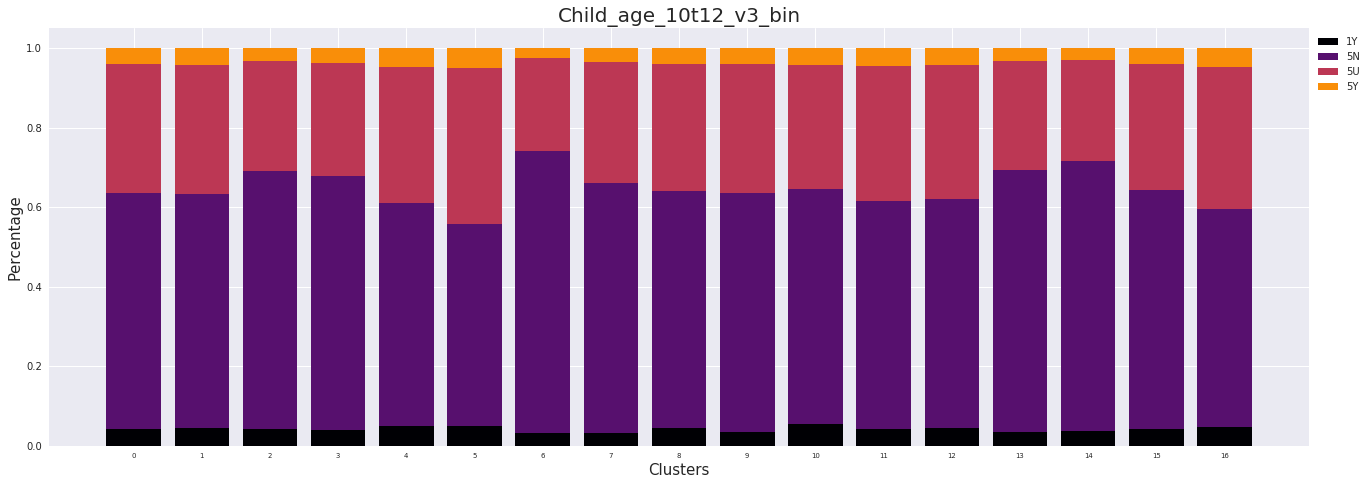

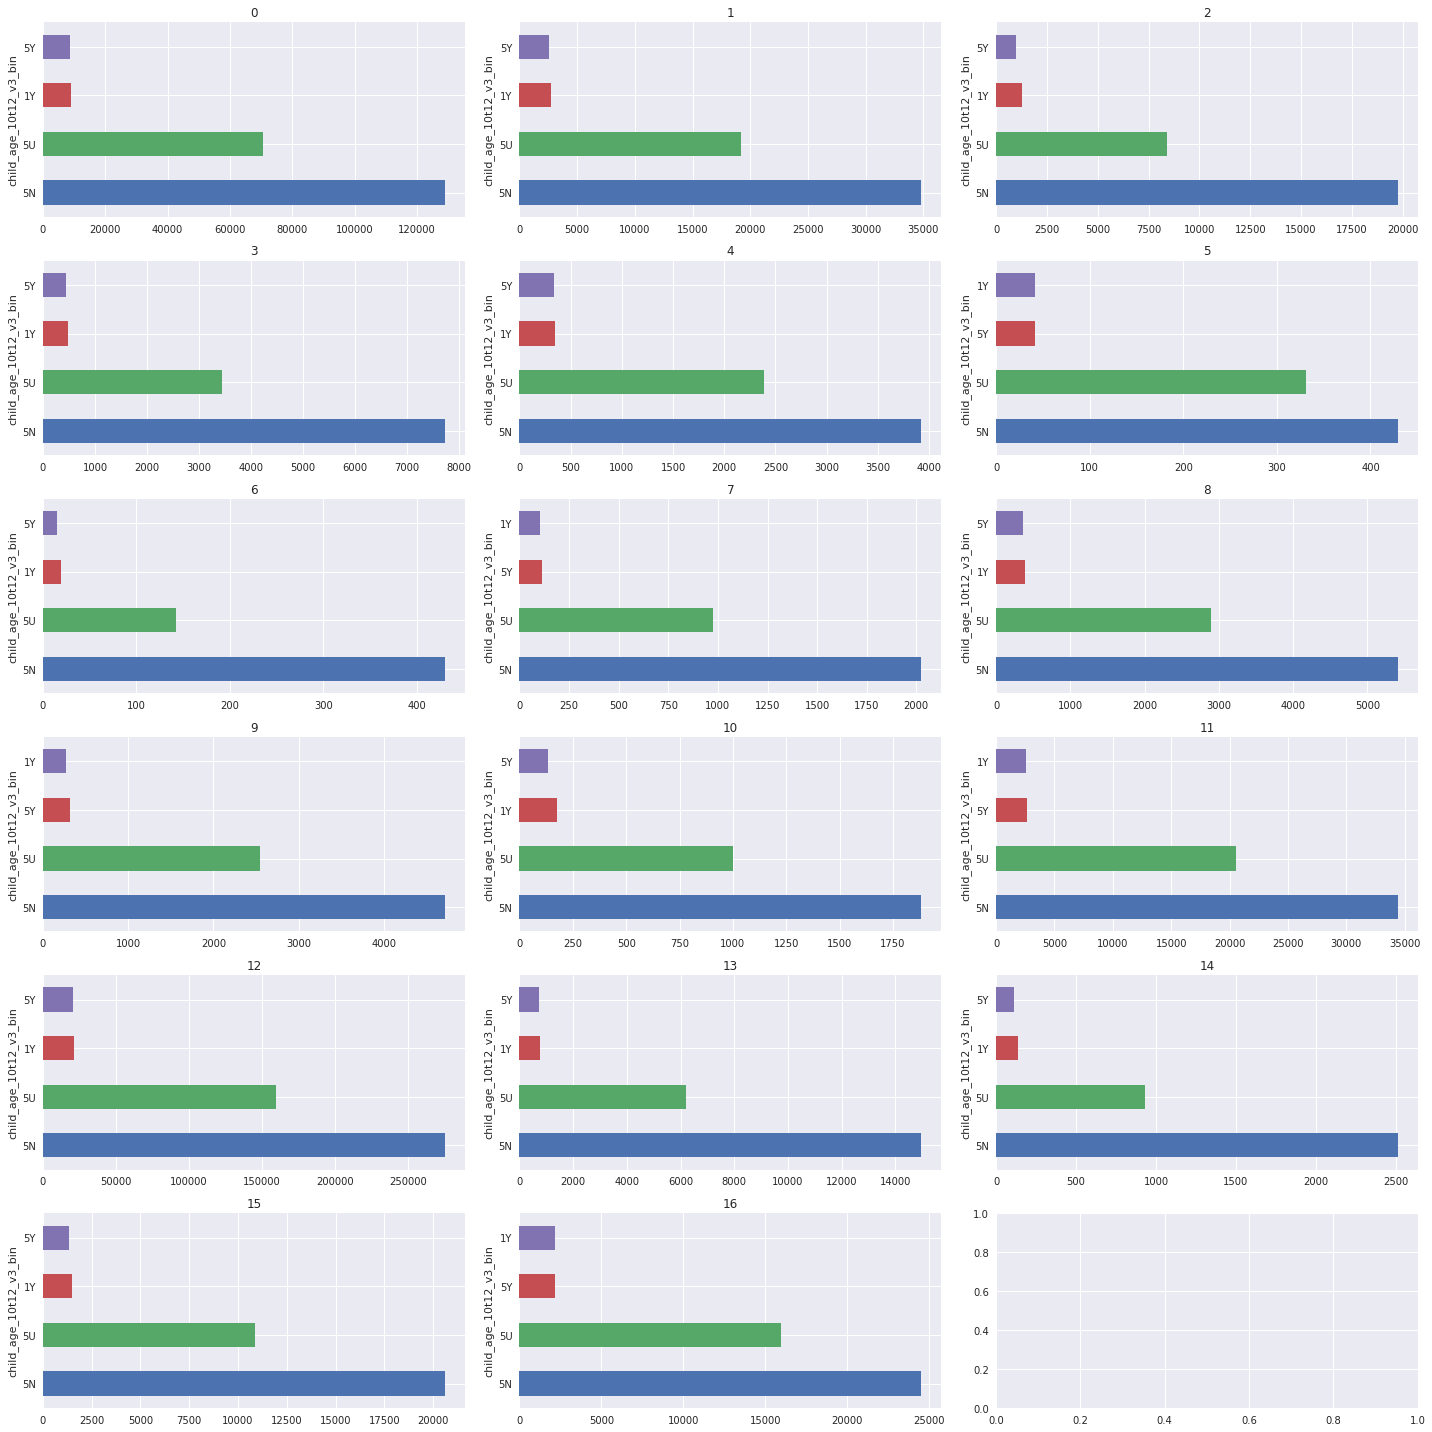

In [34]:
variable = "child_age_10t12_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_13t15_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

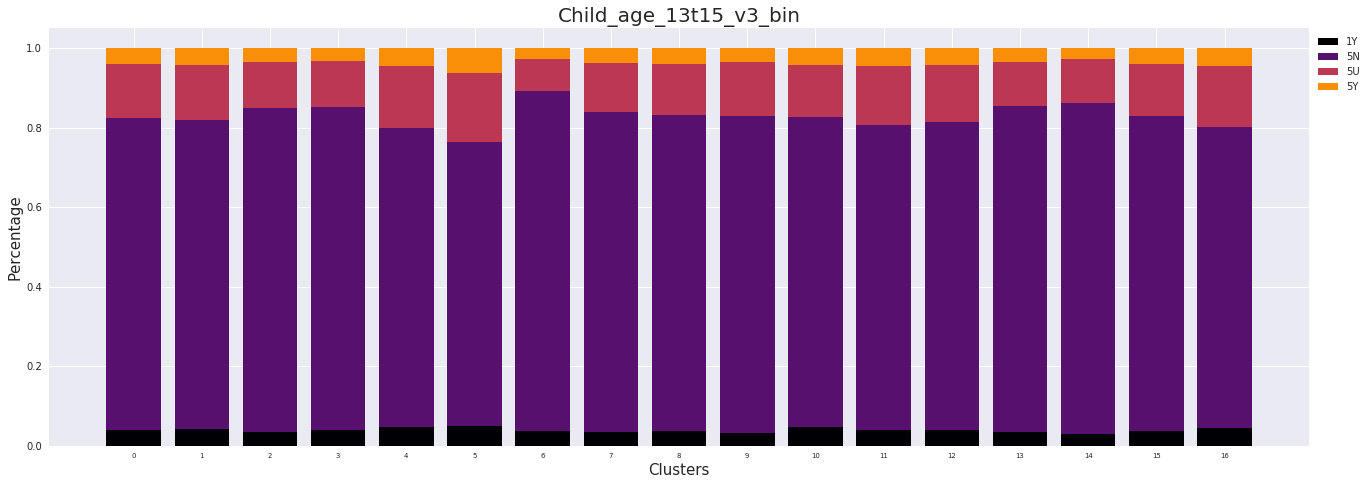

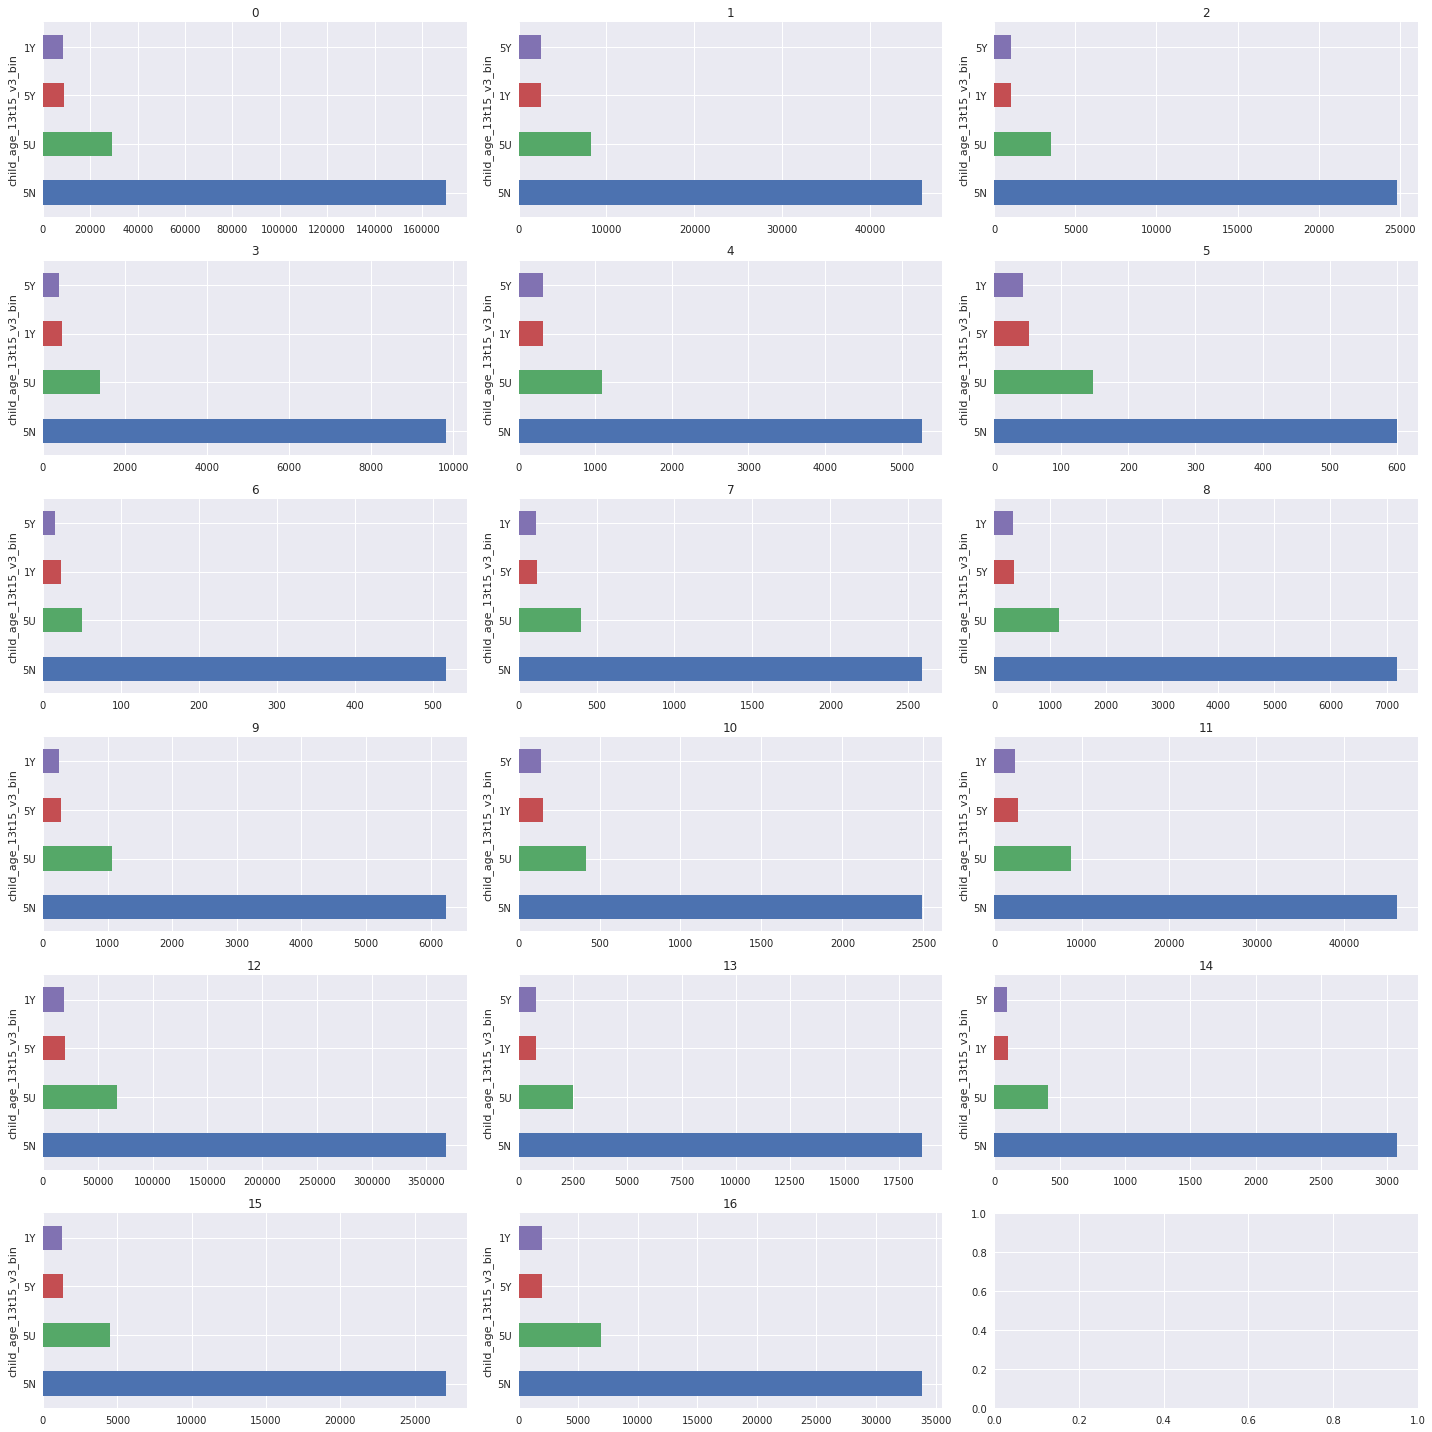

In [35]:
variable = "child_age_13t15_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> child_age_16t18_v3_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

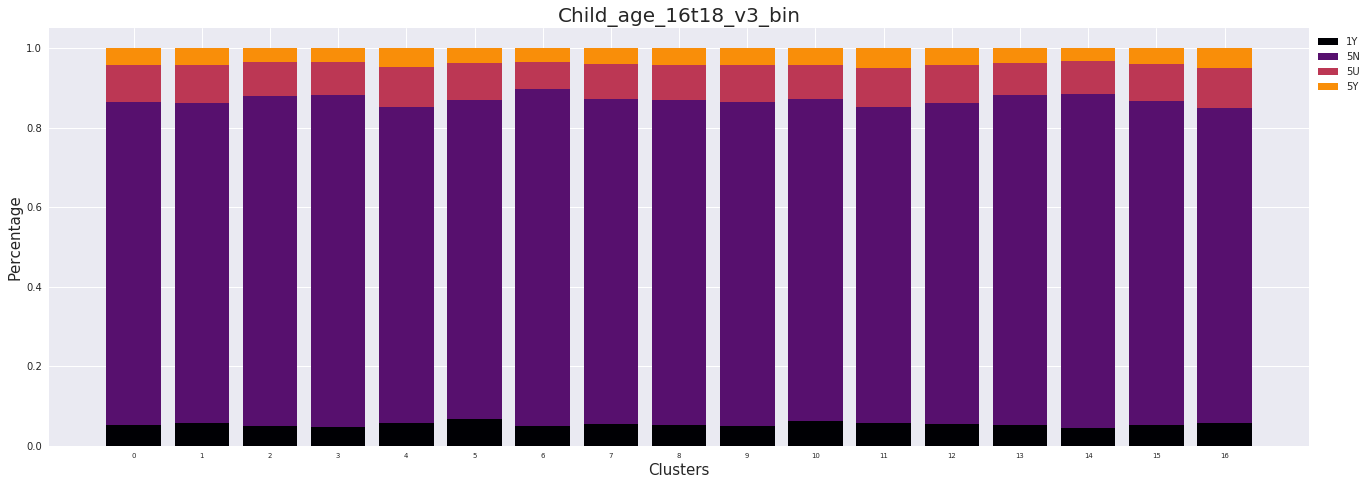

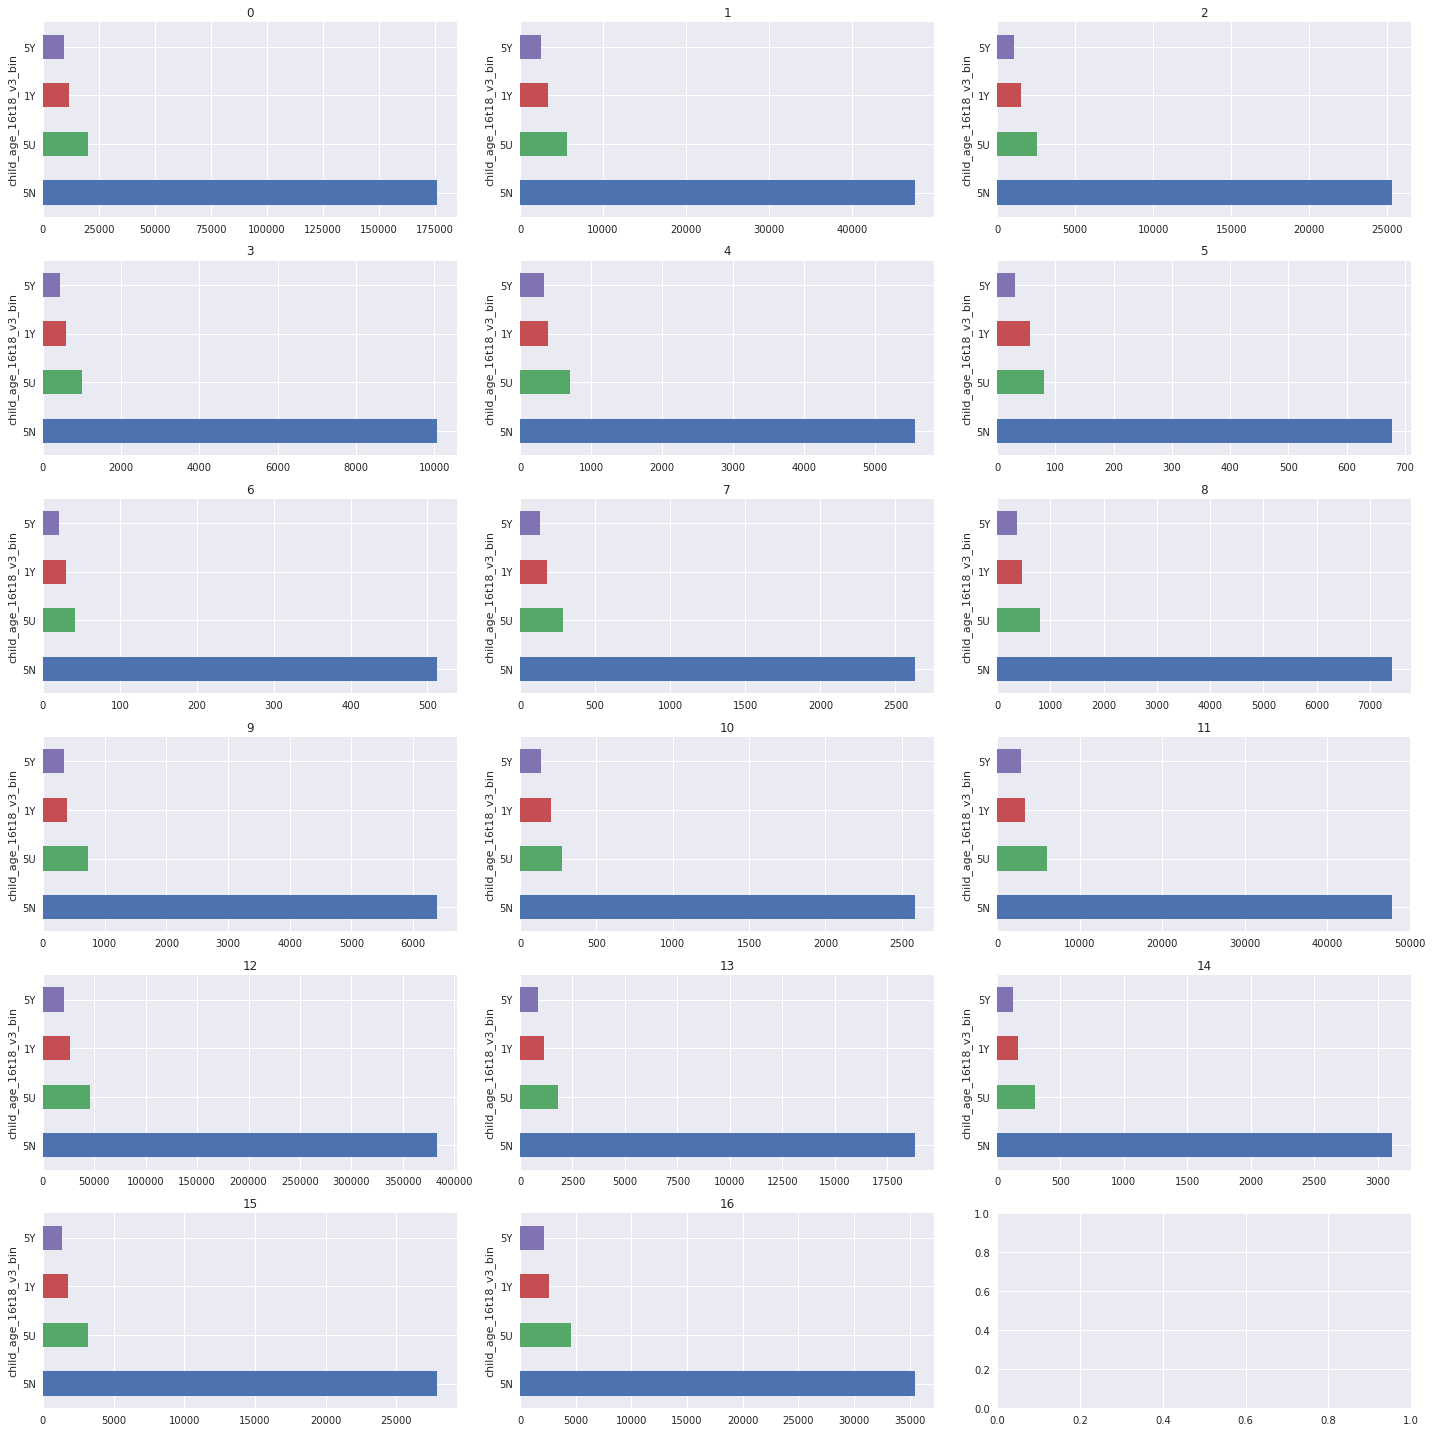

In [36]:
variable = "child_age_16t18_v3_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> cinemax: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

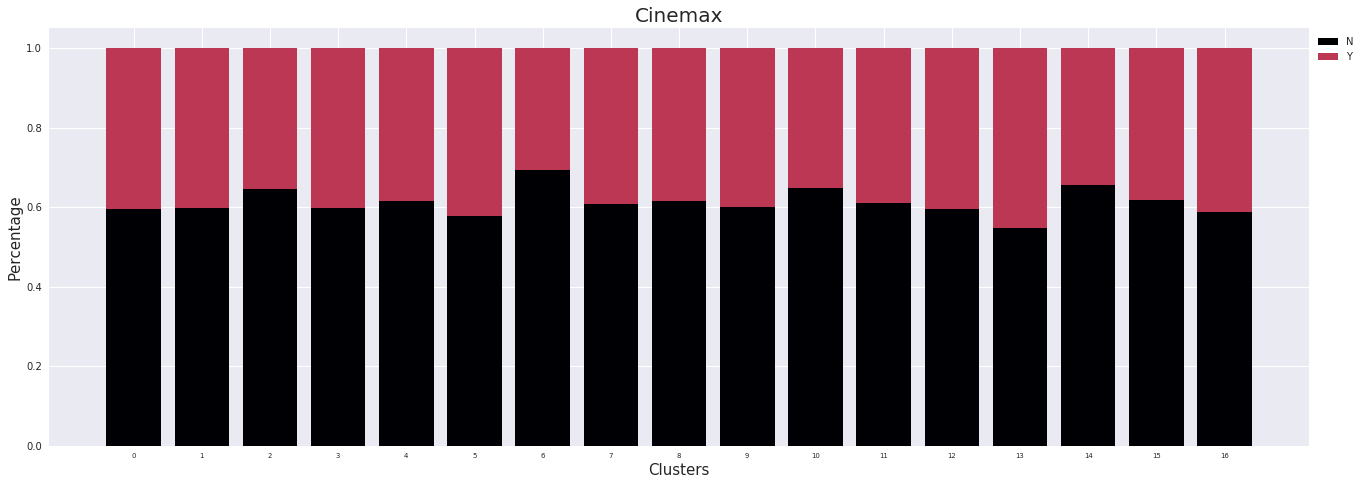

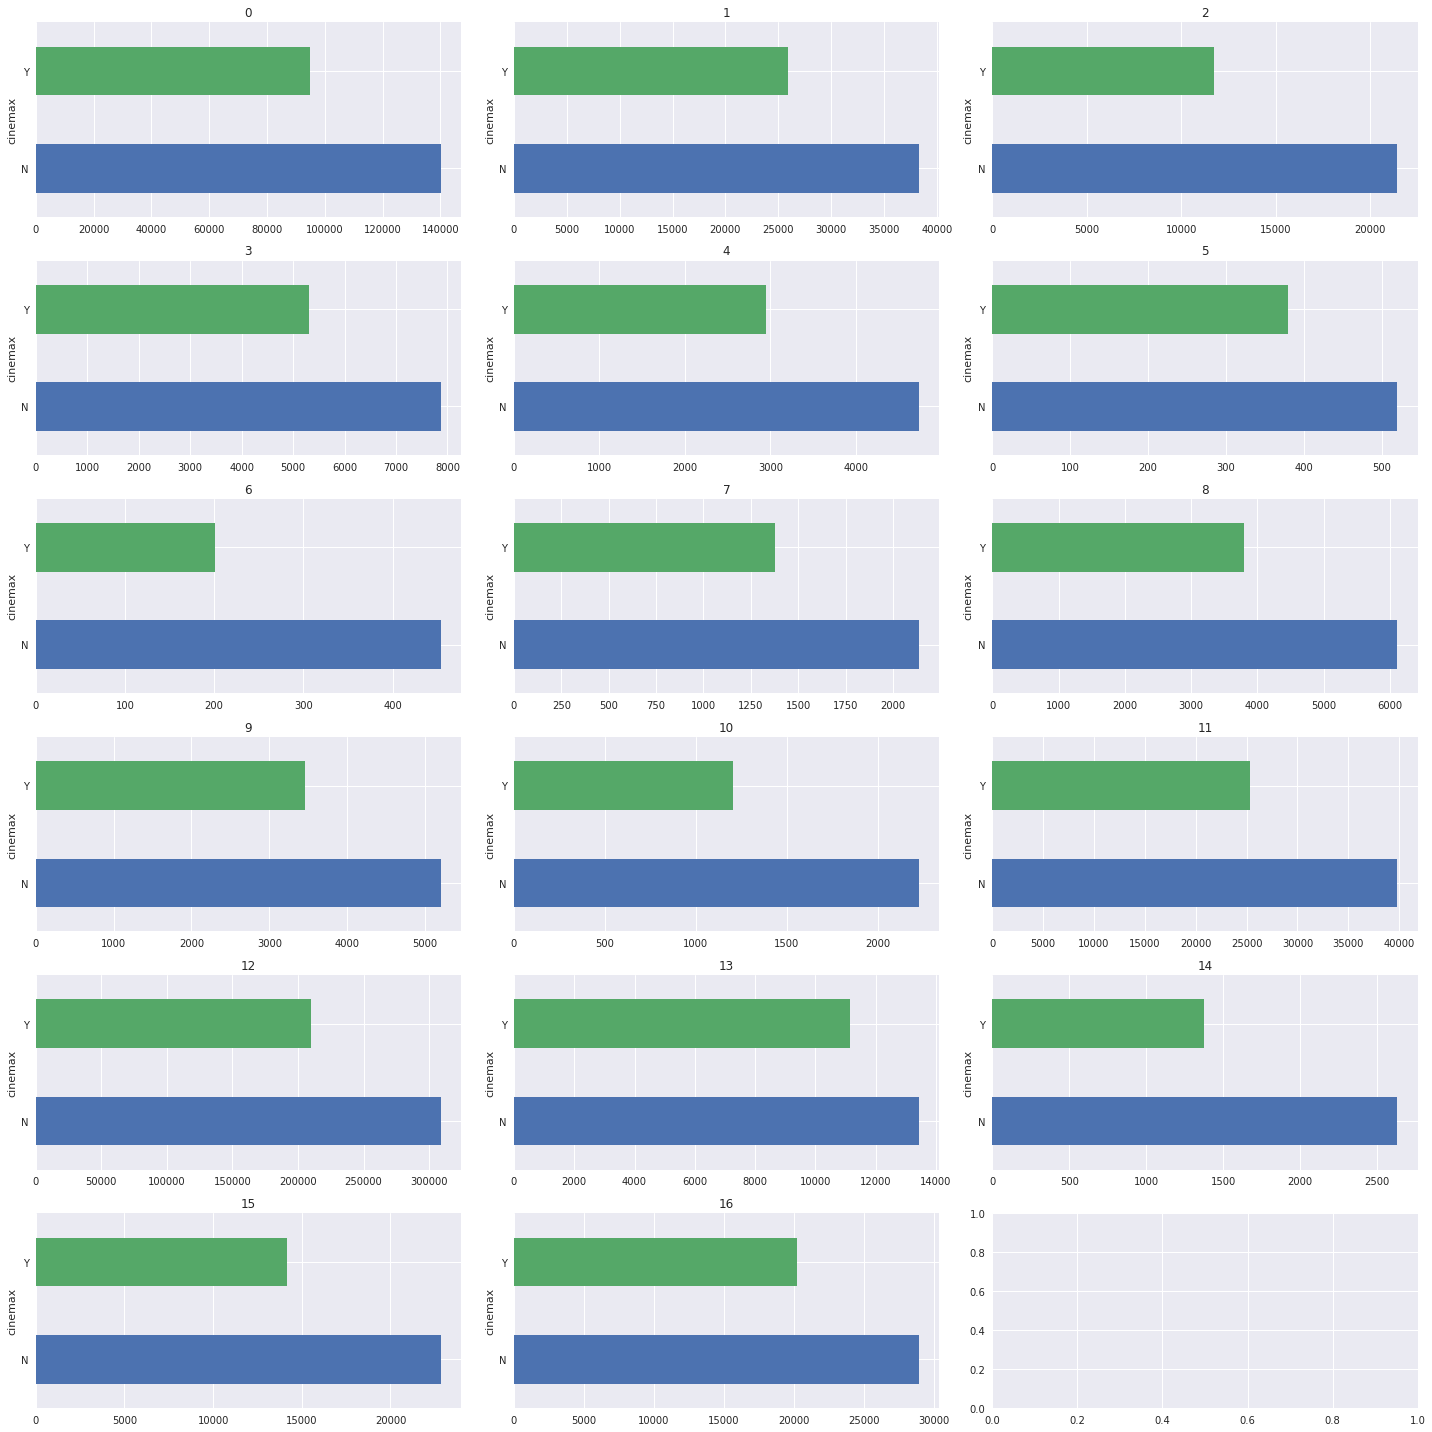

In [37]:
variable = "cinemax"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> dig_sports_tier: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

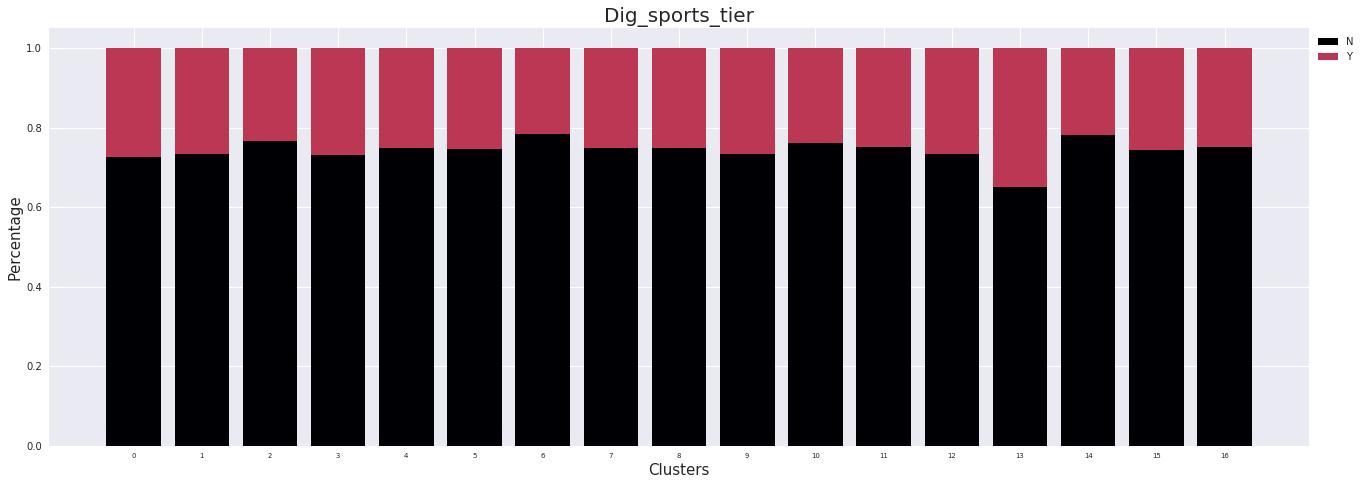

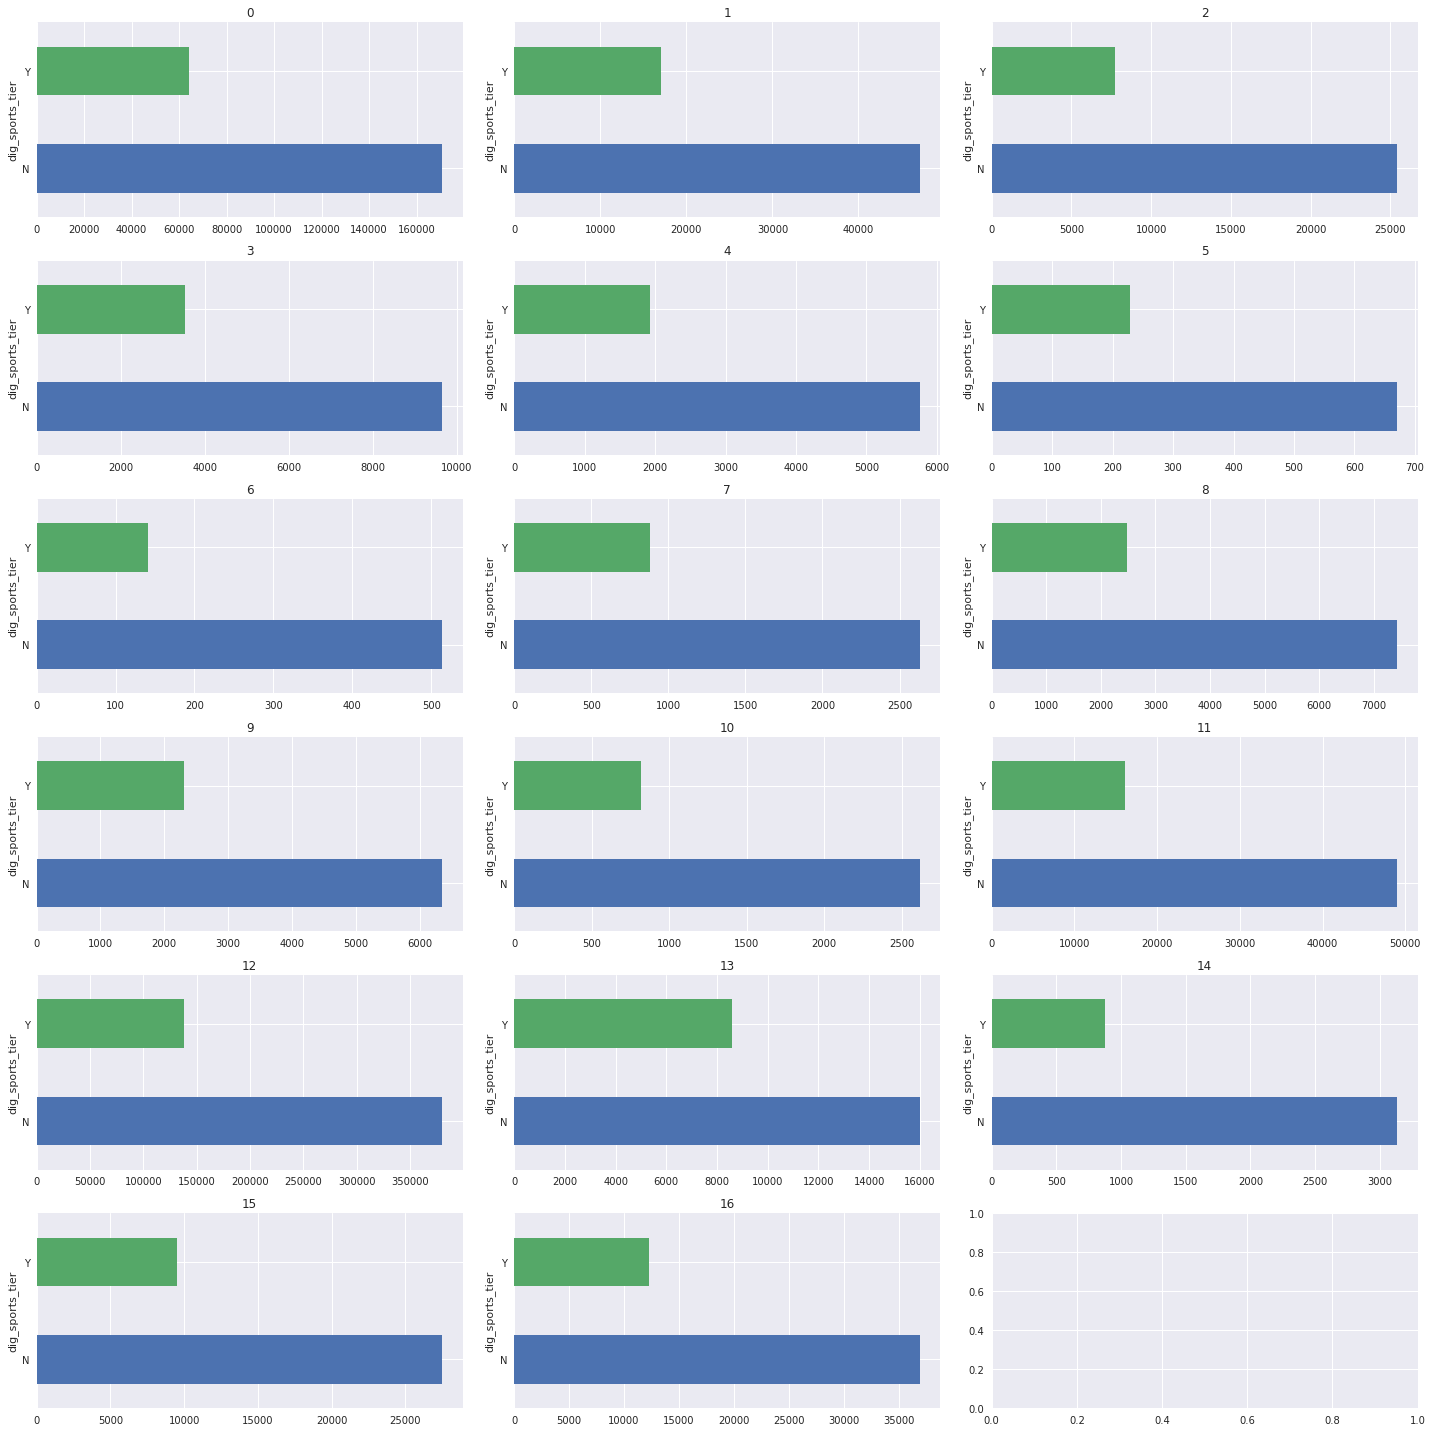

In [38]:
variable = "dig_sports_tier"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> digital_active_ind: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

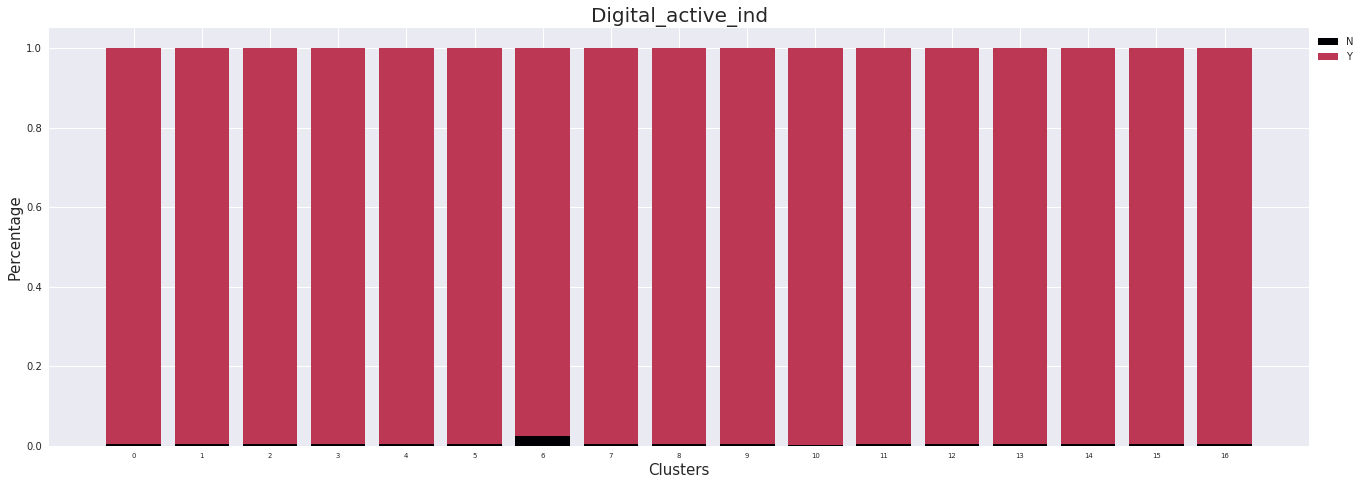

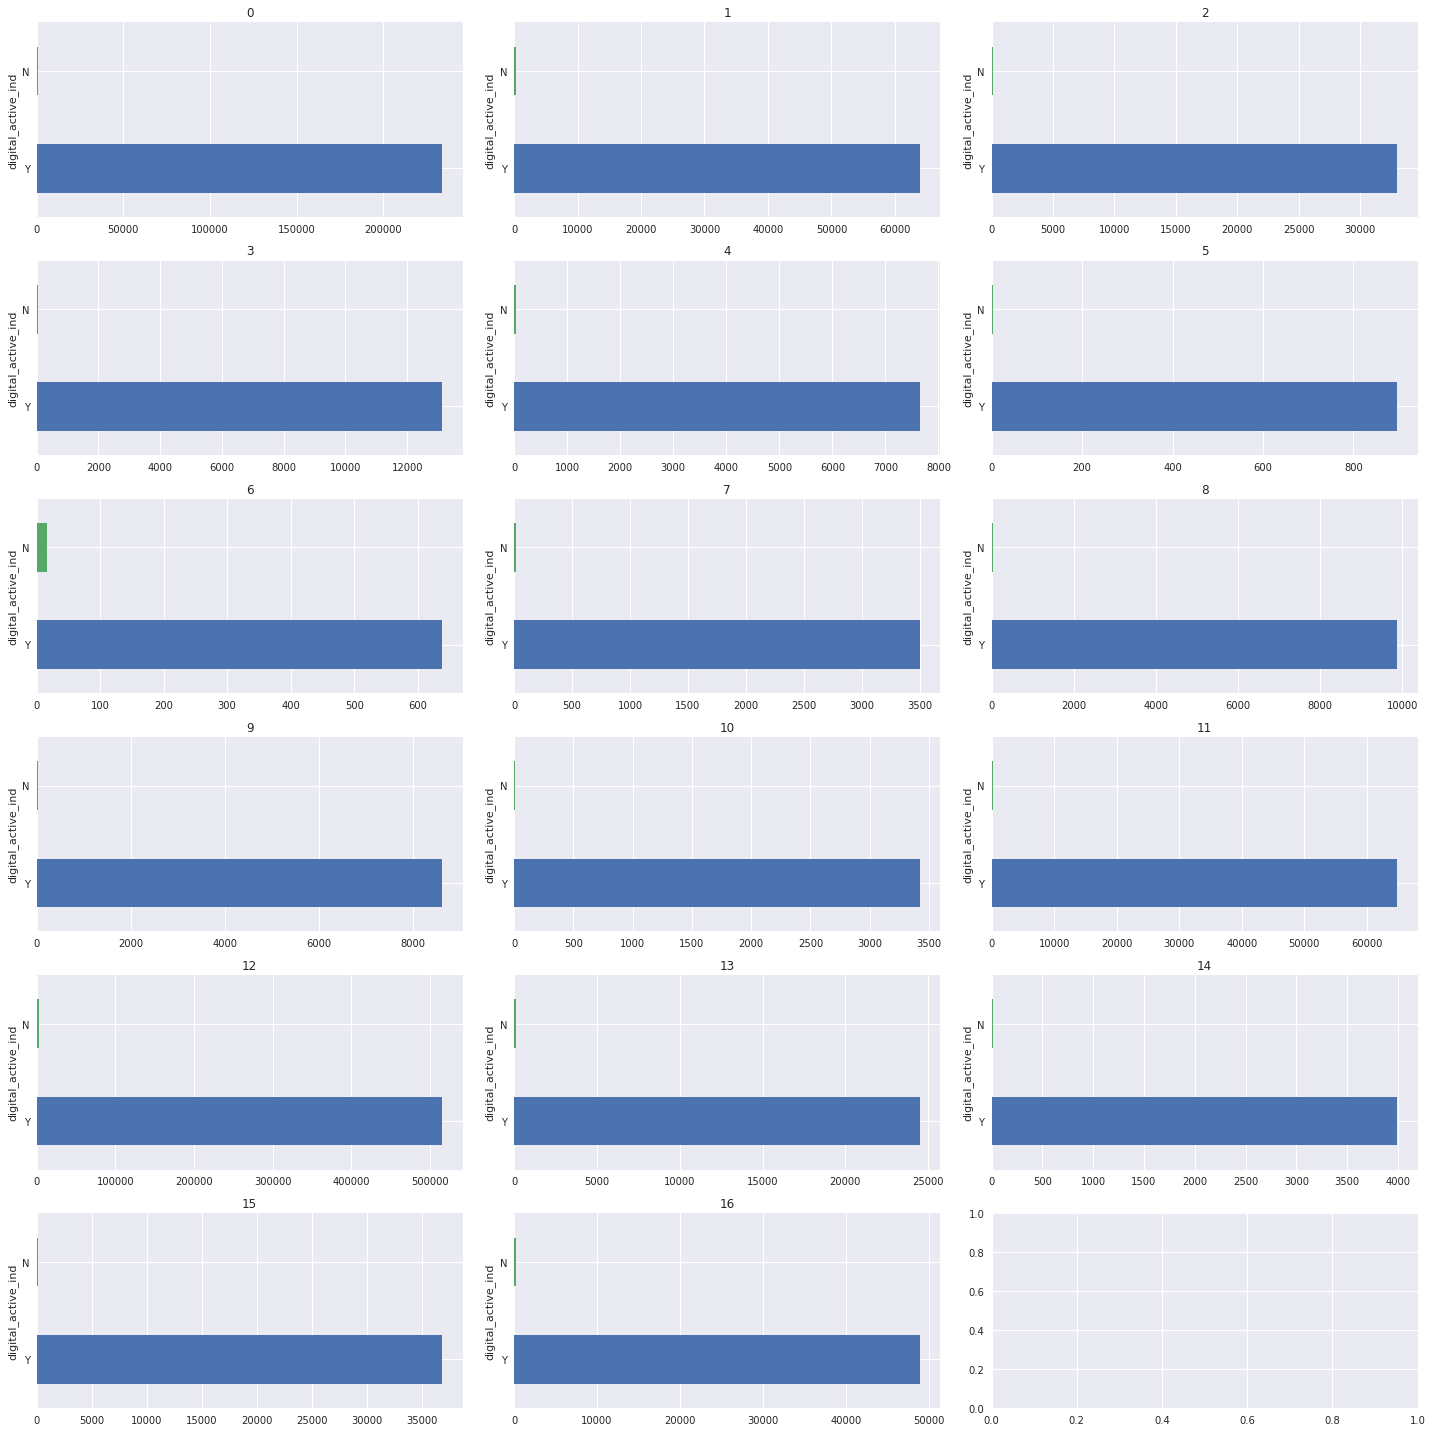

In [39]:
variable = "digital_active_ind"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> dsf_delivery_type: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

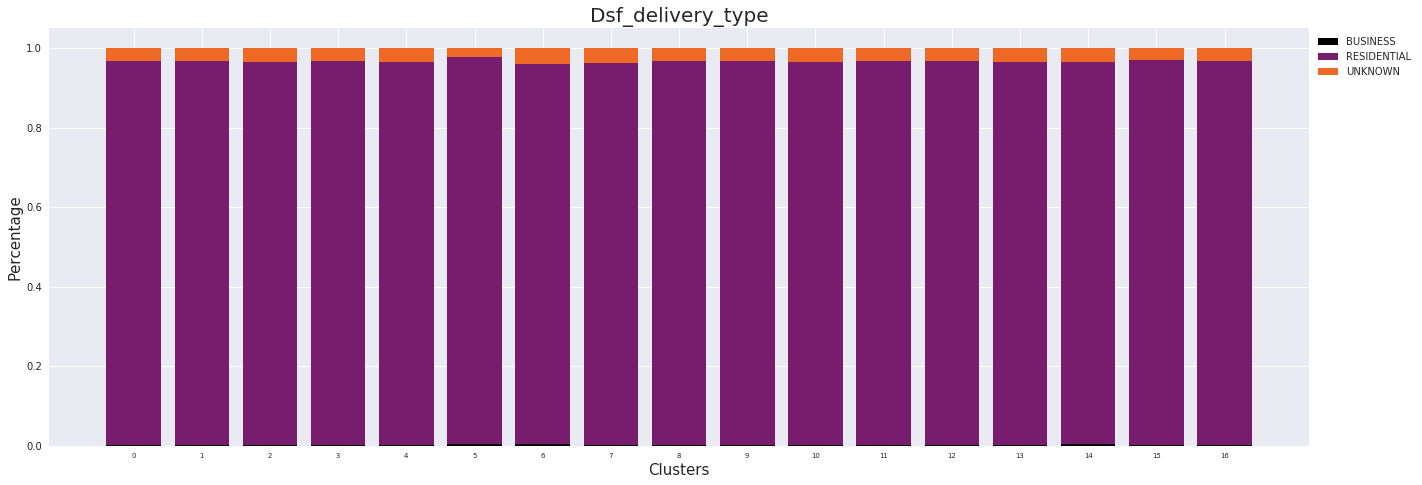

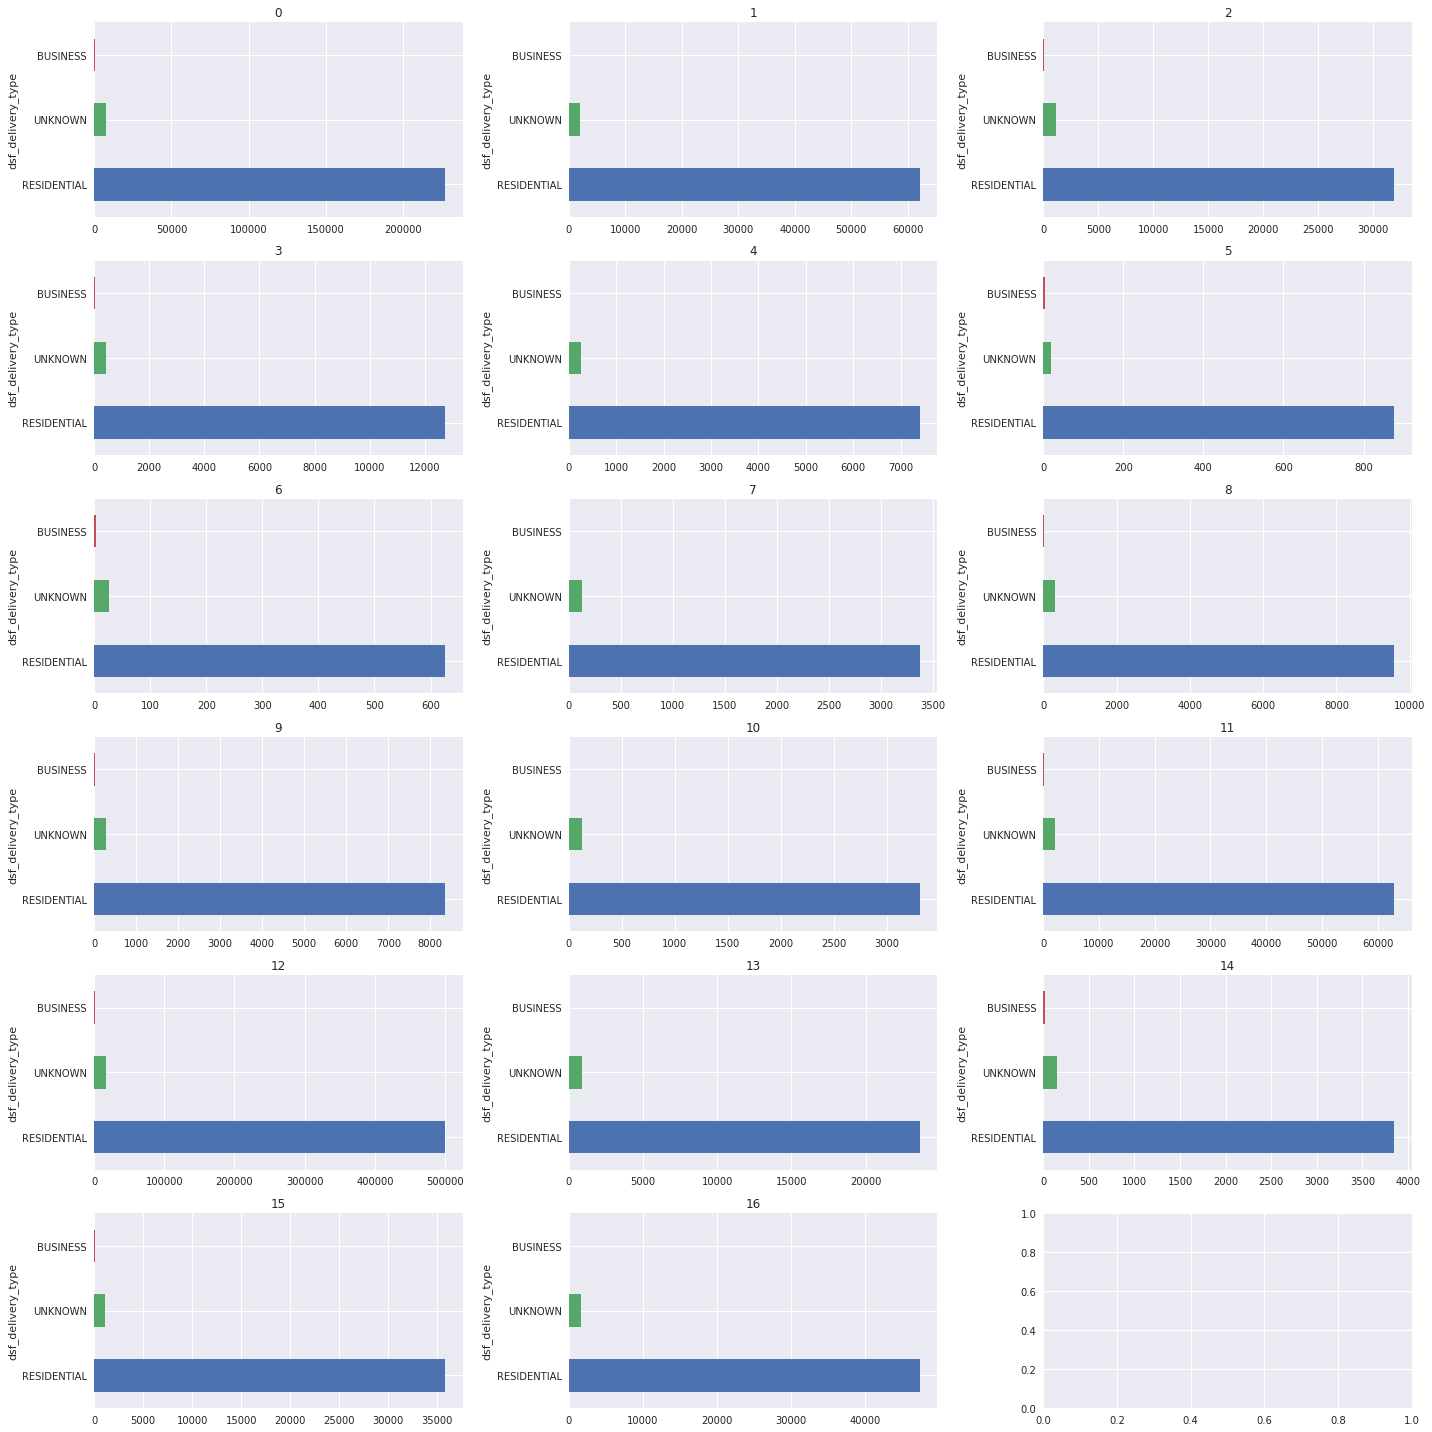

In [40]:
variable = "dsf_delivery_type"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> eb_lui_interest_clothing: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

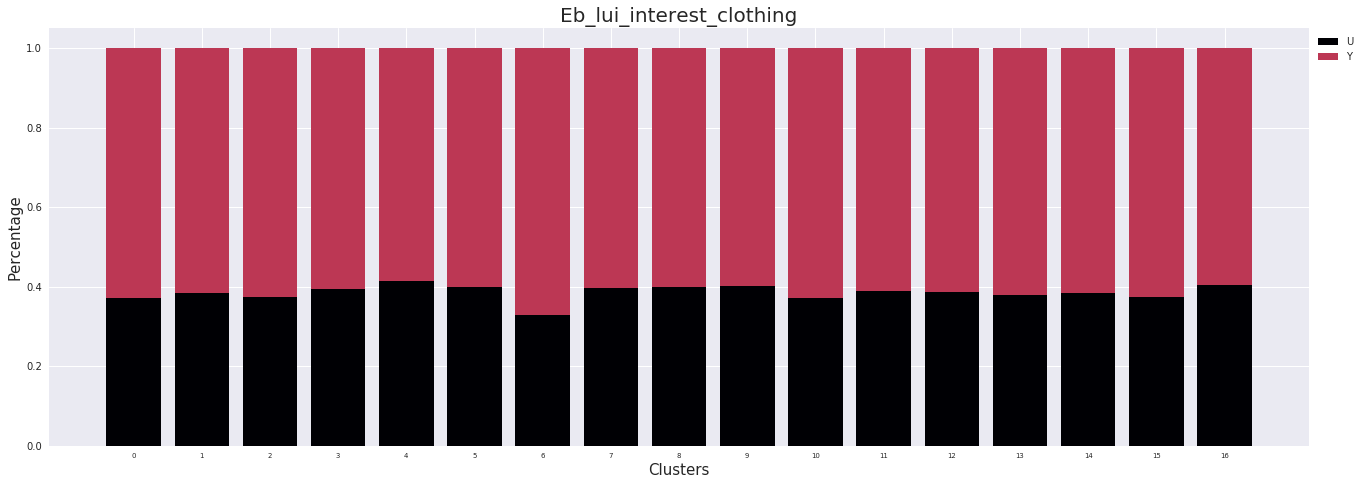

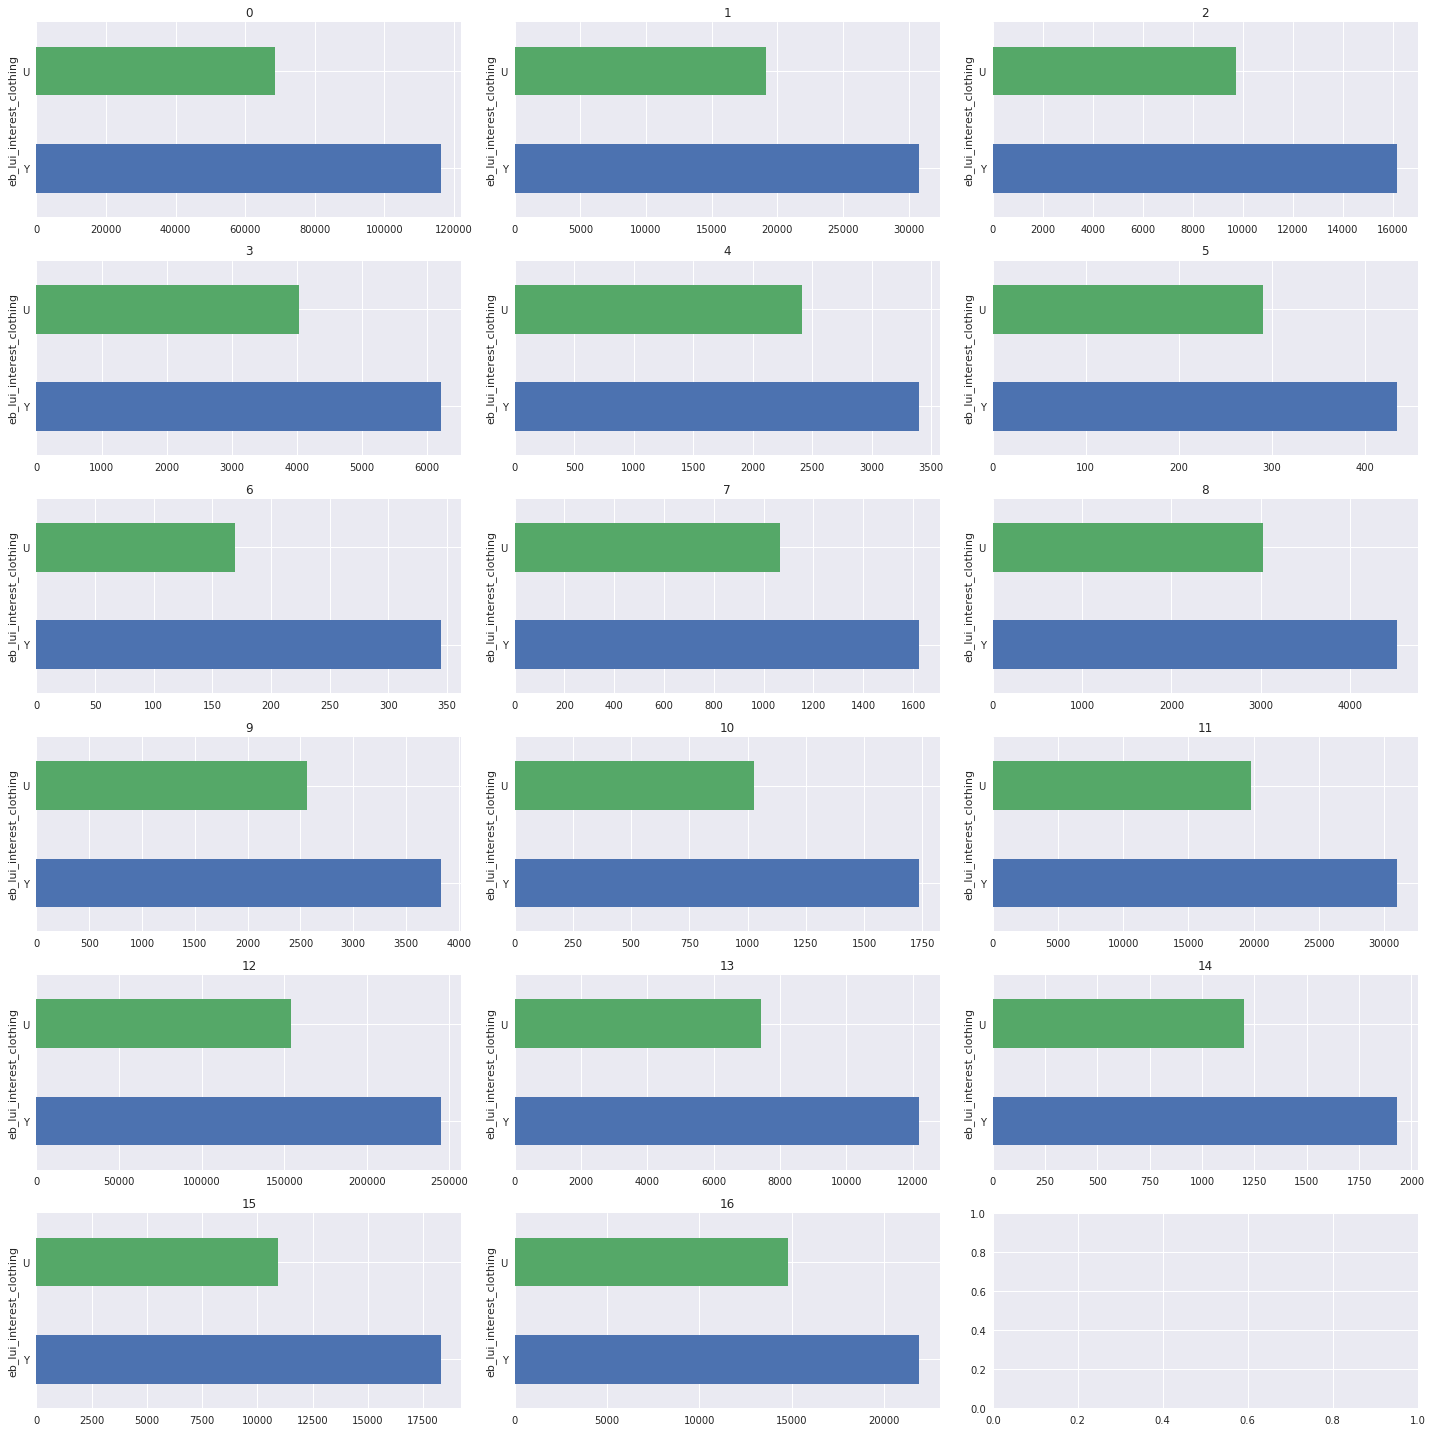

In [41]:
variable = "eb_lui_interest_clothing"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> eb_lui_hi_tech_owner: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

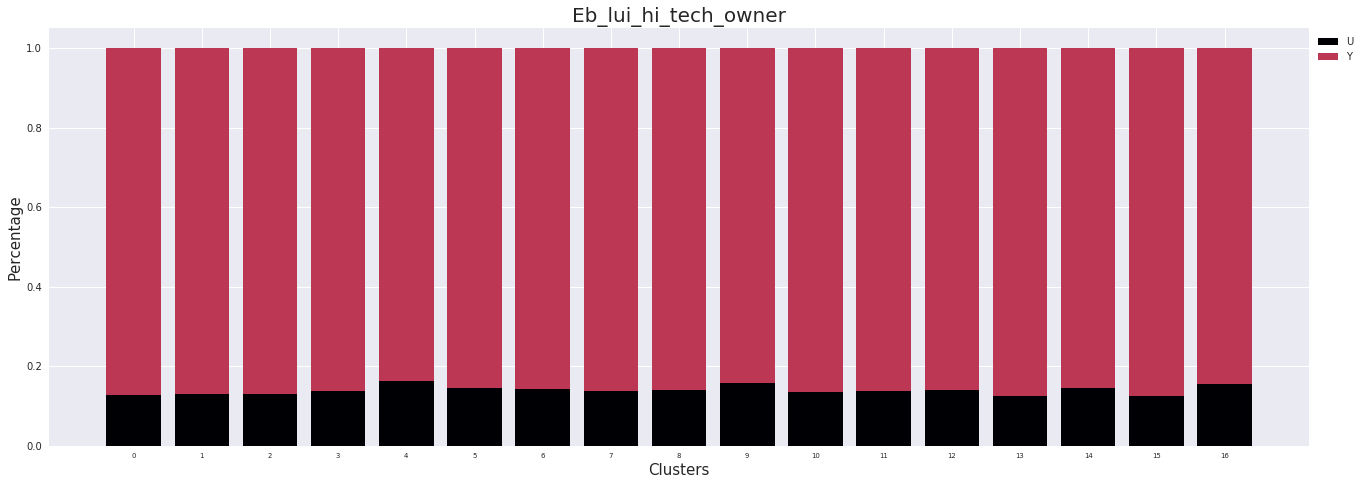

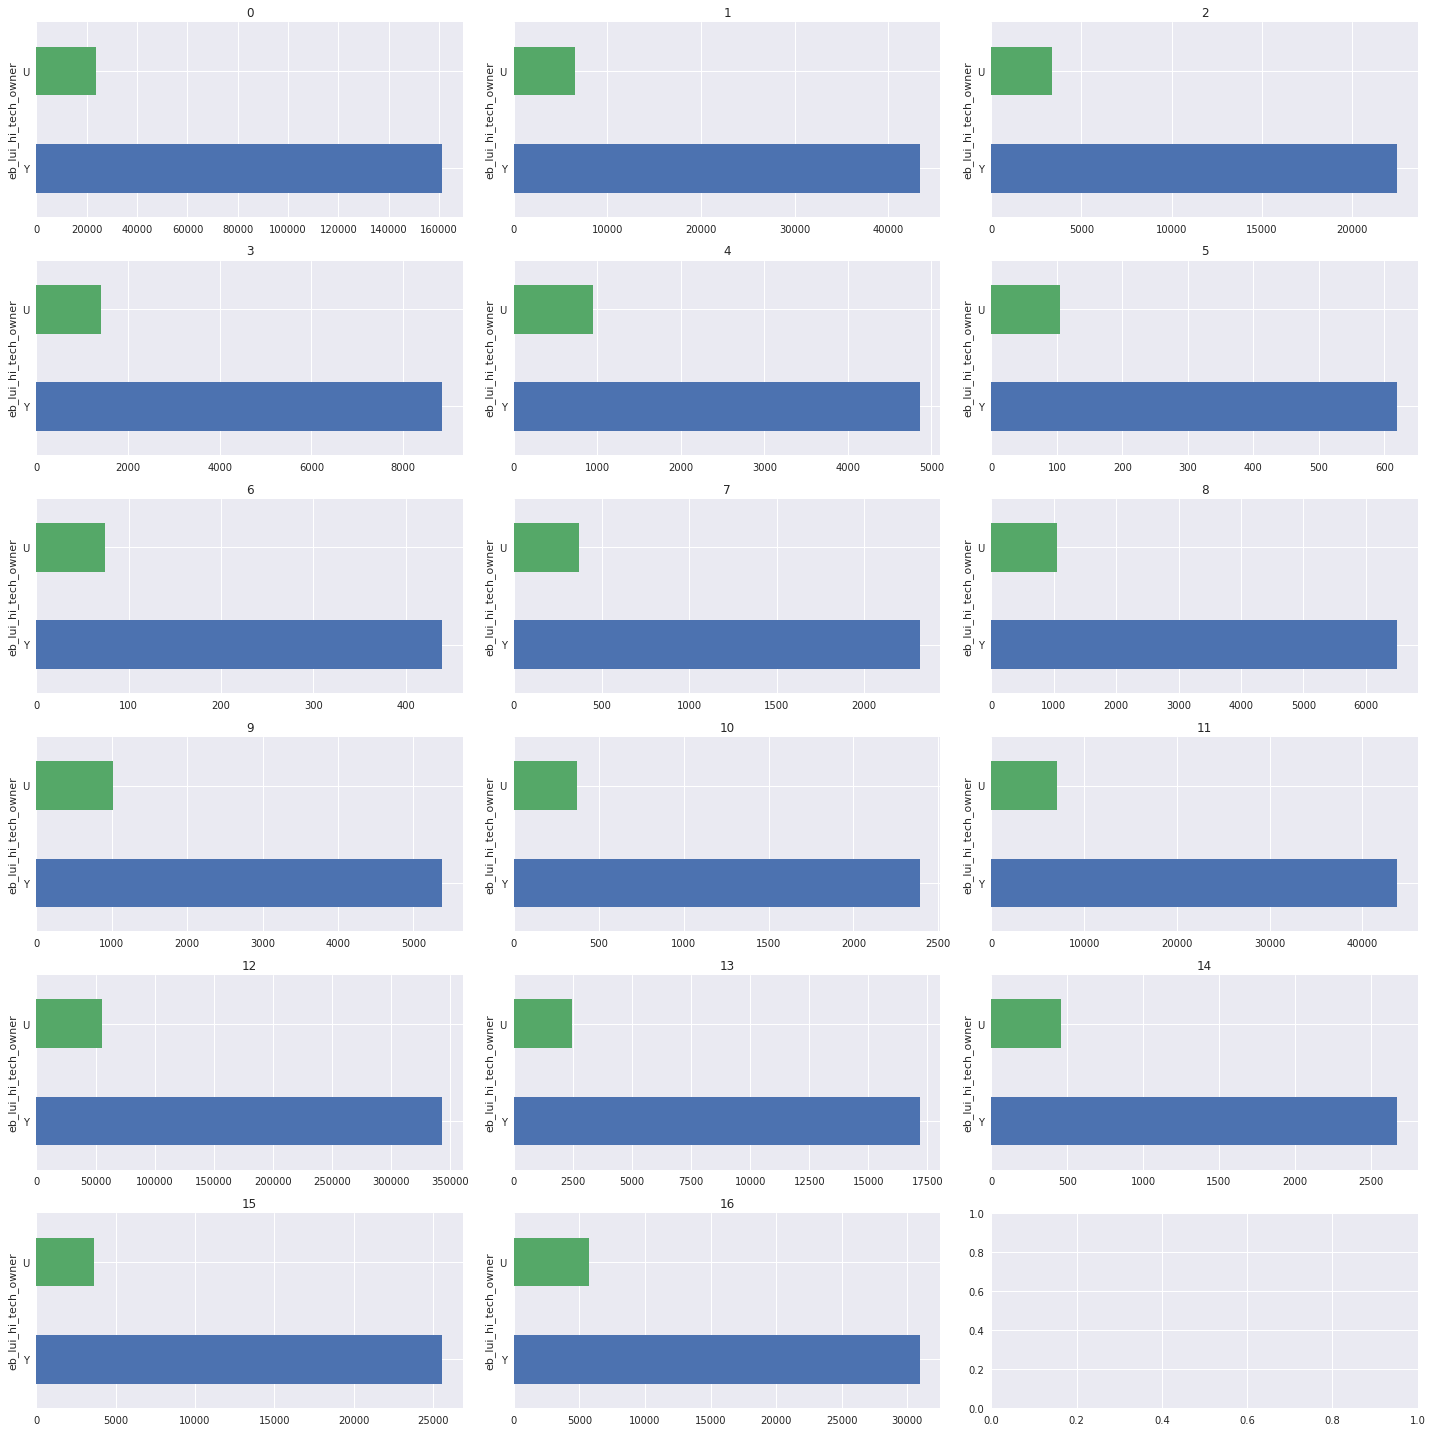

In [42]:
variable = "eb_lui_hi_tech_owner"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> eb_lui_home_enter_tv_vid: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

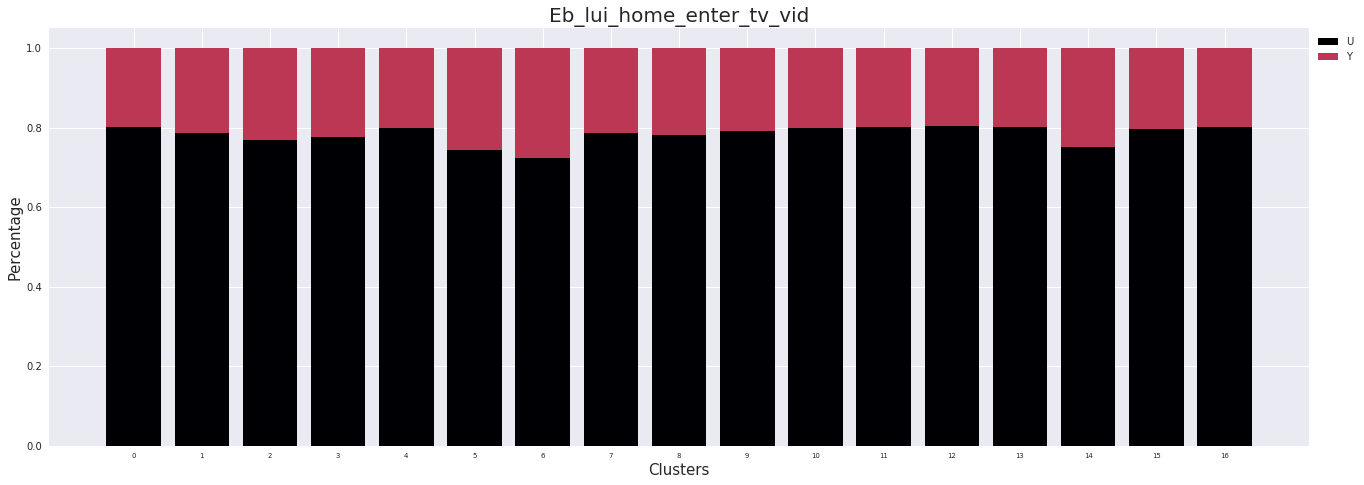

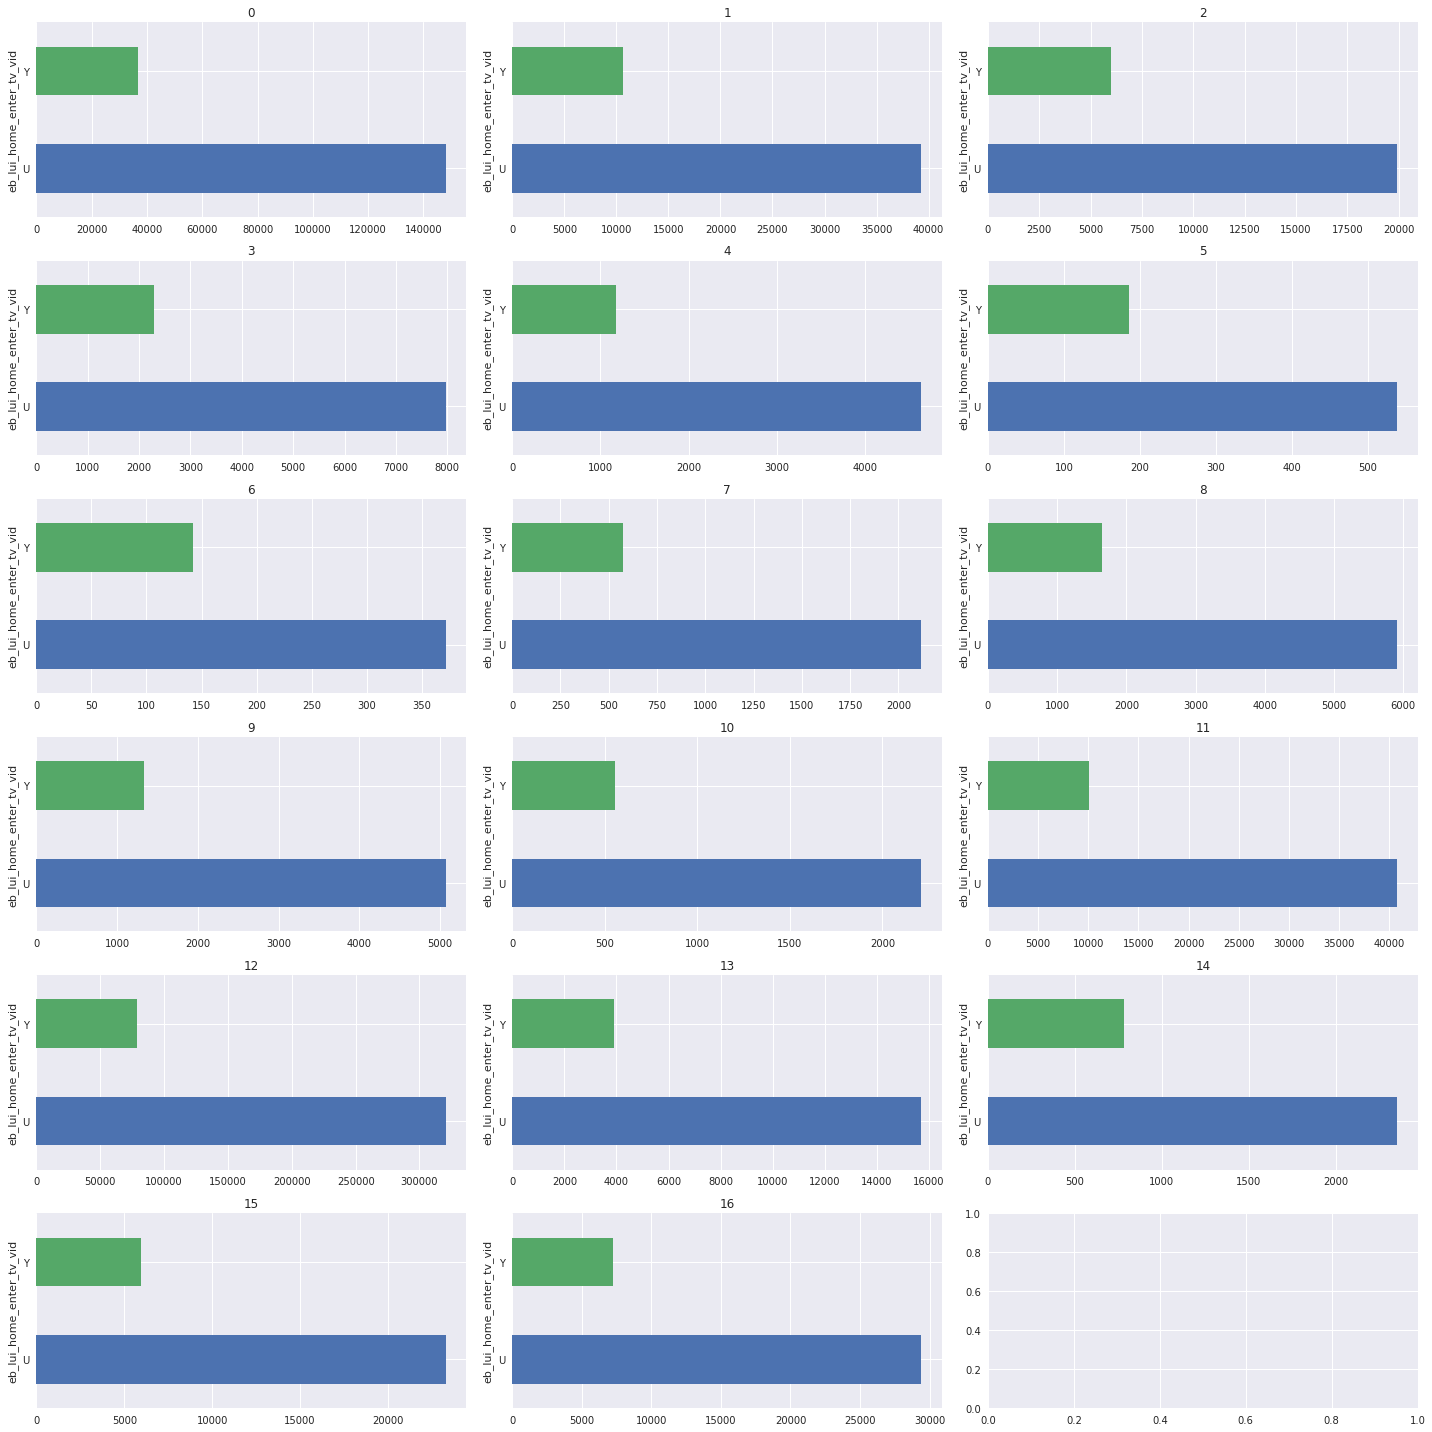

In [43]:
variable = "eb_lui_home_enter_tv_vid"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> eb_lui_mob_music_video: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

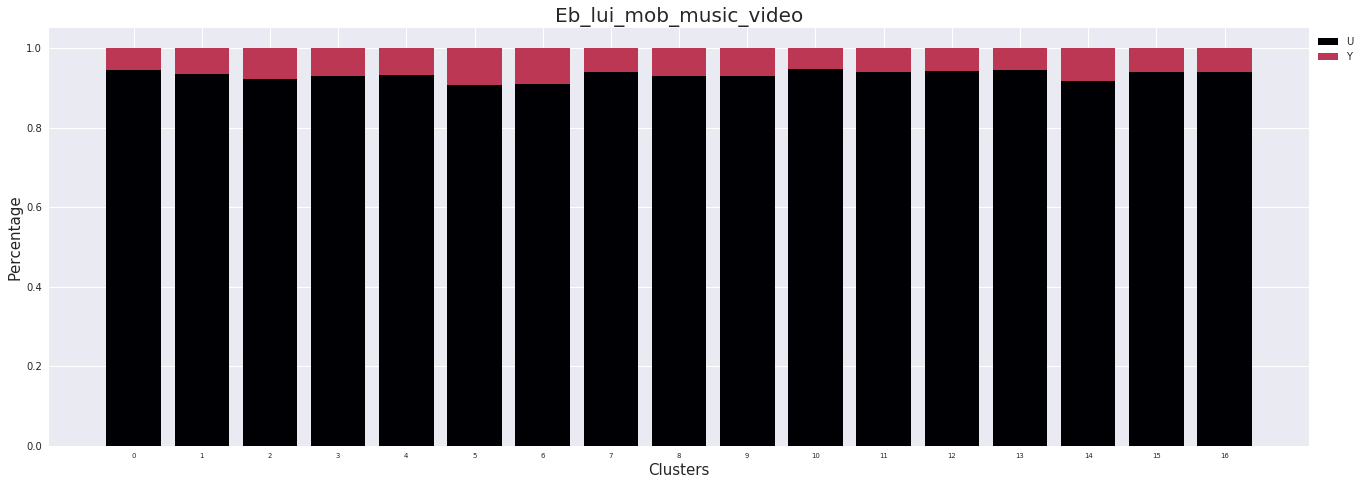

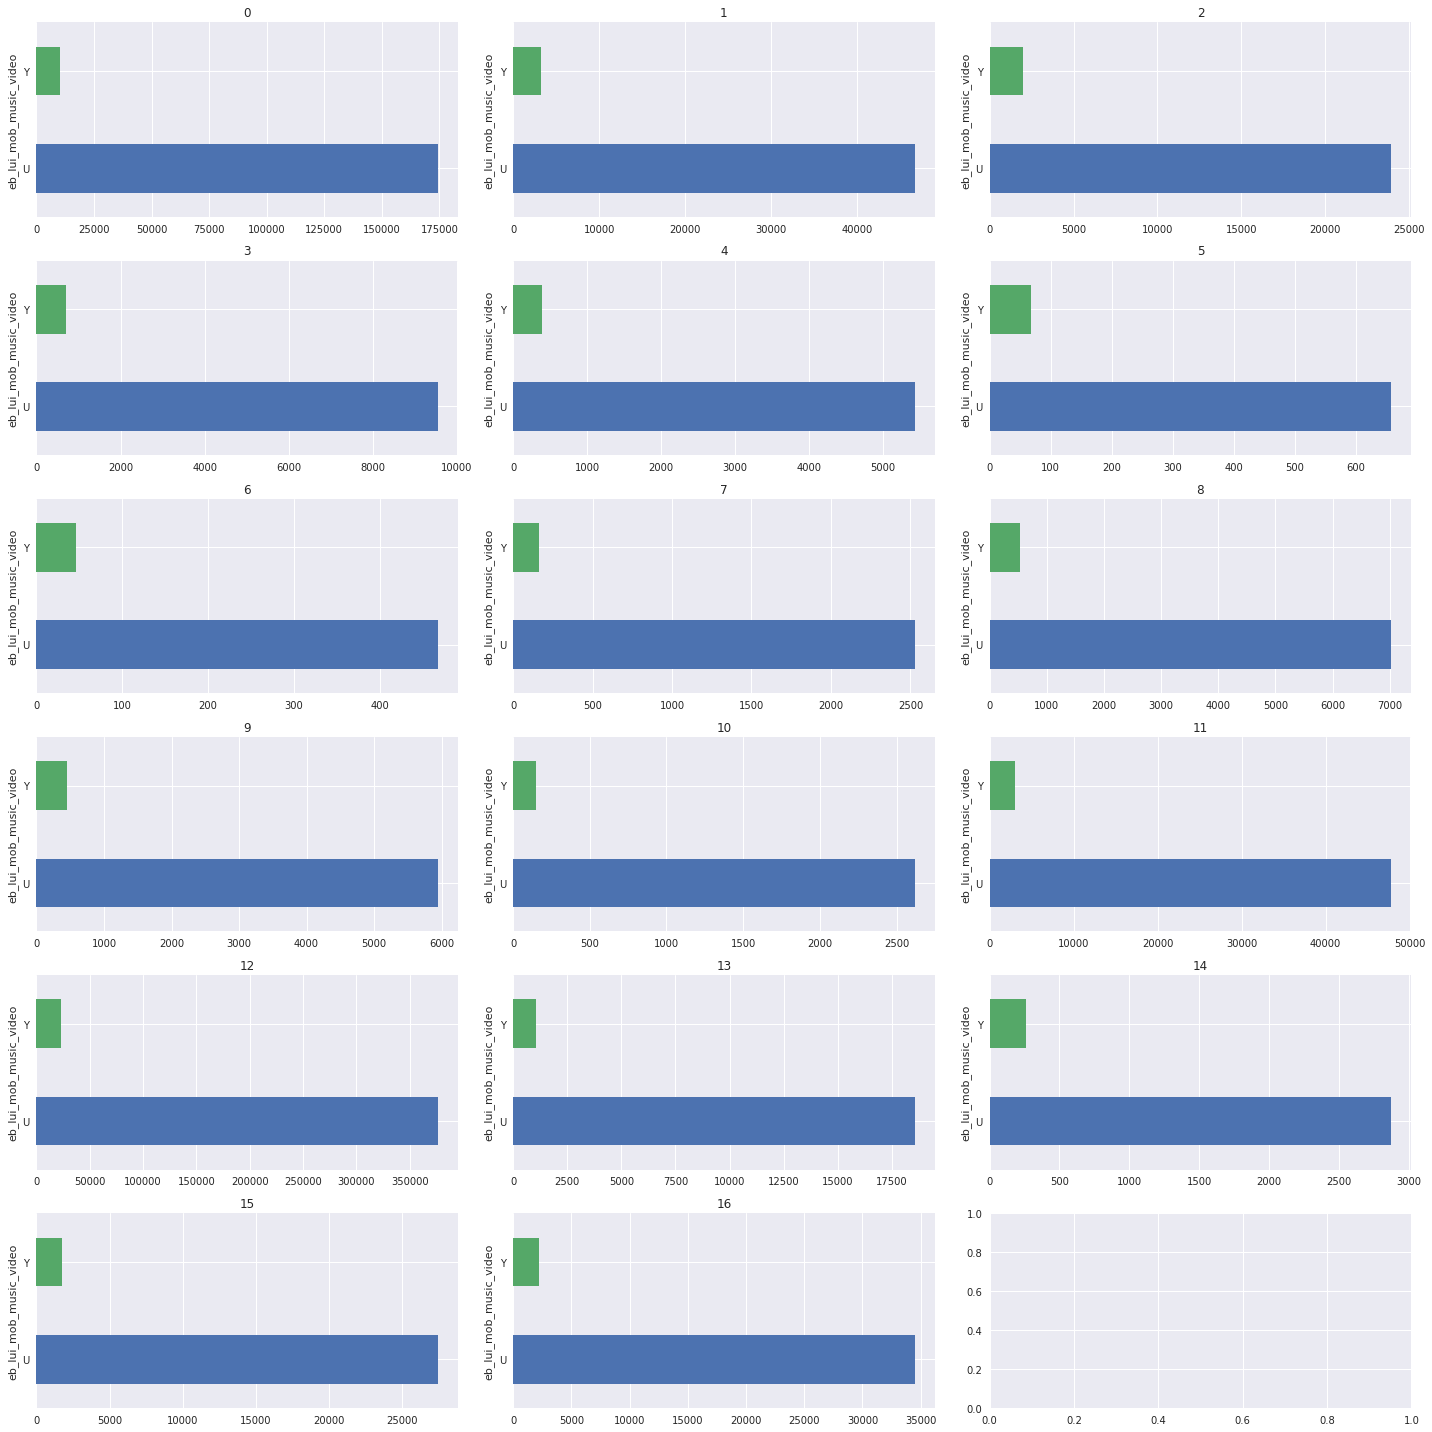

In [44]:
variable = "eb_lui_mob_music_video"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> estimated_income_v4_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

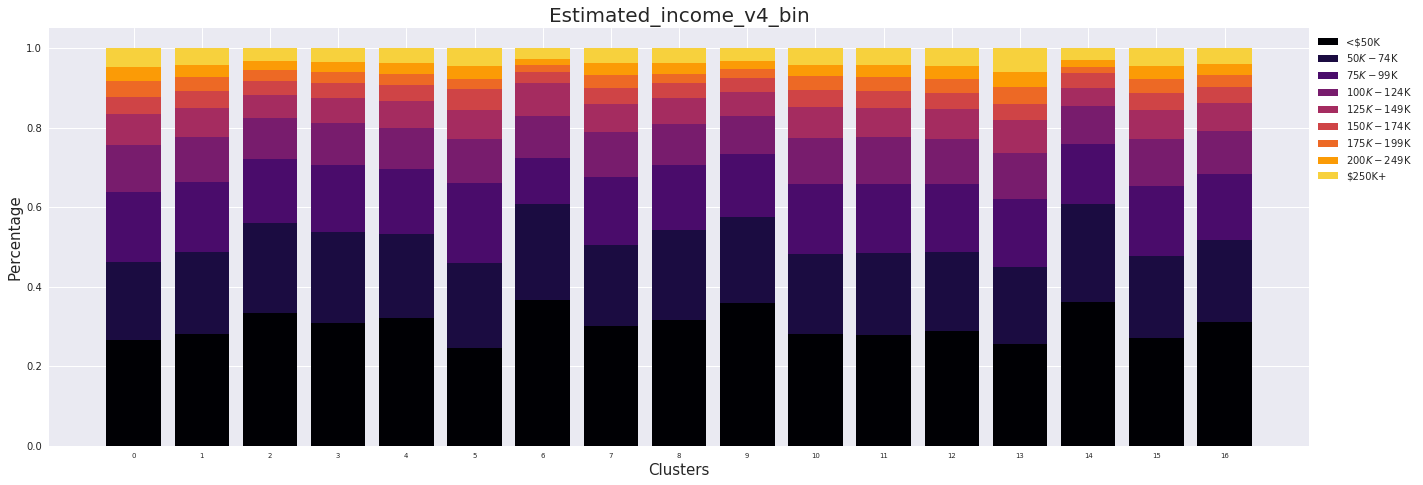

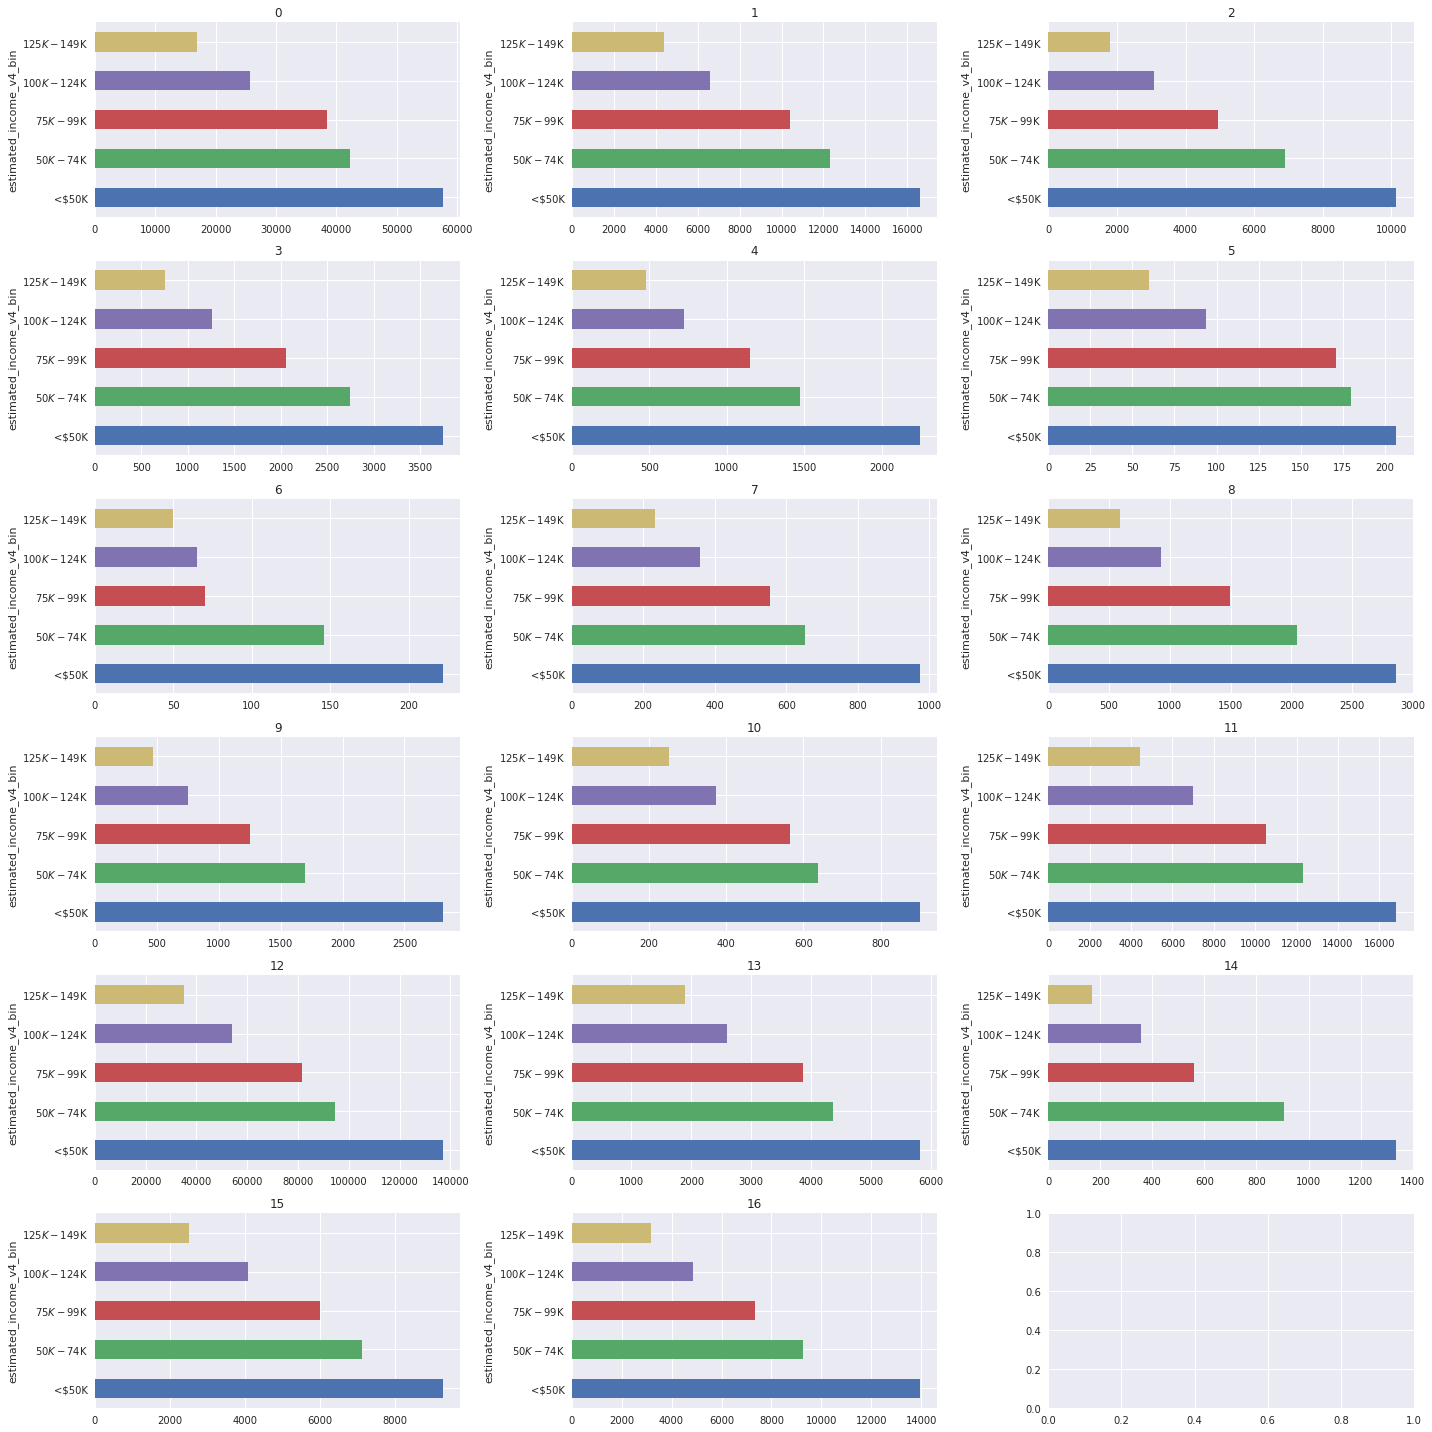

In [45]:
variable = "estimated_income_v4_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = ['<$50K','$50K - $74K', '$75K - $99K', '$100K - $124K', '$125K - $149K', '$150K - $174K', '$175K - $199K', '$200K - $249K', '$250K+']
bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()




<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> et_country_code: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

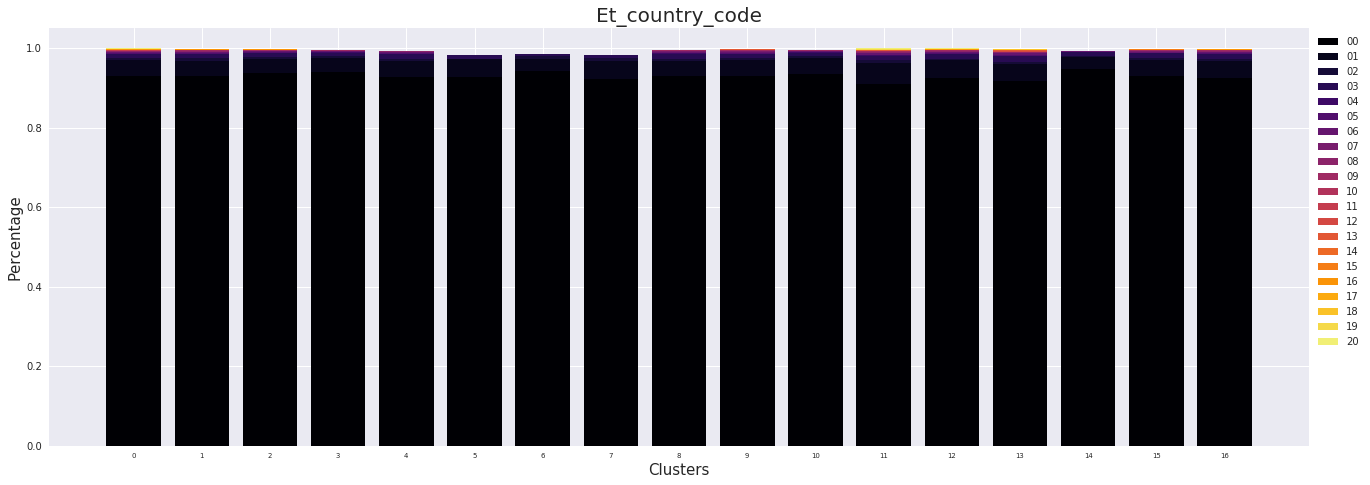

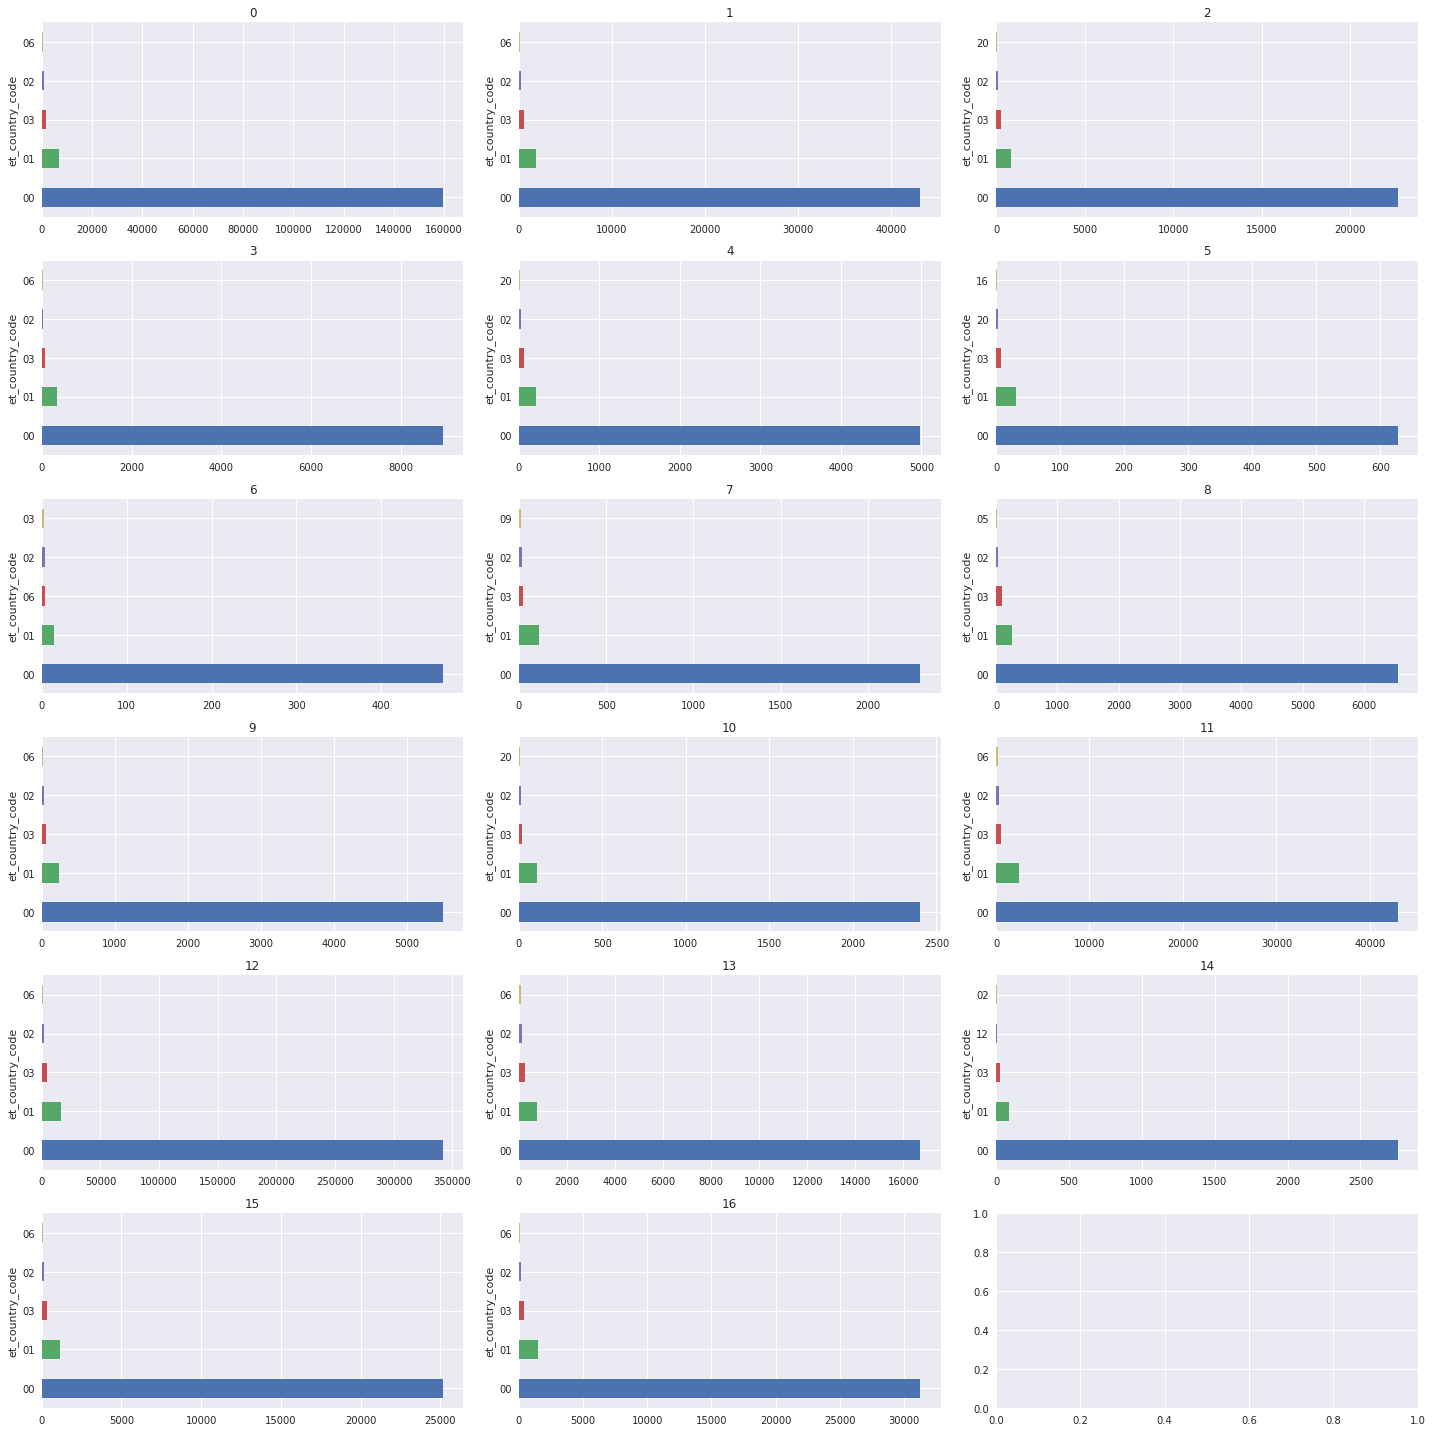

In [46]:
variable = "et_country_code"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> et_country_code_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

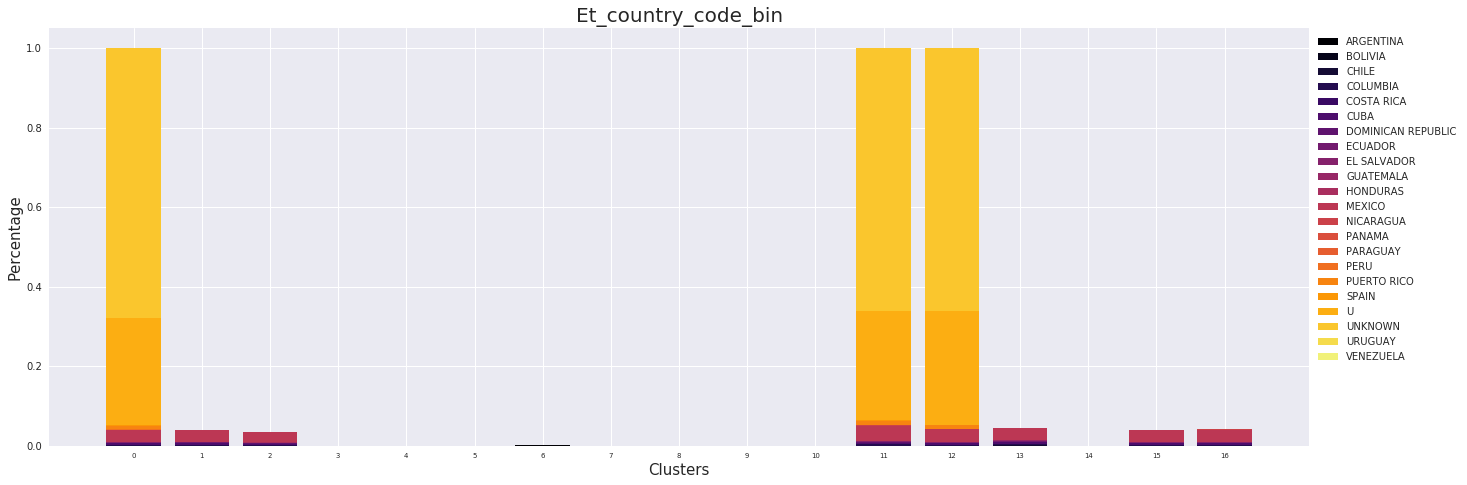

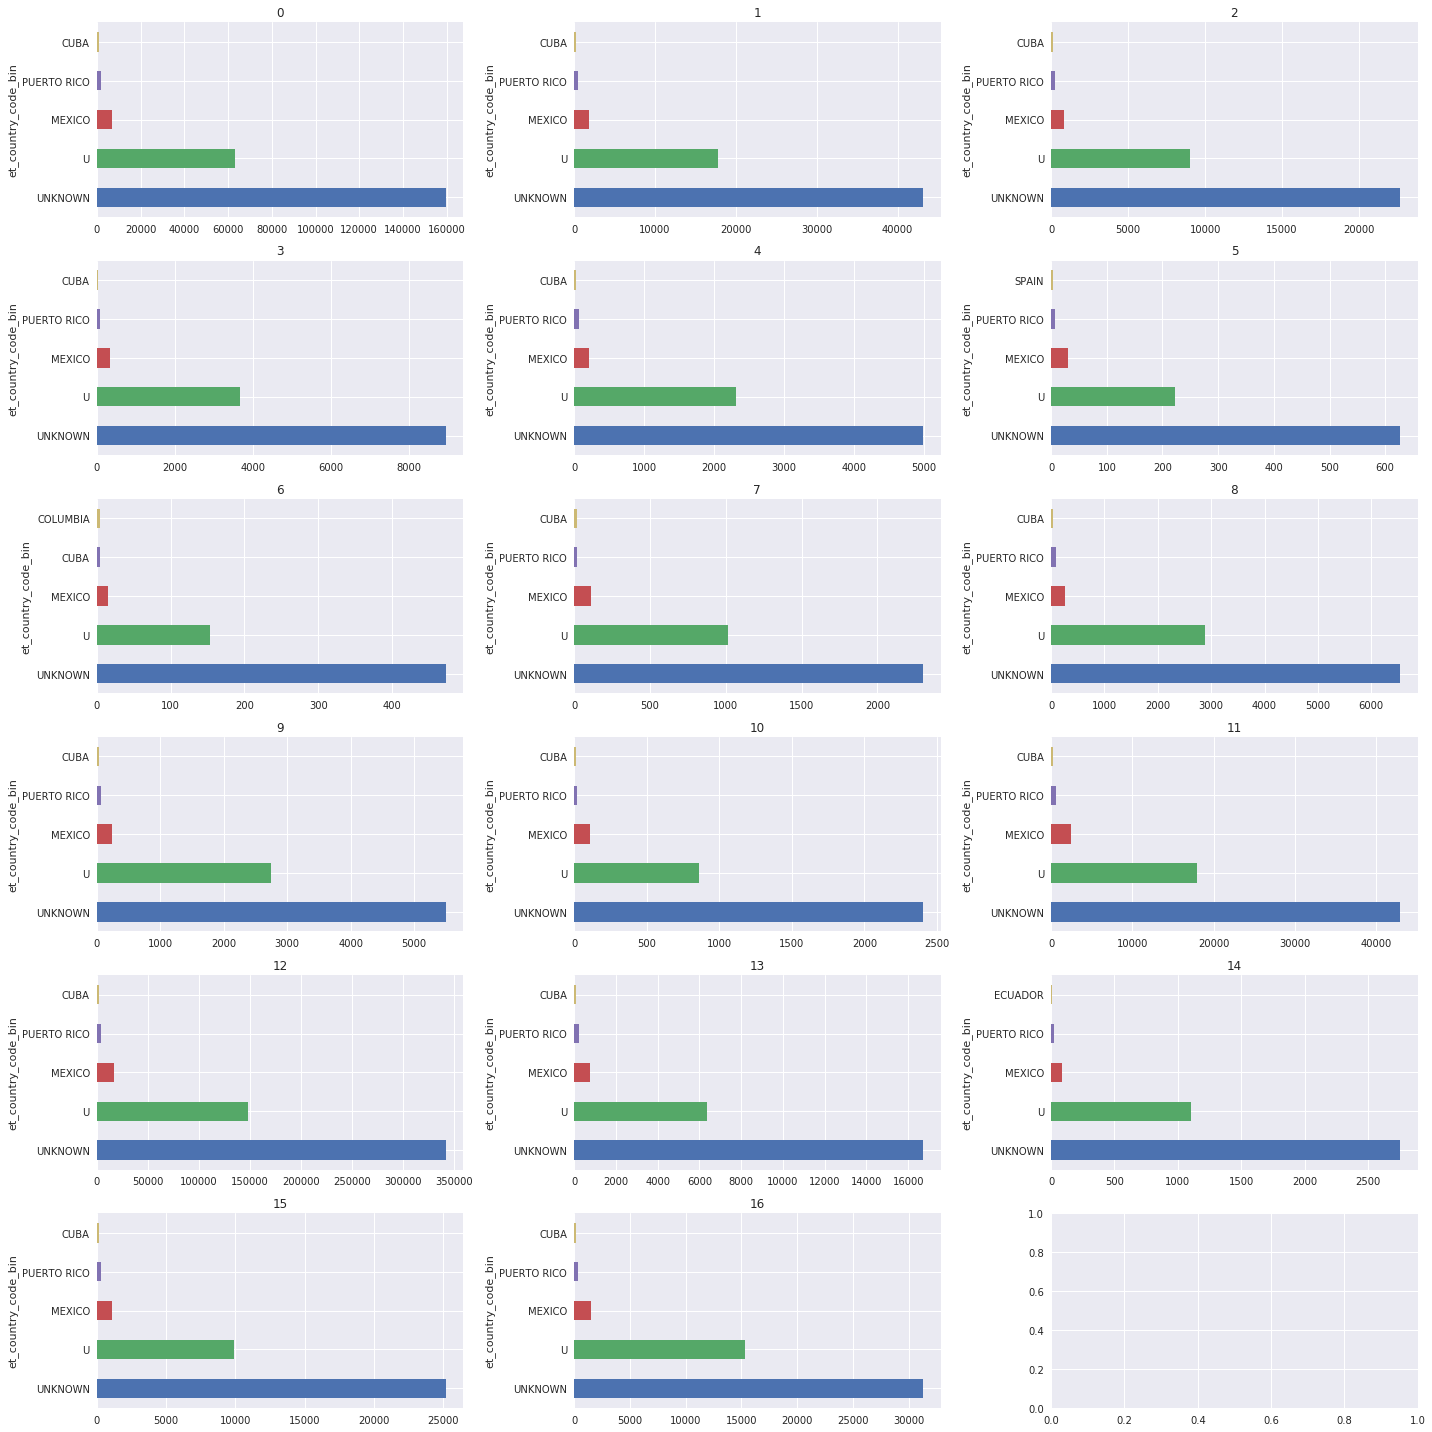

In [47]:
variable = "et_country_code_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> et_country_code: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

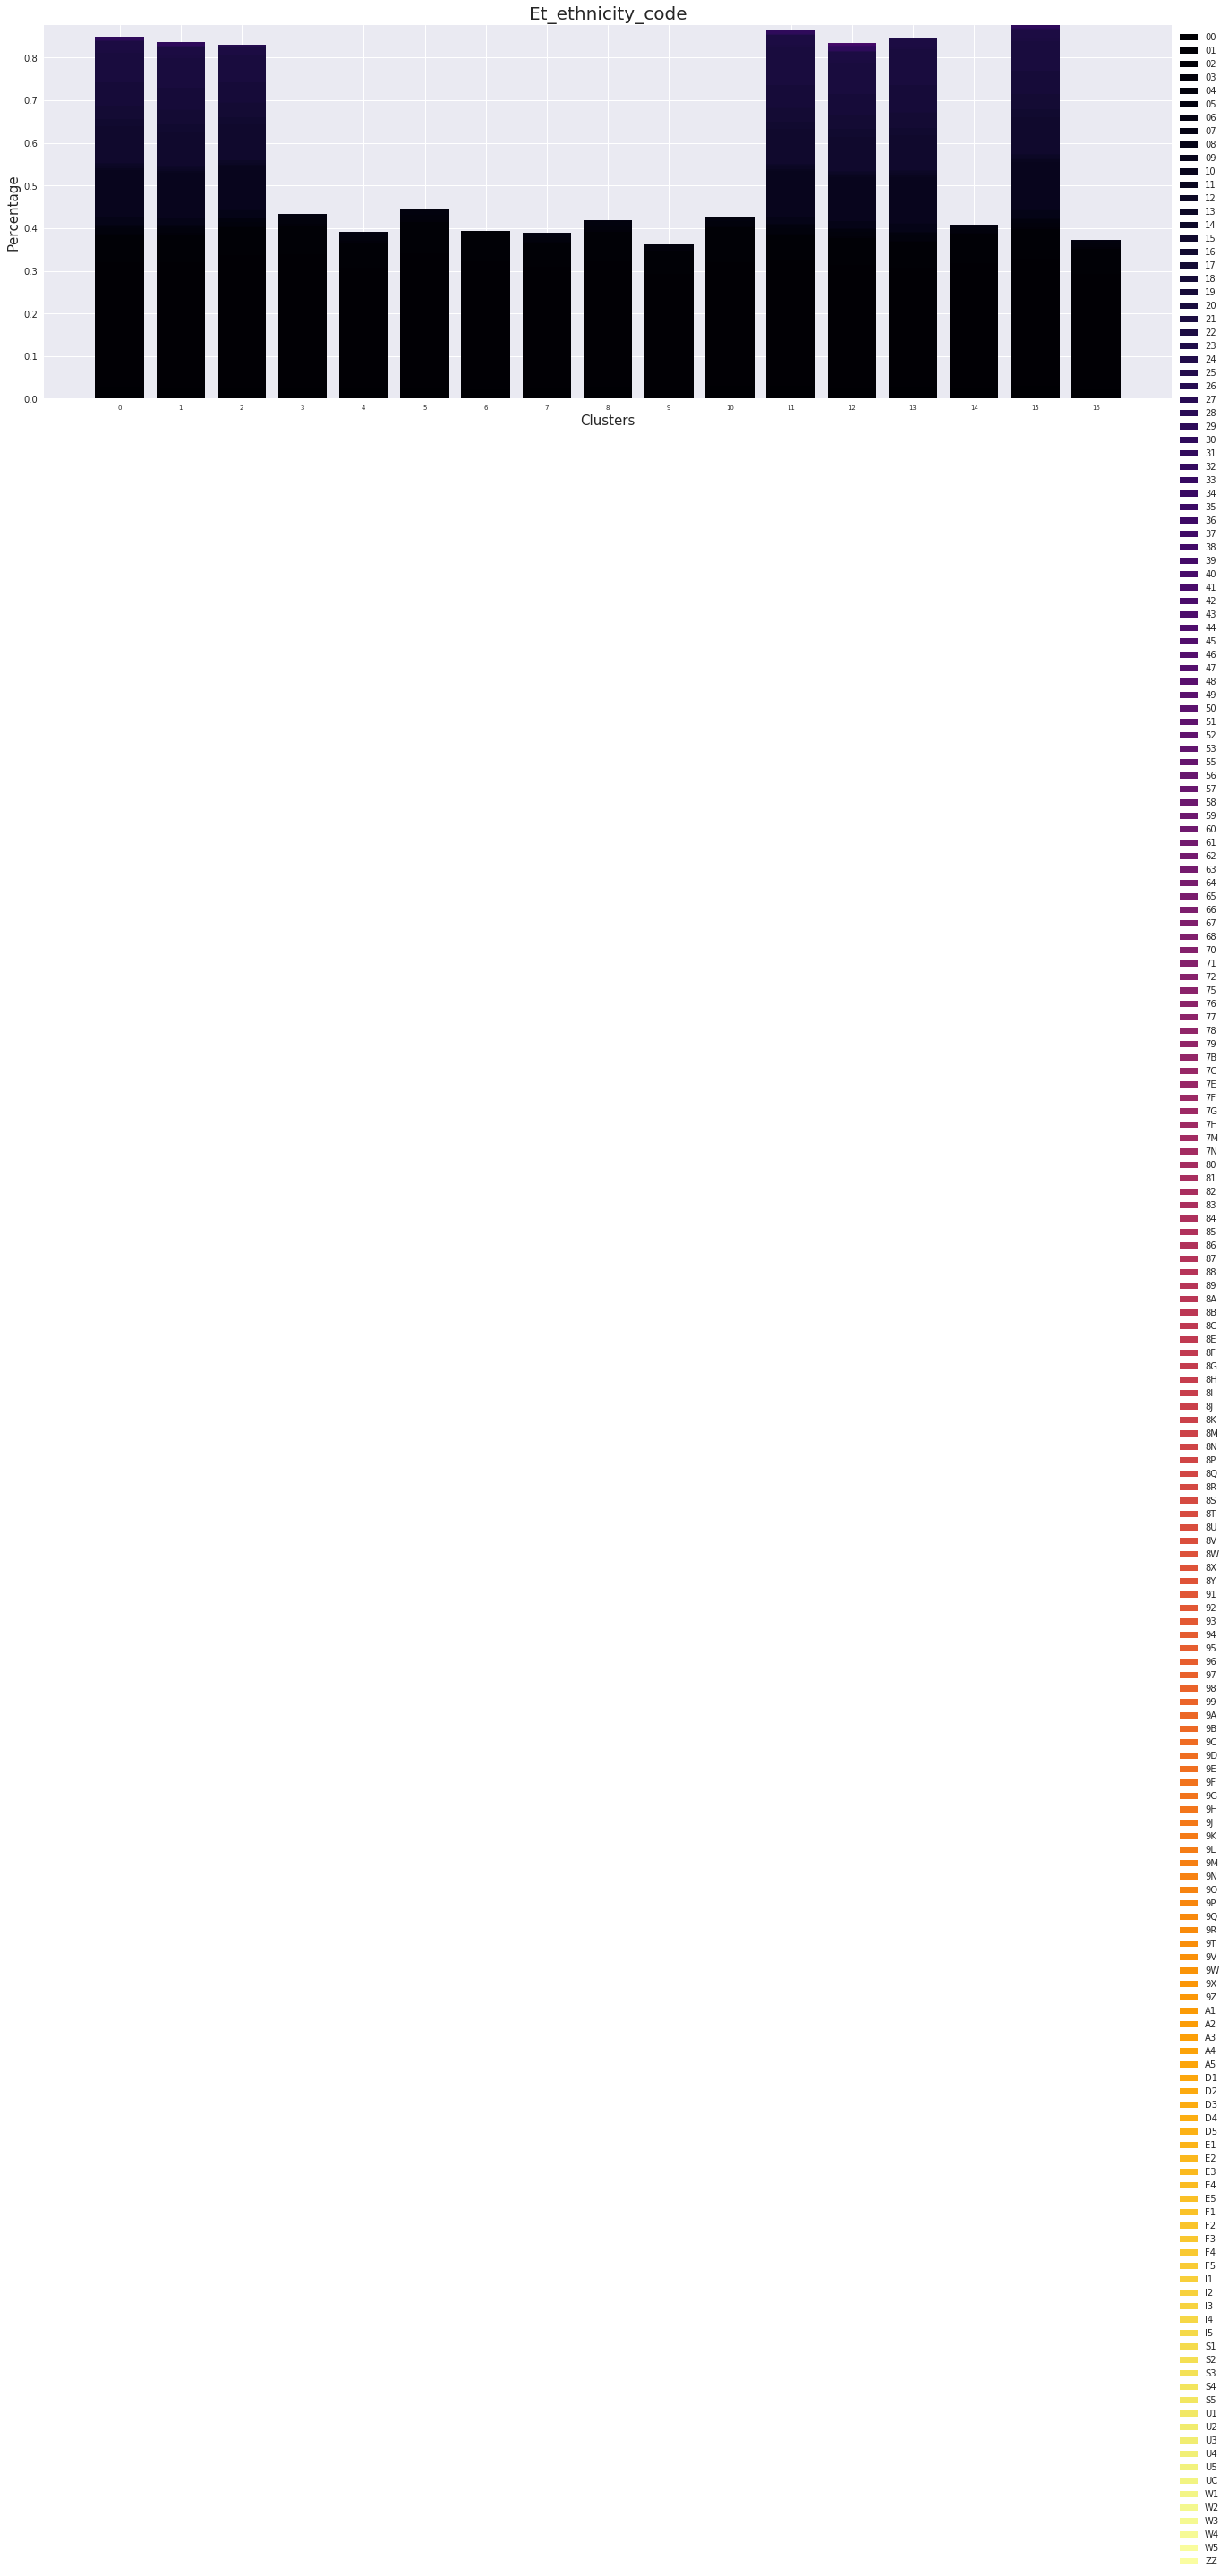

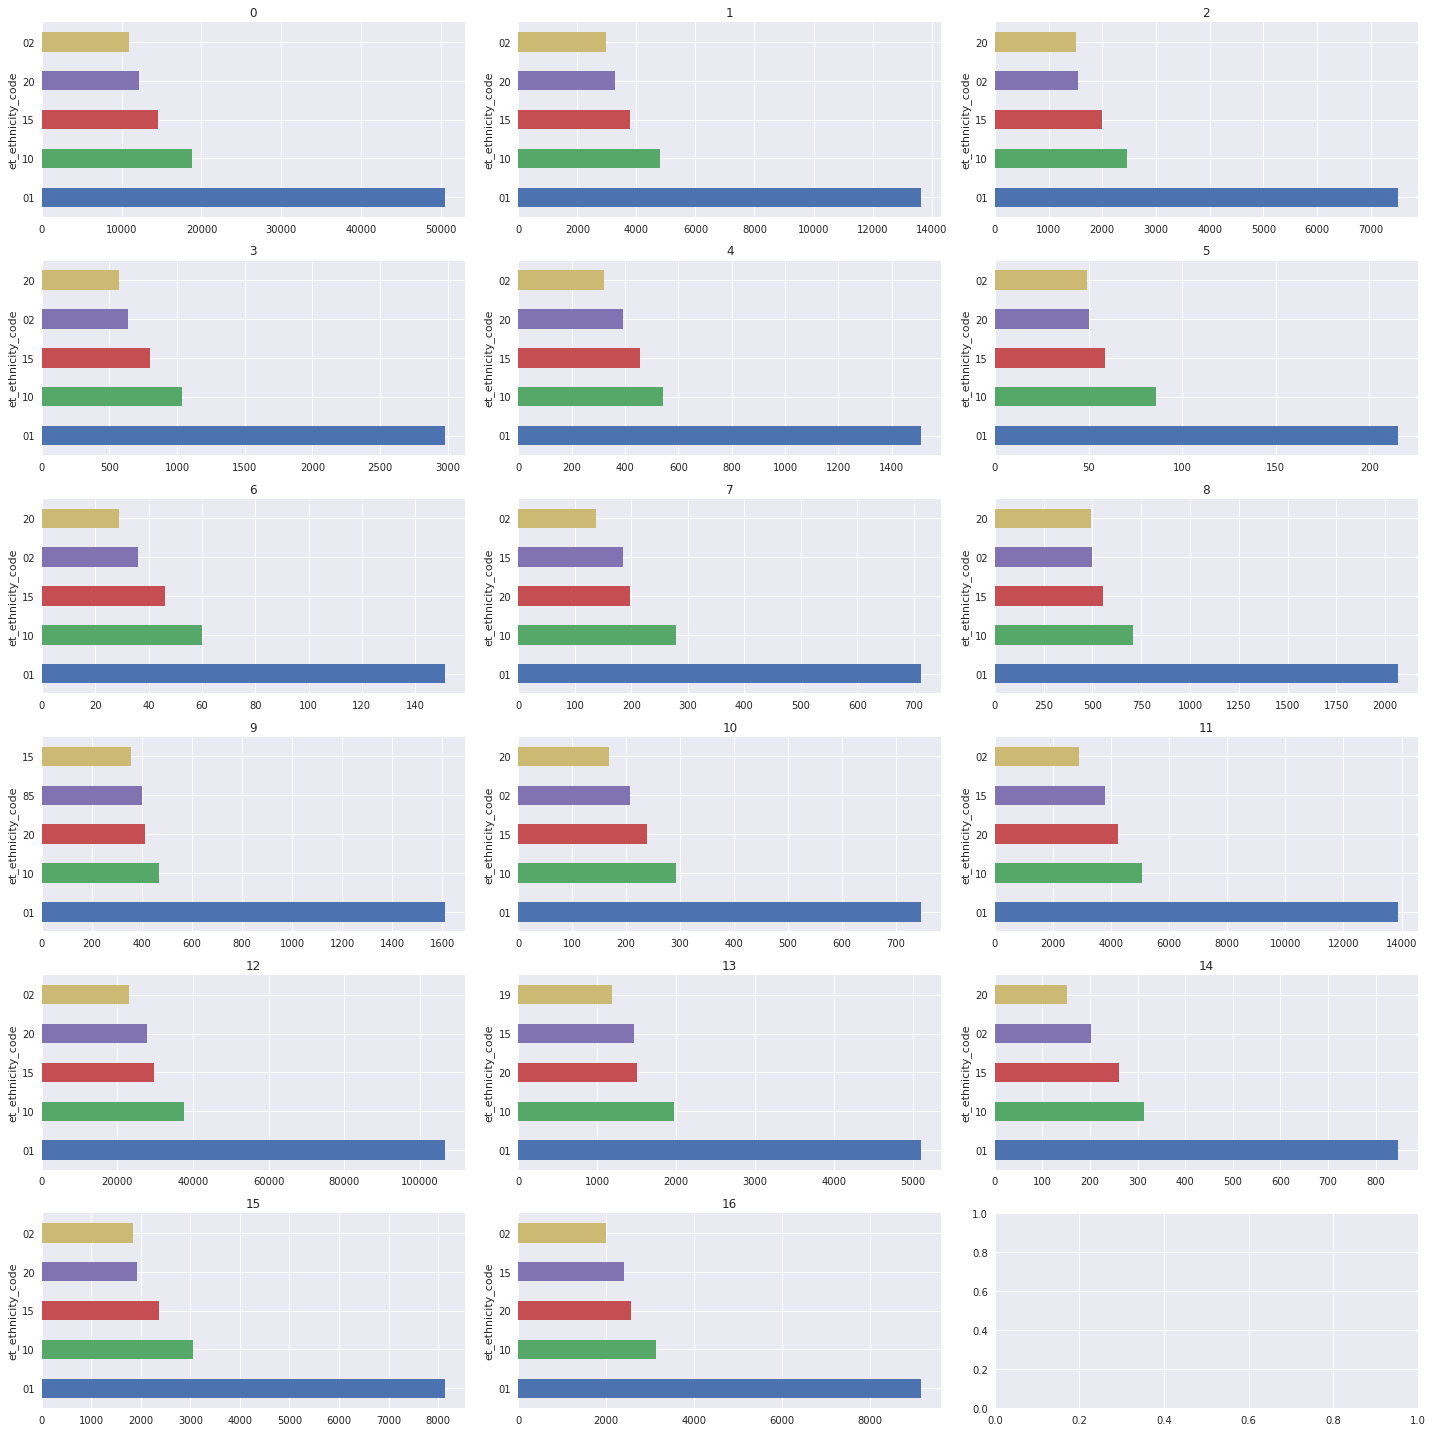

In [48]:
variable = "et_ethnicity_code"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> et_country_code_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

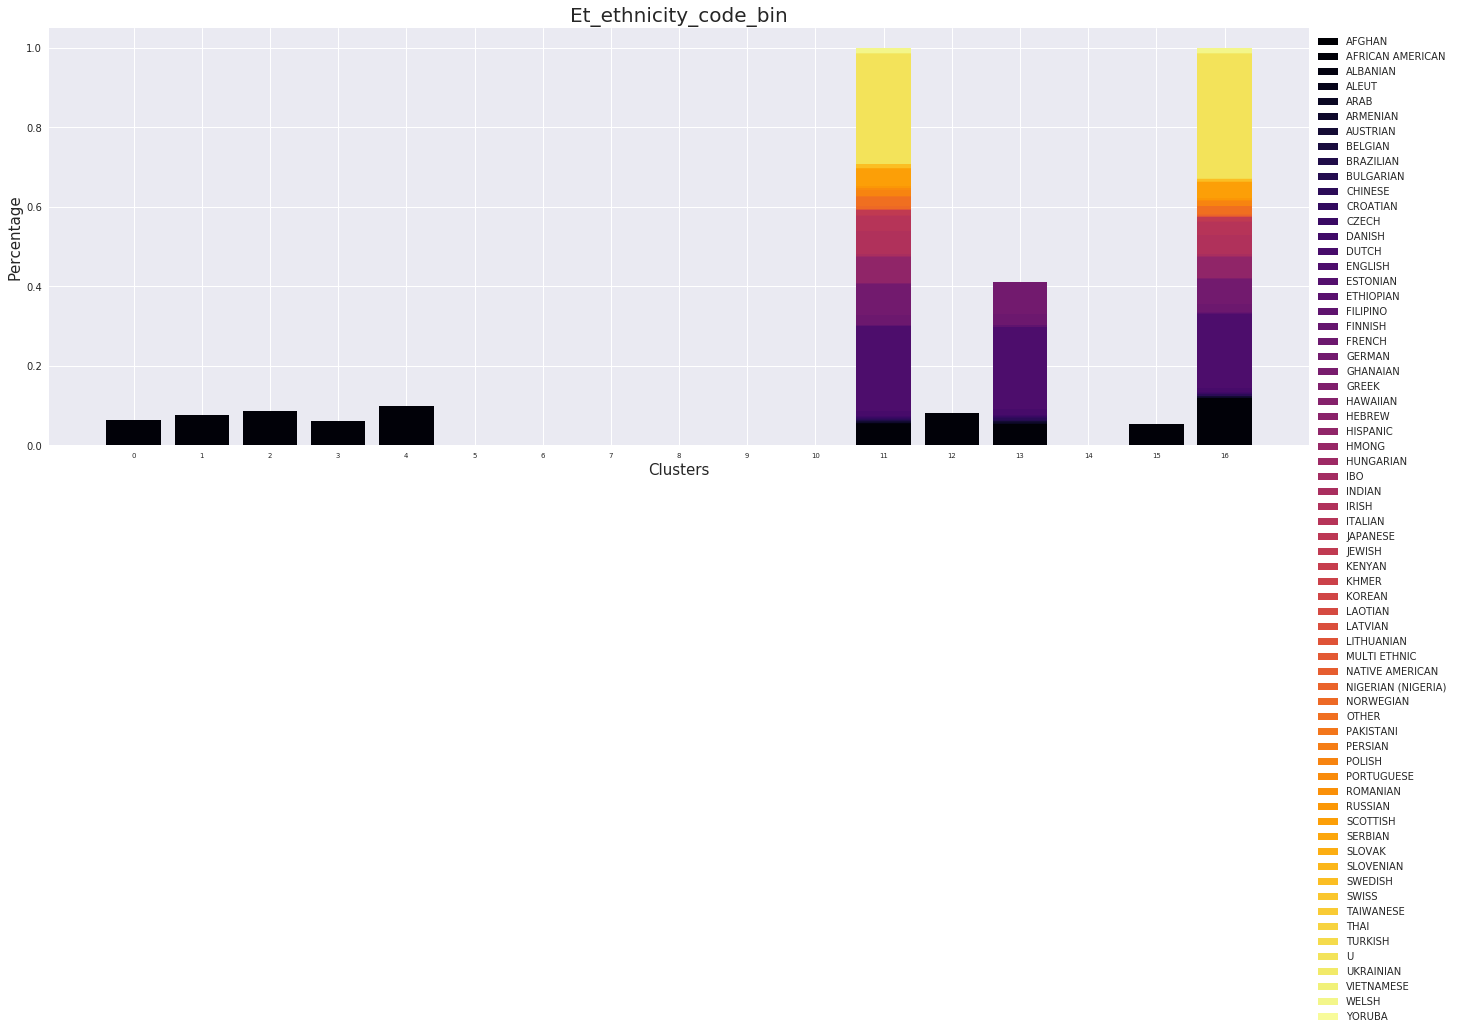

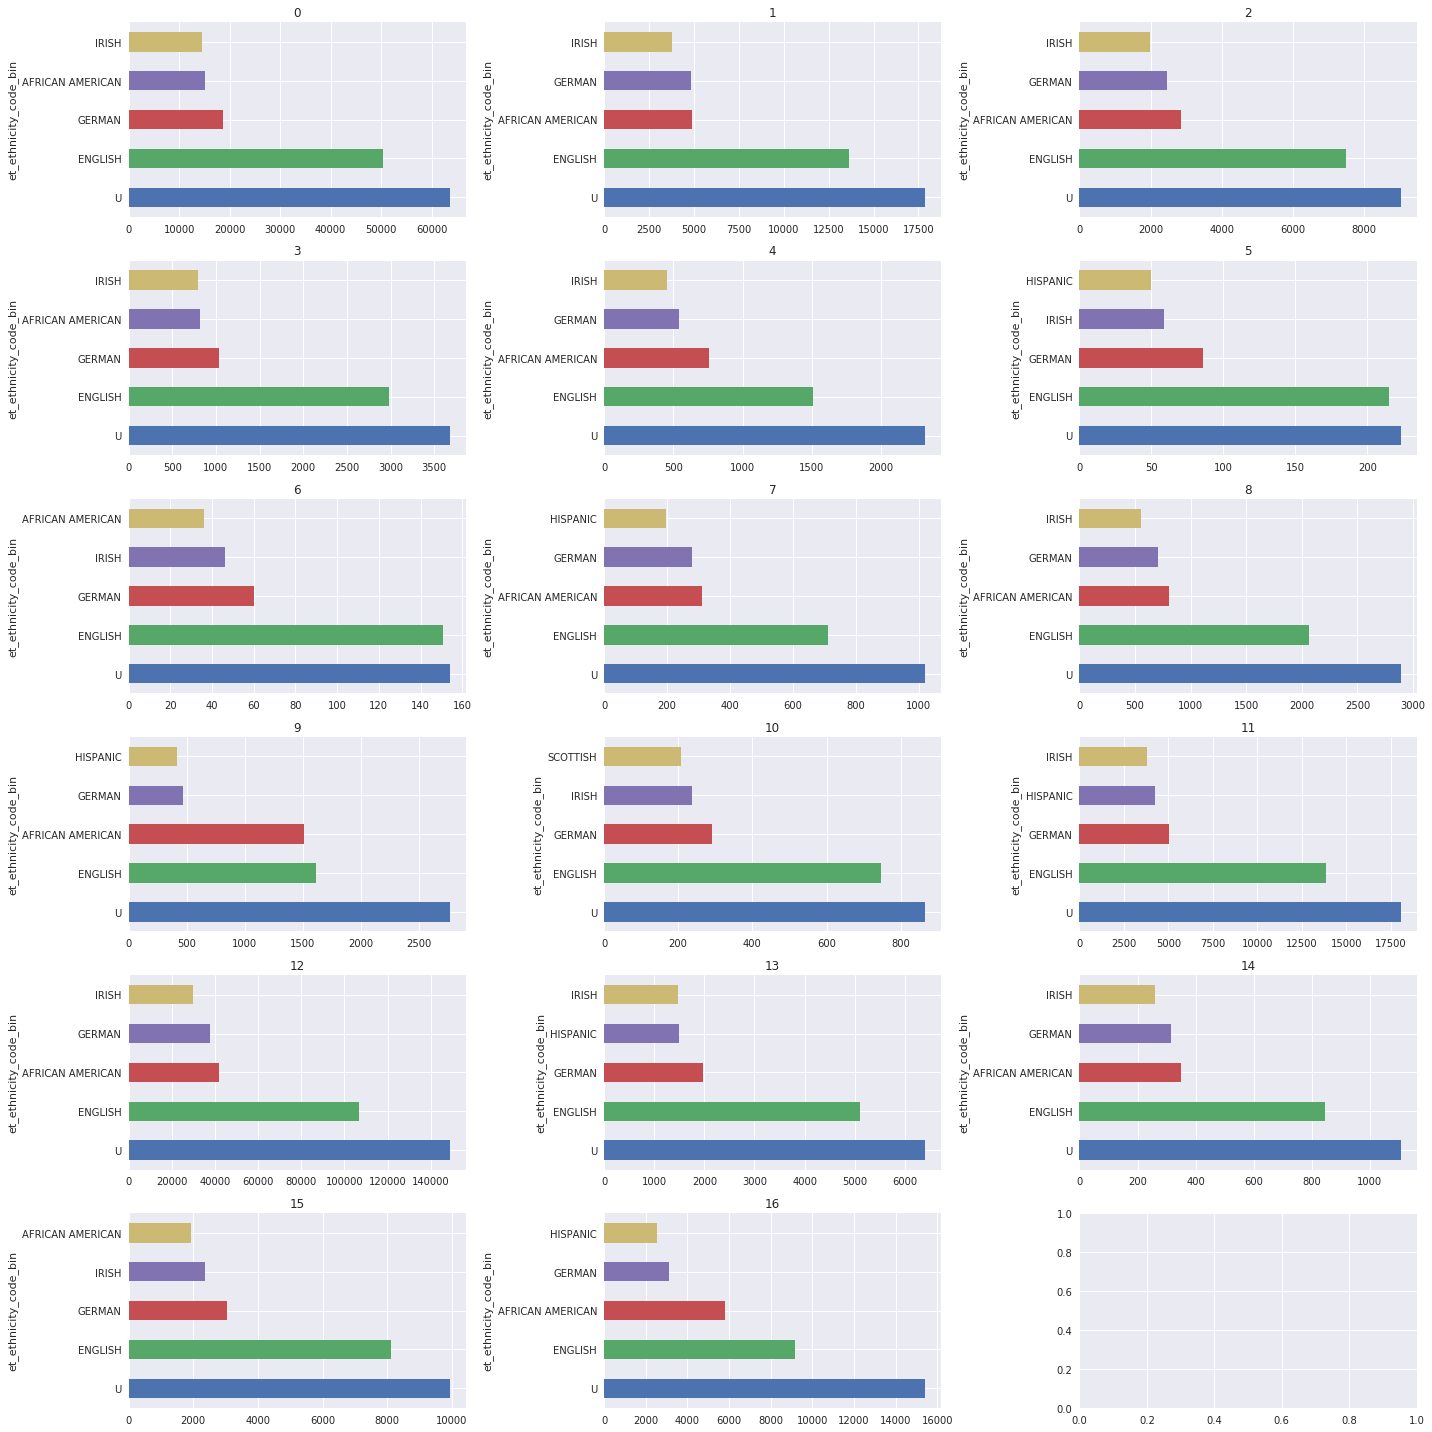

In [49]:
variable = "et_ethnicity_code_bin"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> et_group_code: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

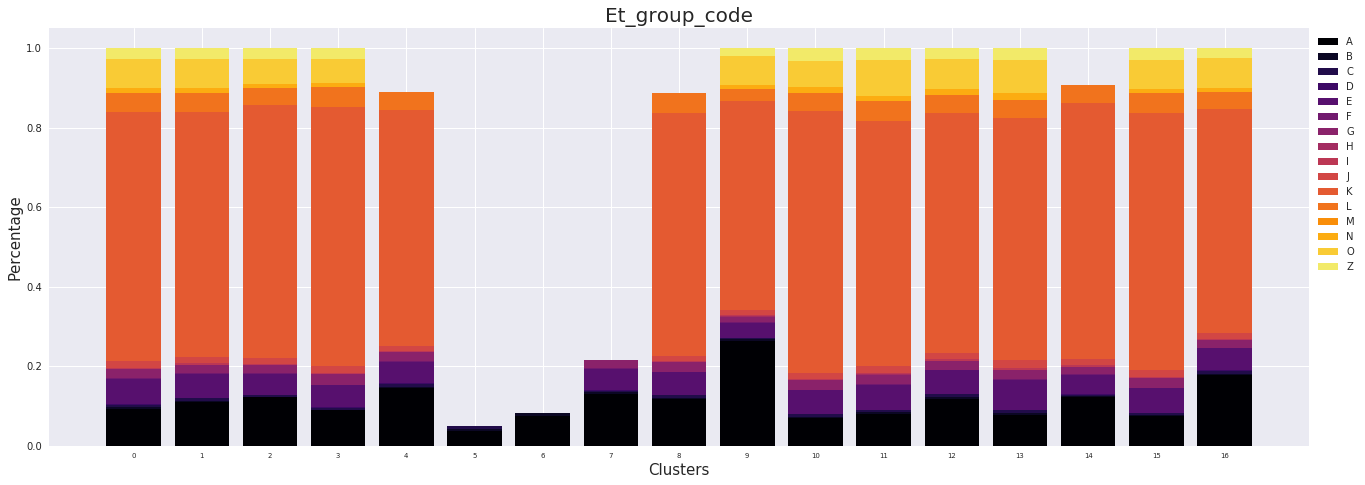

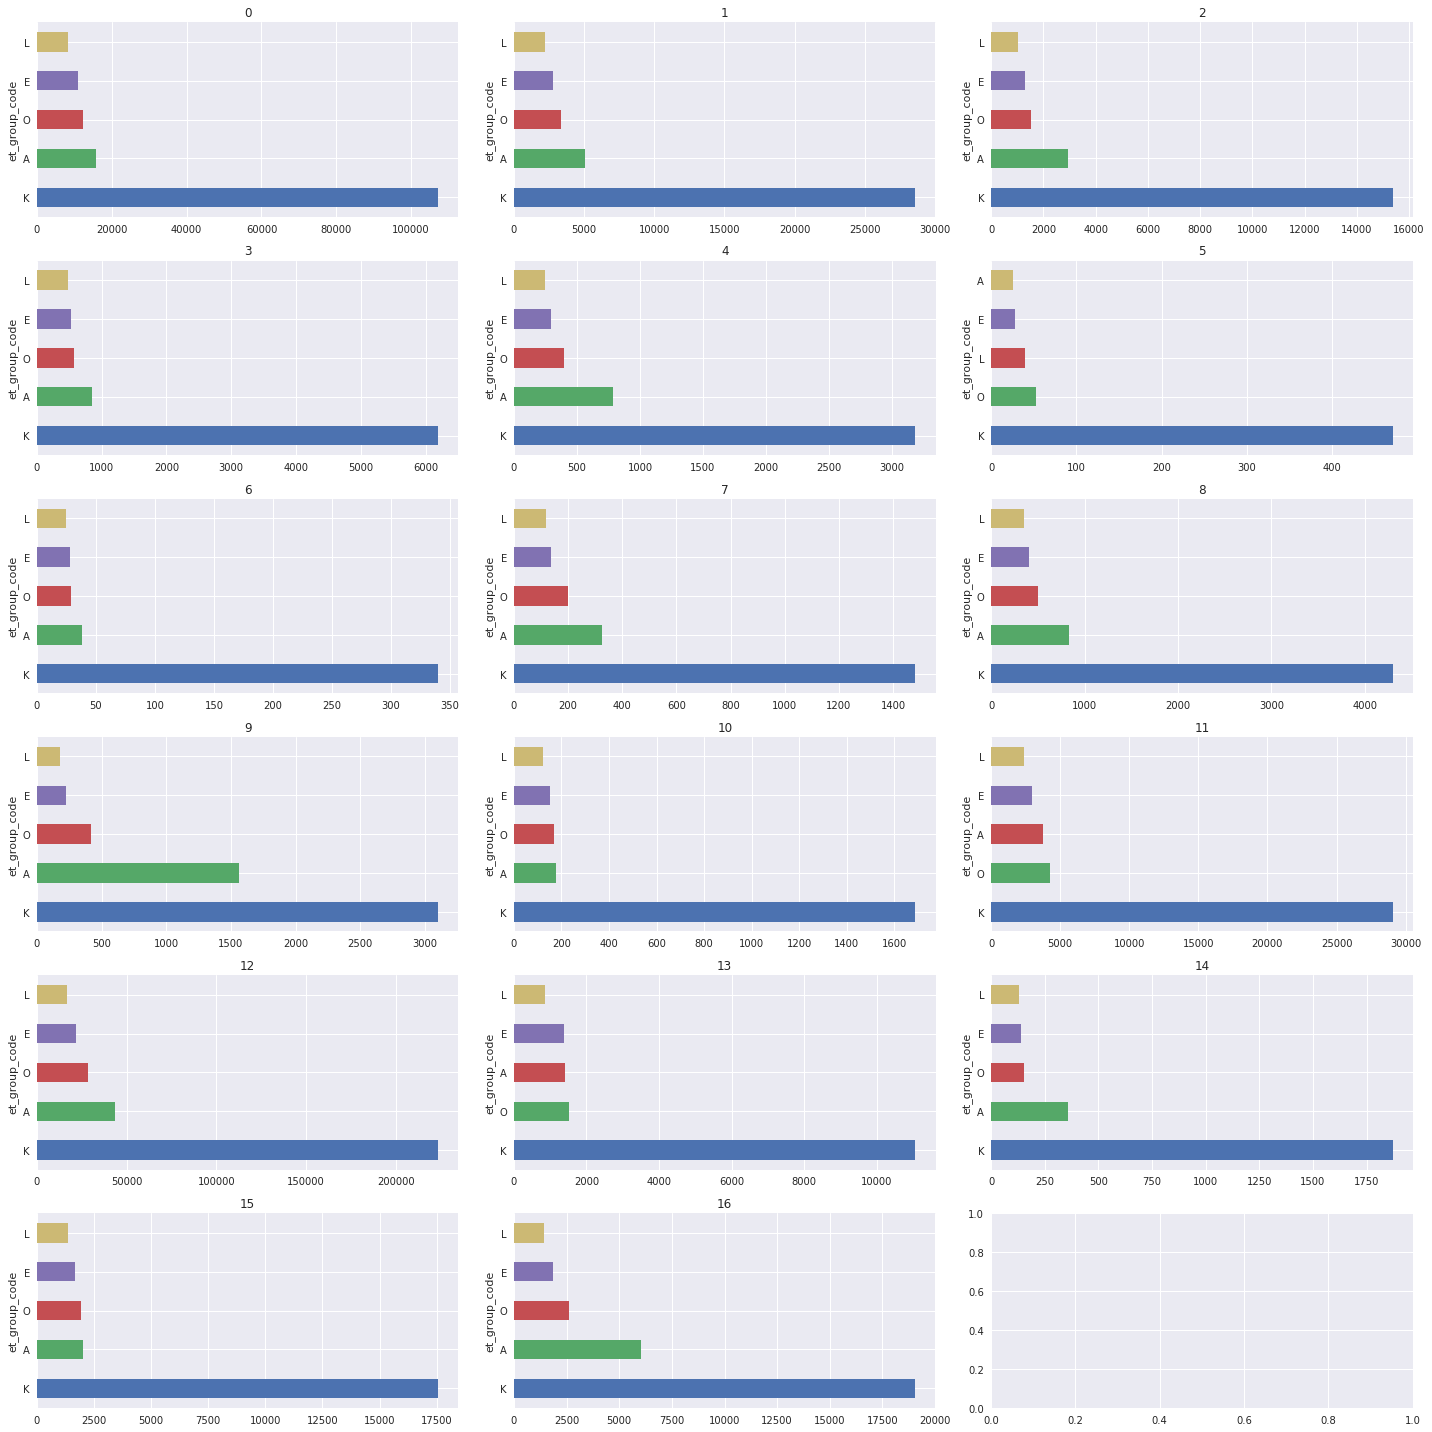

In [50]:
variable = "et_group_code"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> family_tier: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

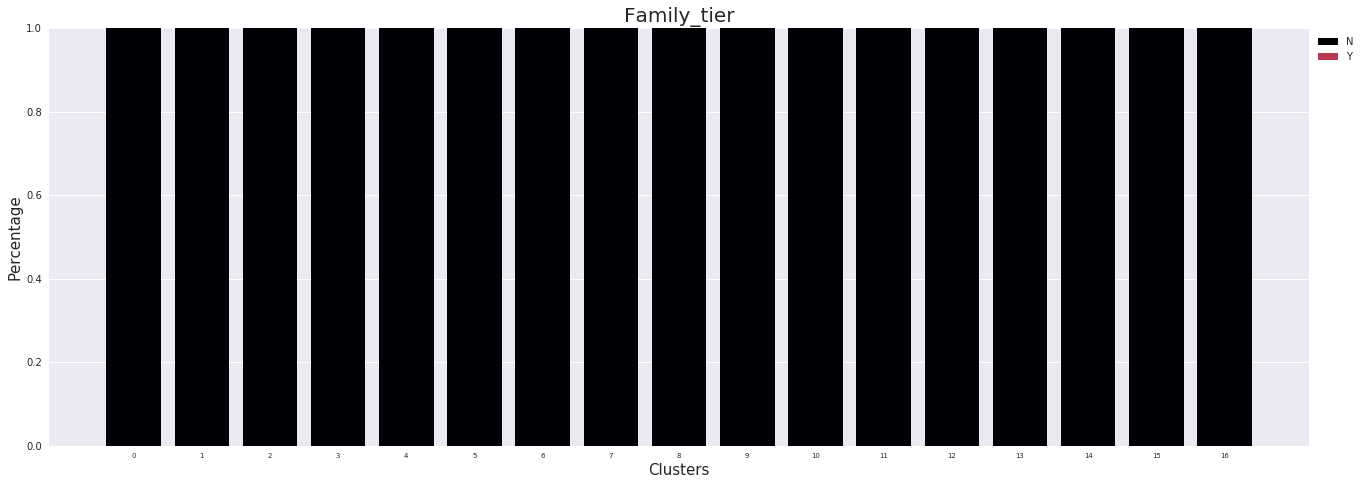

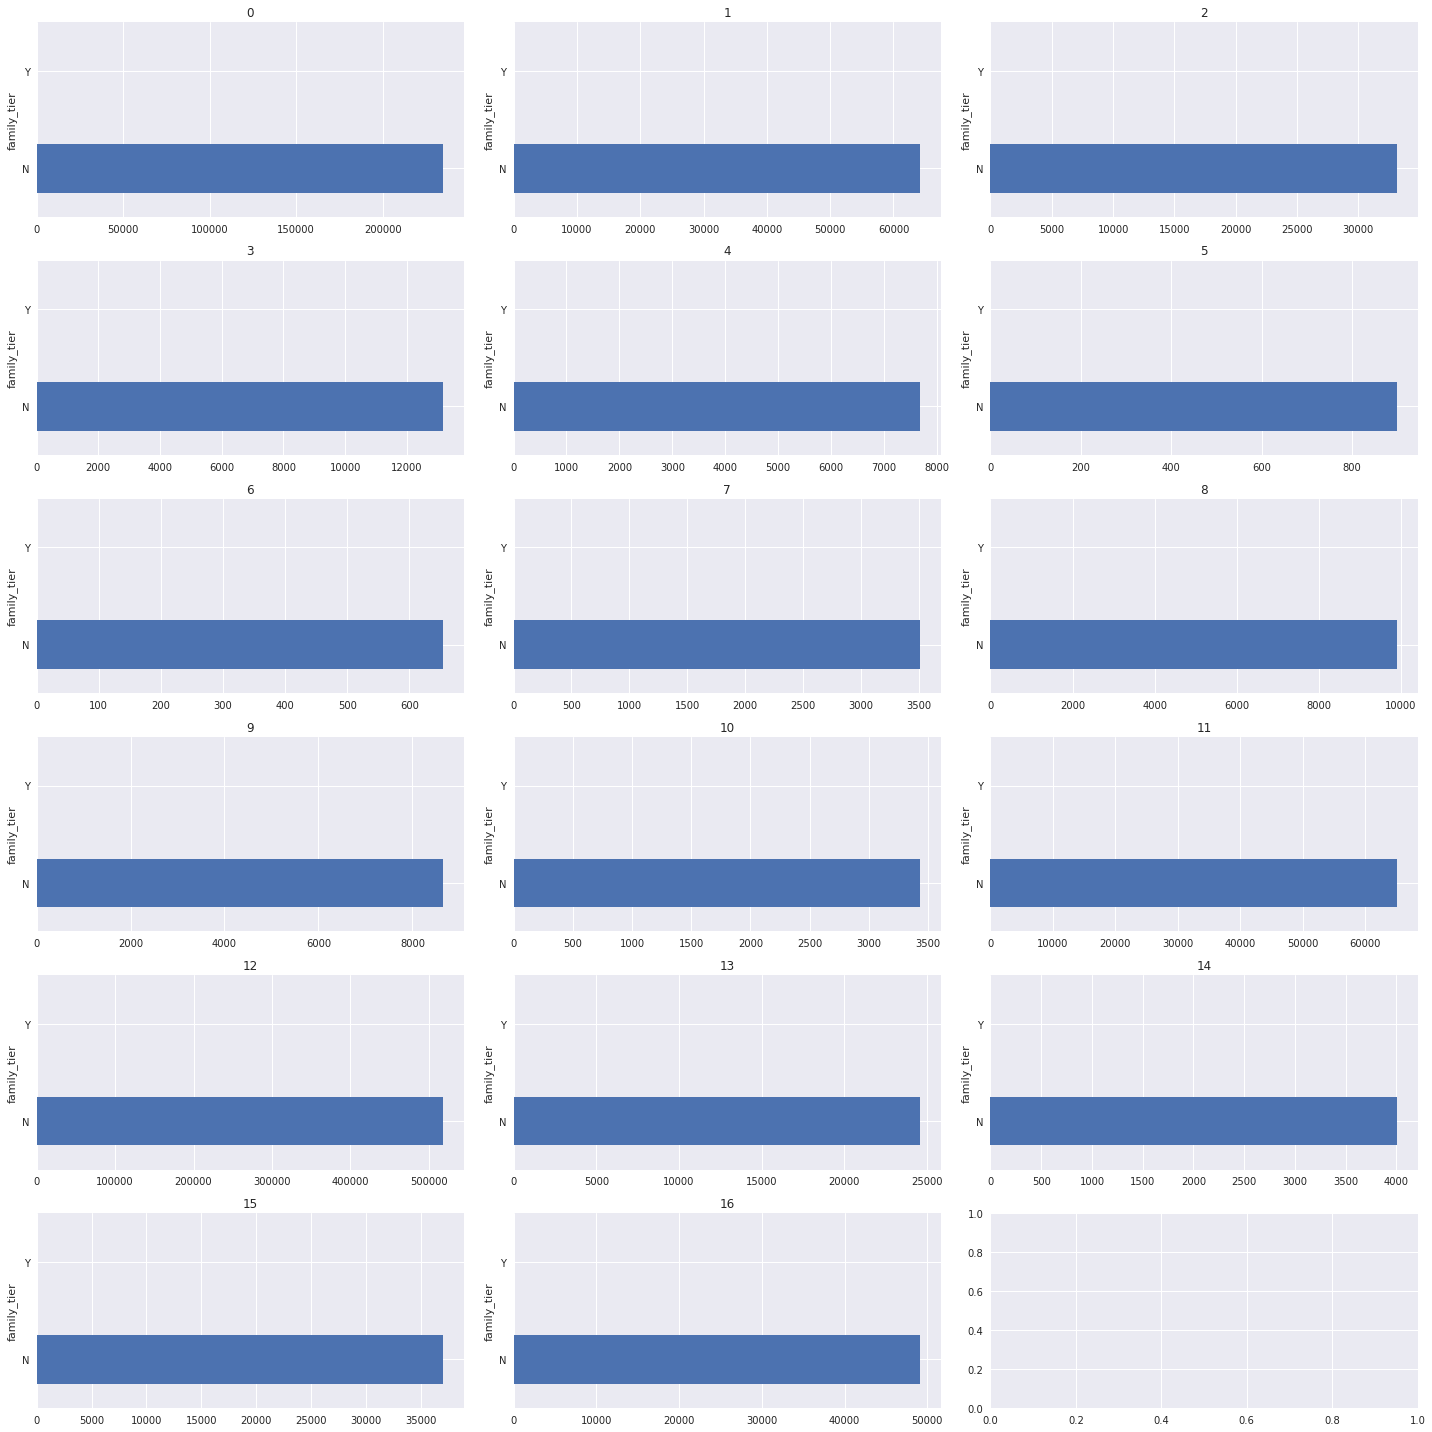

In [51]:
variable = "family_tier"

df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen"> <b> gapowncomppckuprk_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

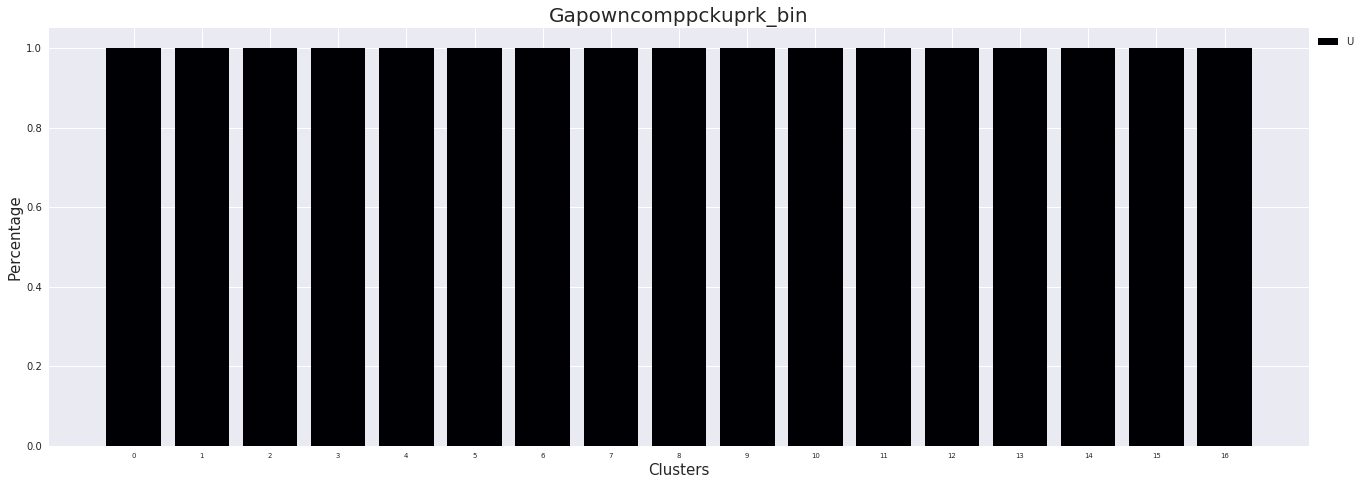

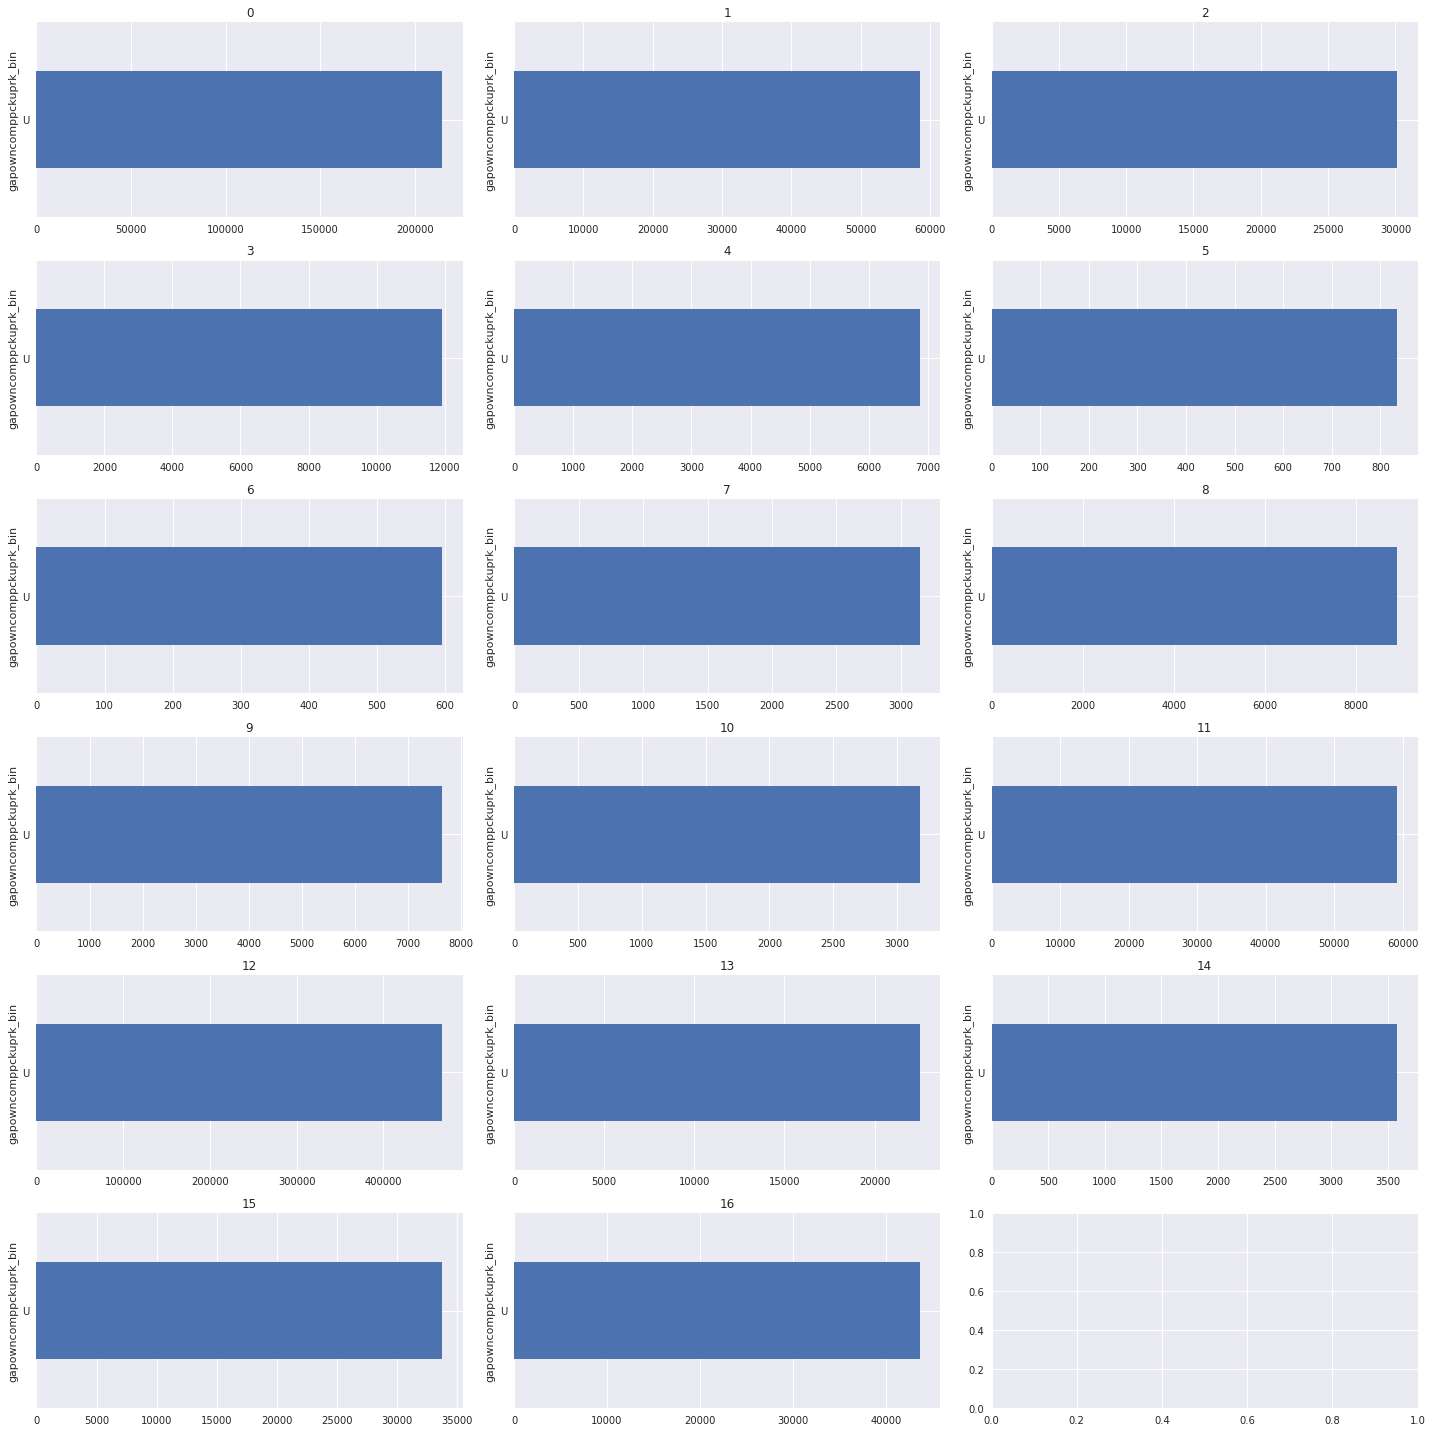

In [52]:
variable = "gapowncomppckuprk_bin"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> gender: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

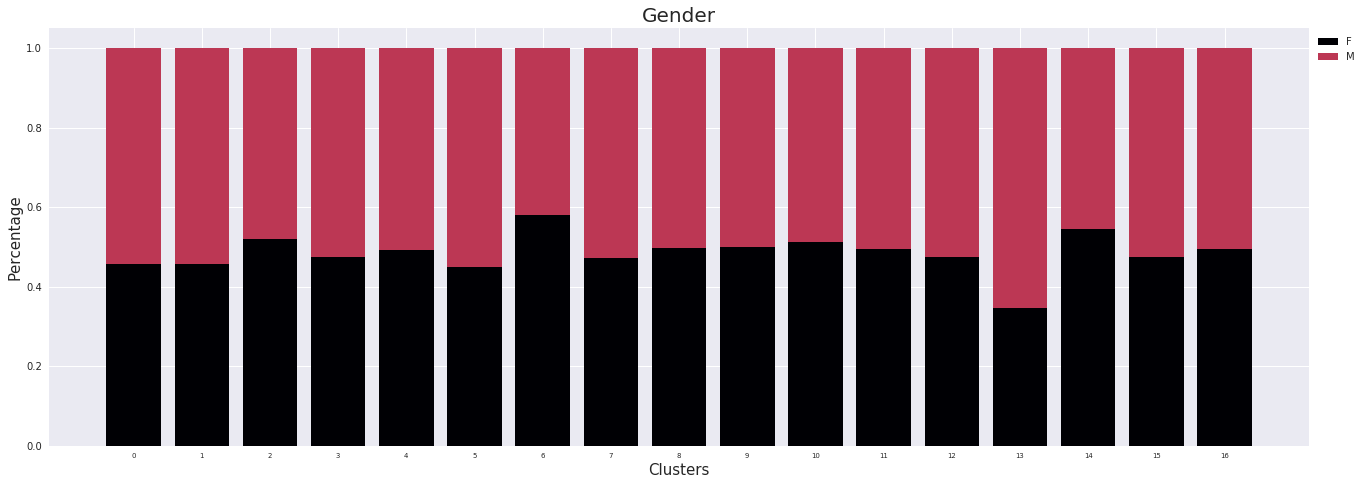

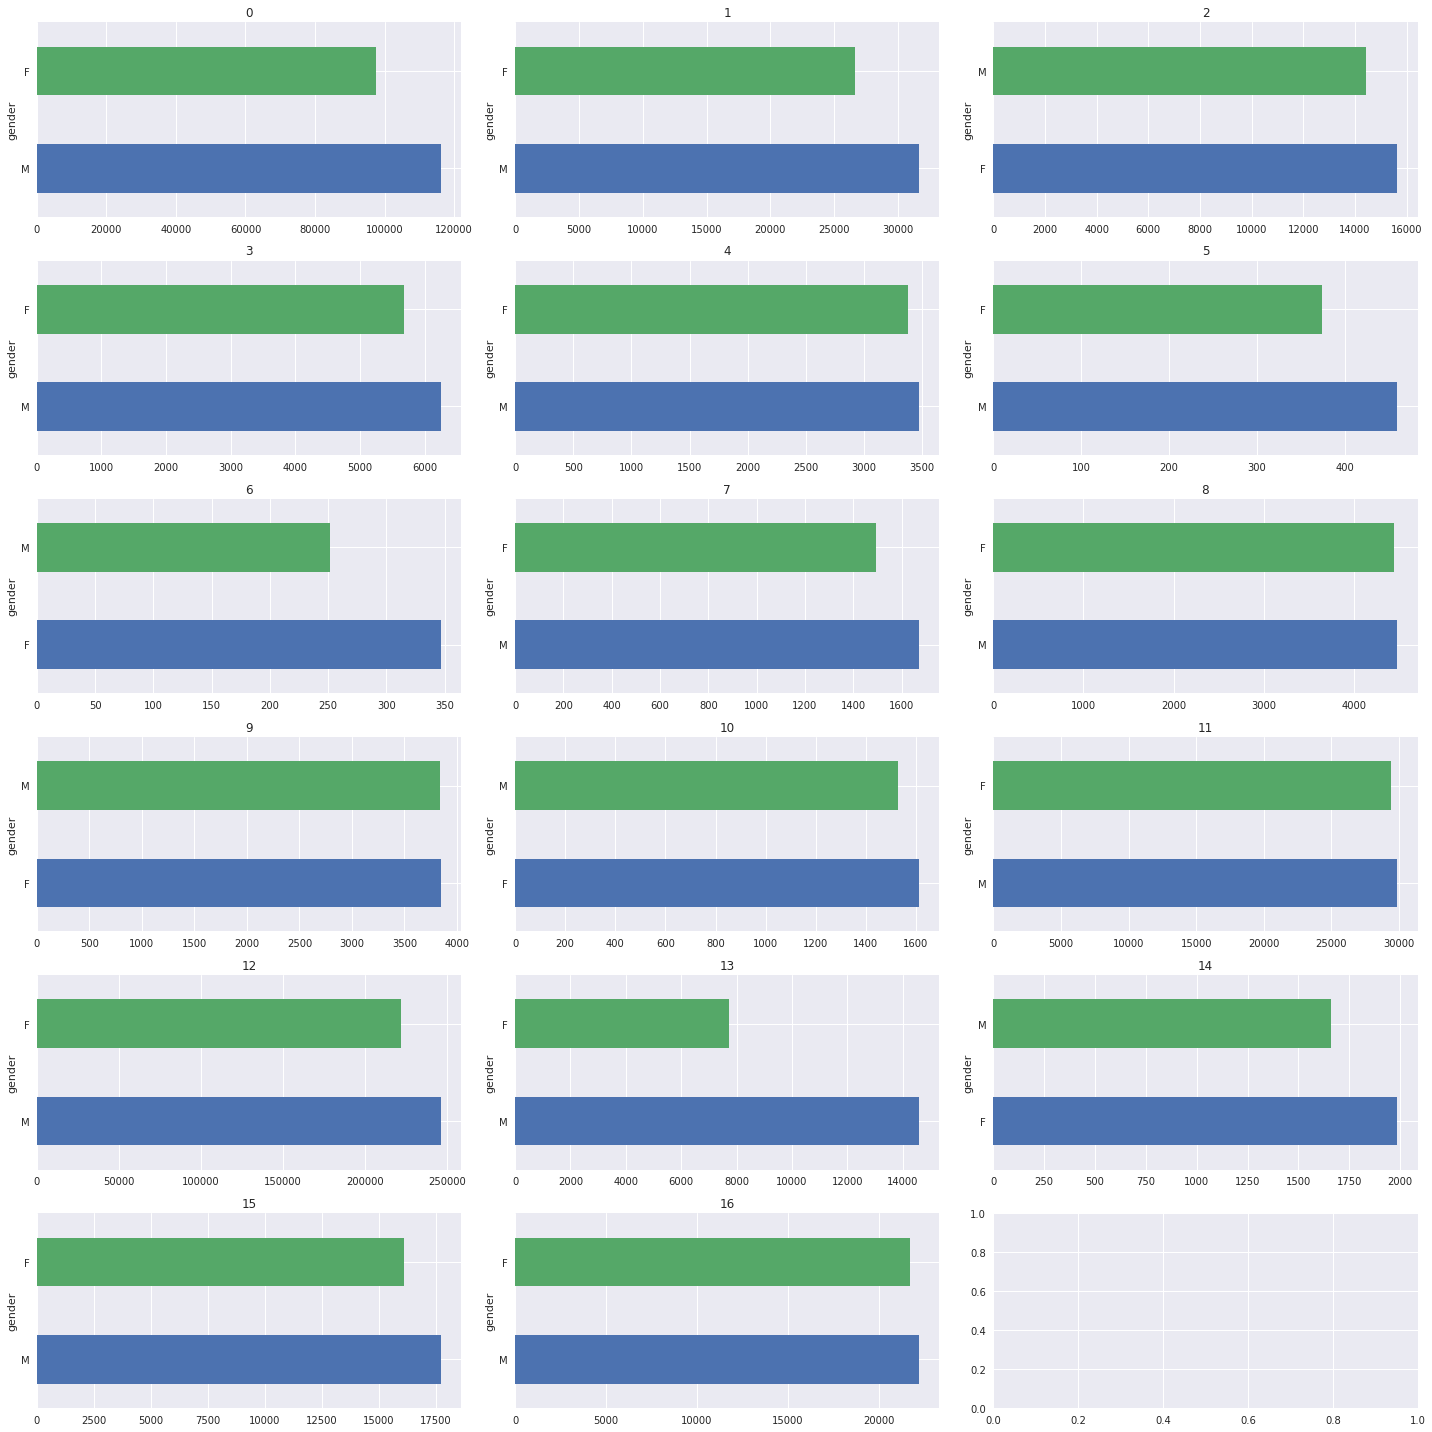

In [53]:
variable = "gender"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()


<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> household_size: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

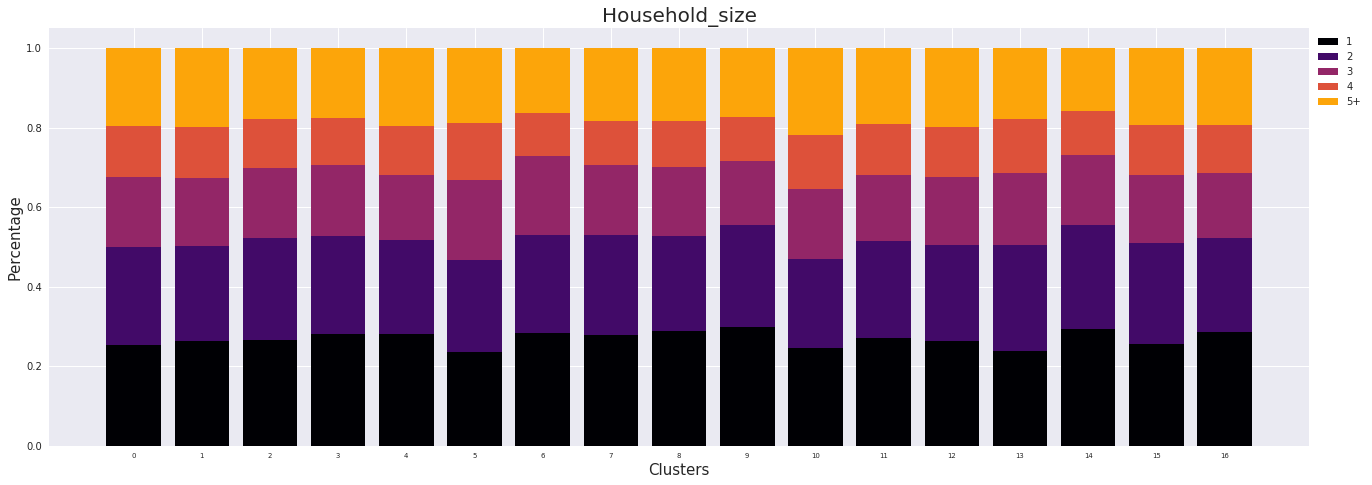

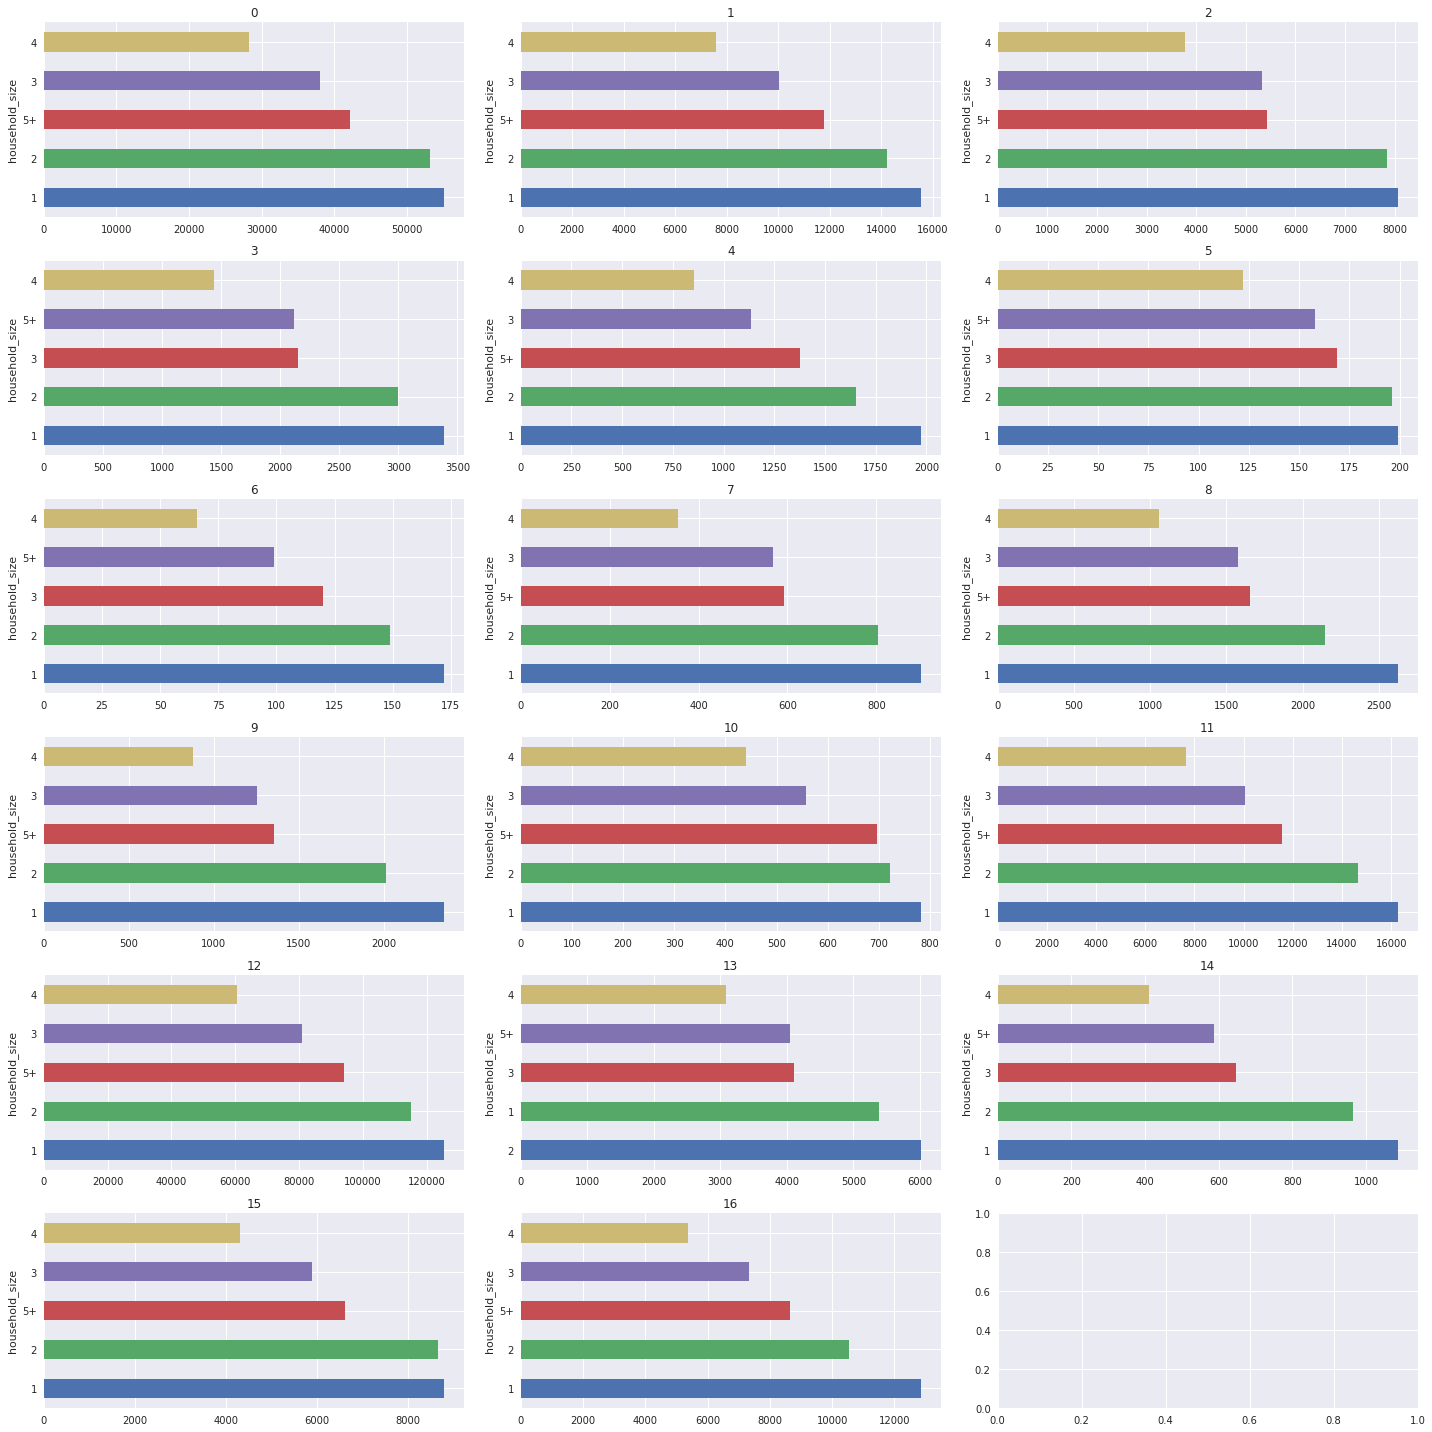

In [54]:
variable = "household_size"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()



<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> hsi_active_ind: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

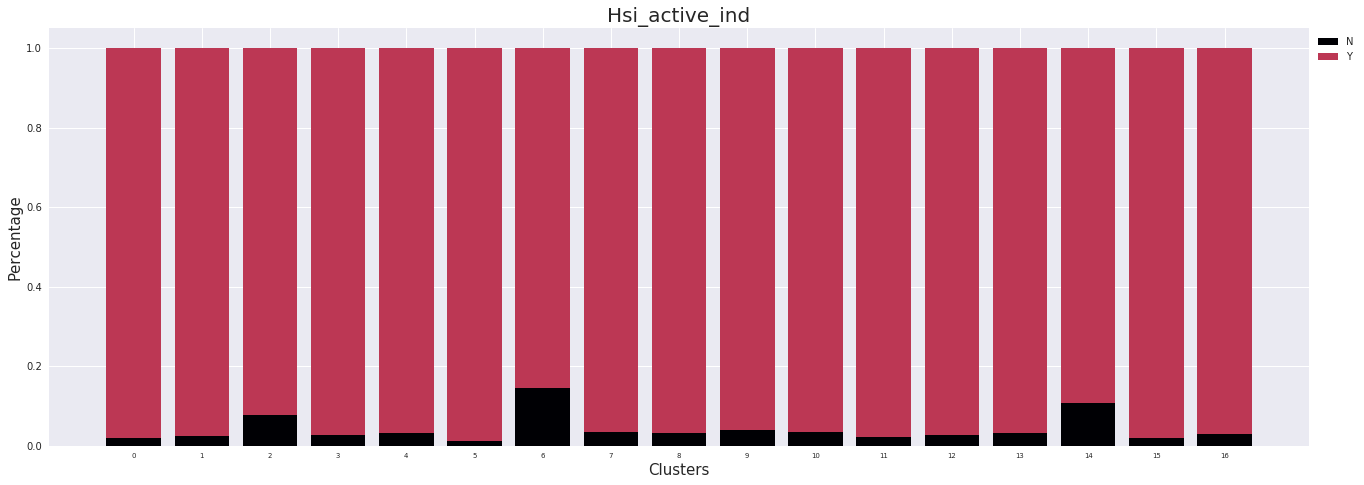

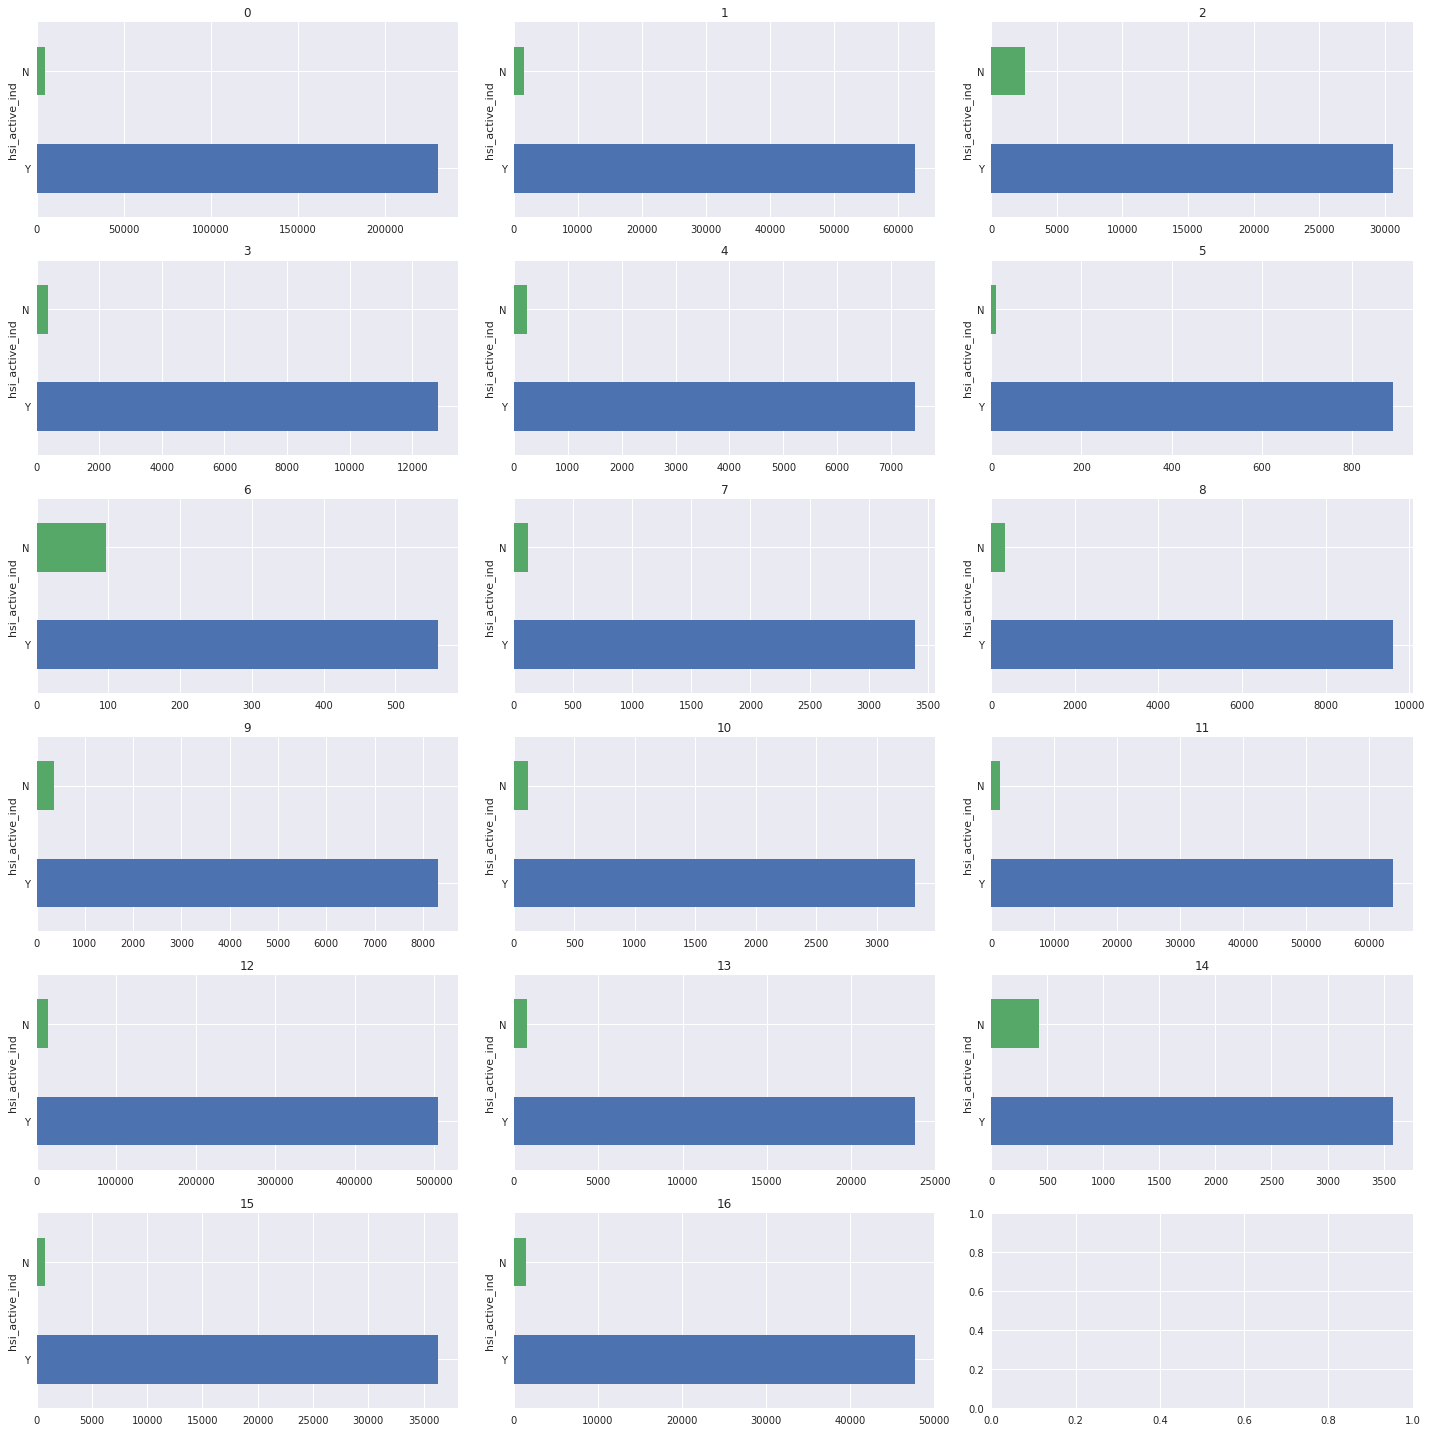

In [55]:
variable = "hsi_active_ind"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()



<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> Income: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

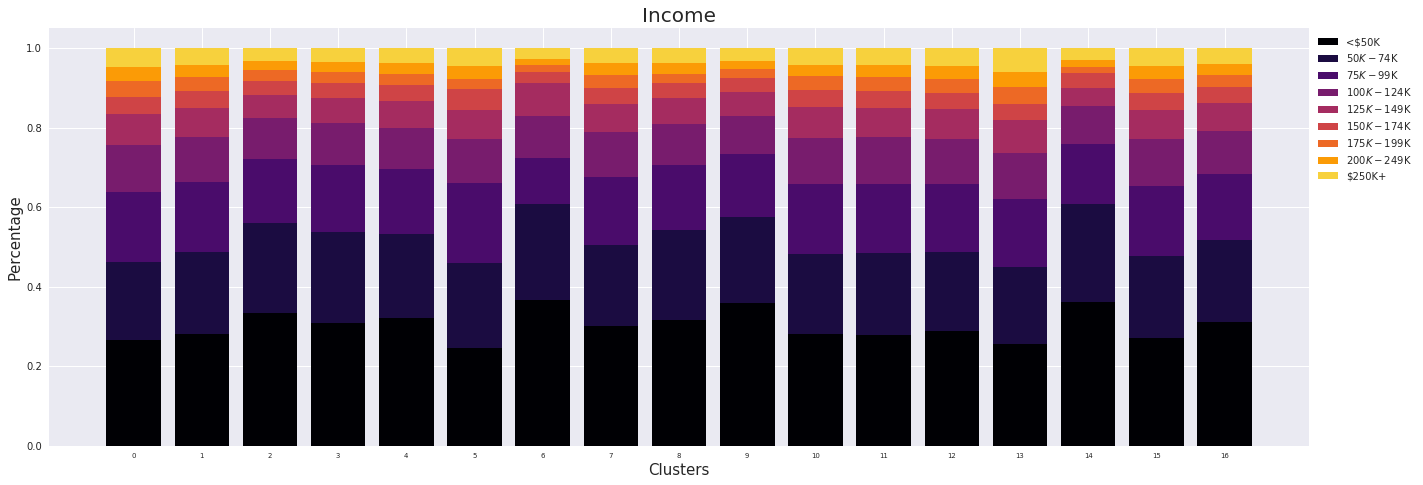

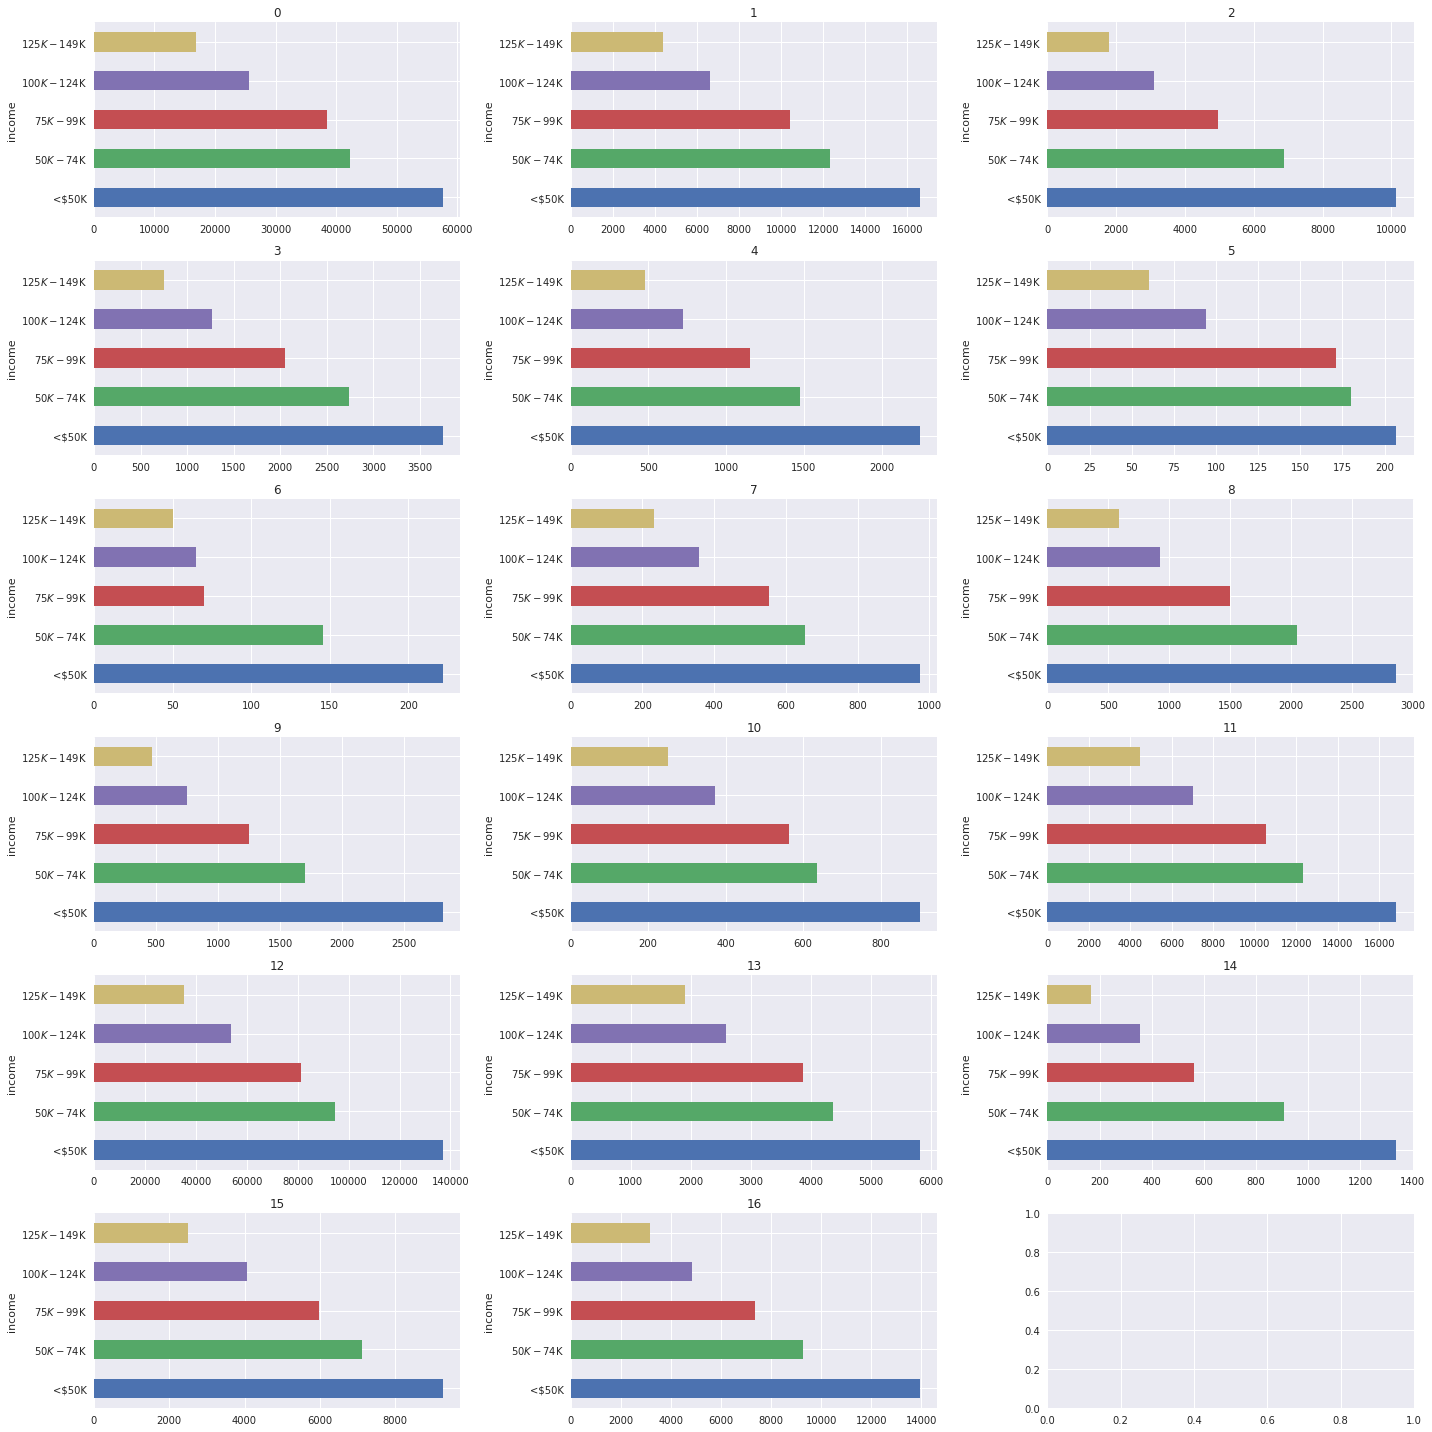

In [56]:
variable = "income"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = ['<$50K','$50K - $74K', '$75K - $99K', '$100K - $124K', '$125K - $149K', '$150K - $174K', '$175K - $199K', '$200K - $249K', '$250K+']

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()



<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> networth_v3_2: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

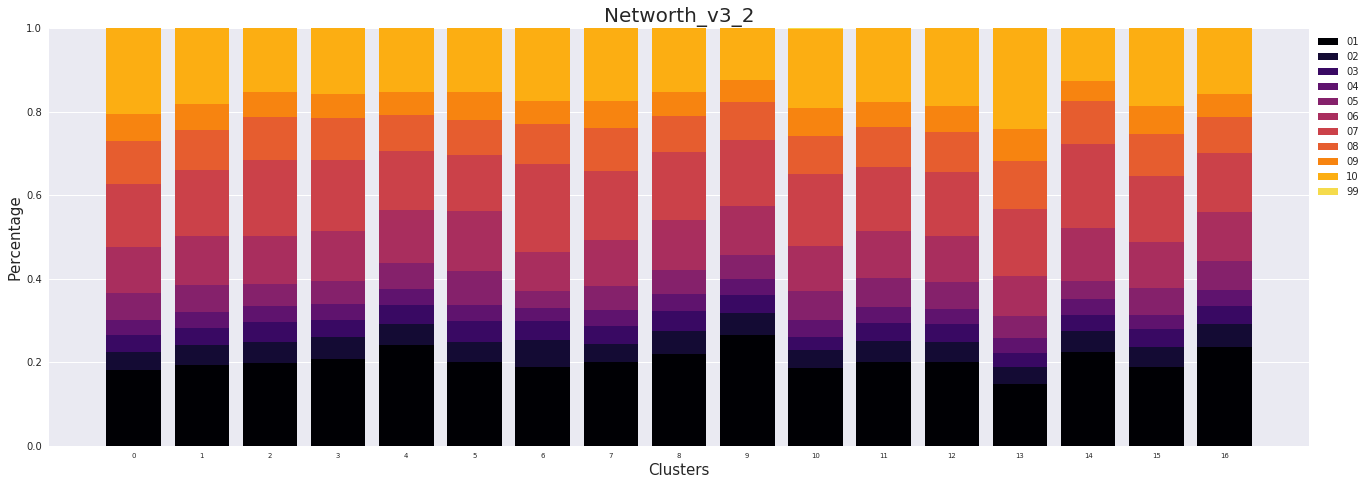

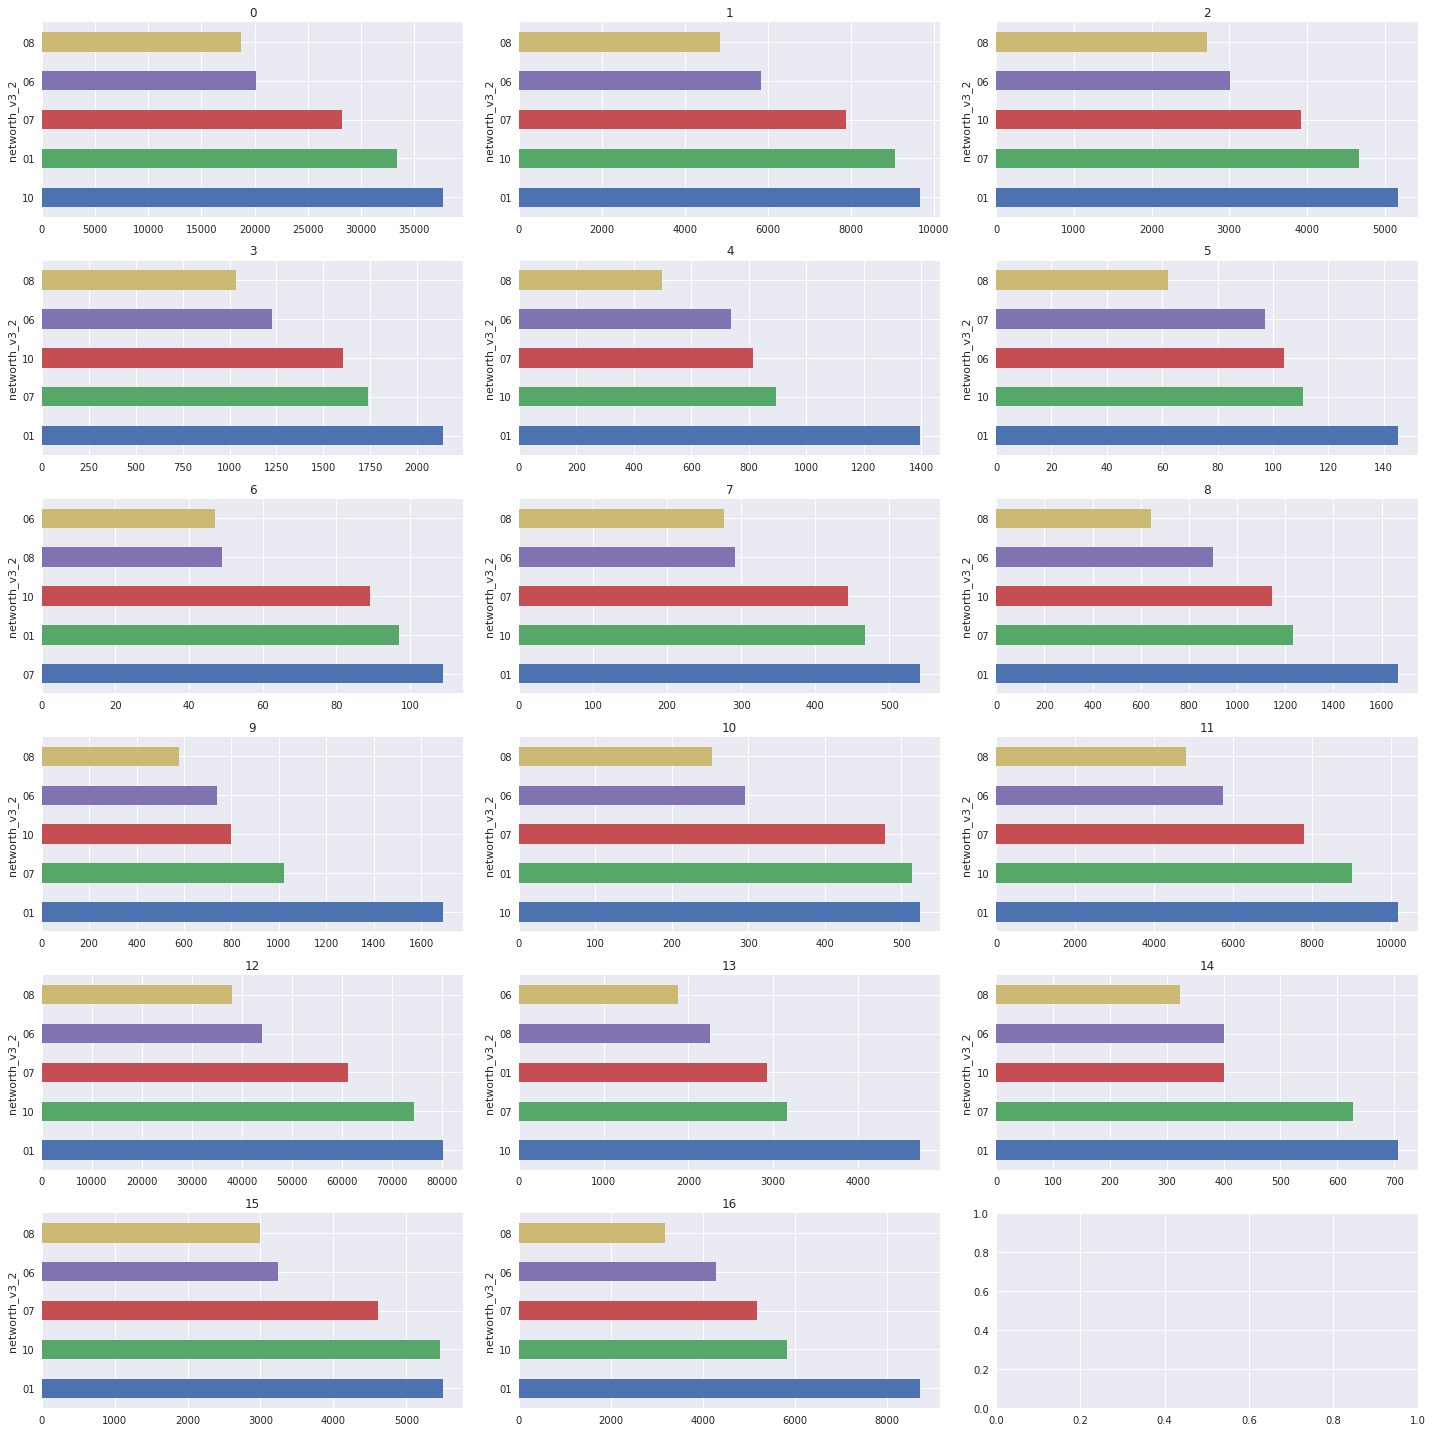

In [57]:
variable = "networth_v3_2"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()



<div class="alert alert-block alert-success"> <center><h2><font color ="ForestGreen">  <b> num_adults_living_unit_bin: </b> </font> <font color = "Crimson"> No Difference </font></h2> </center></div>

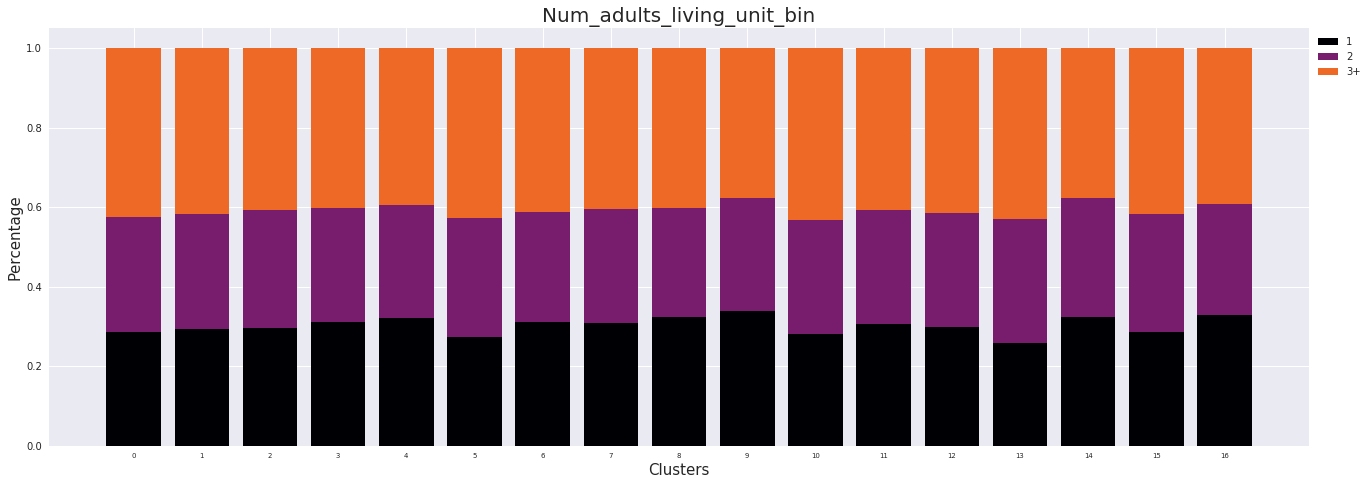

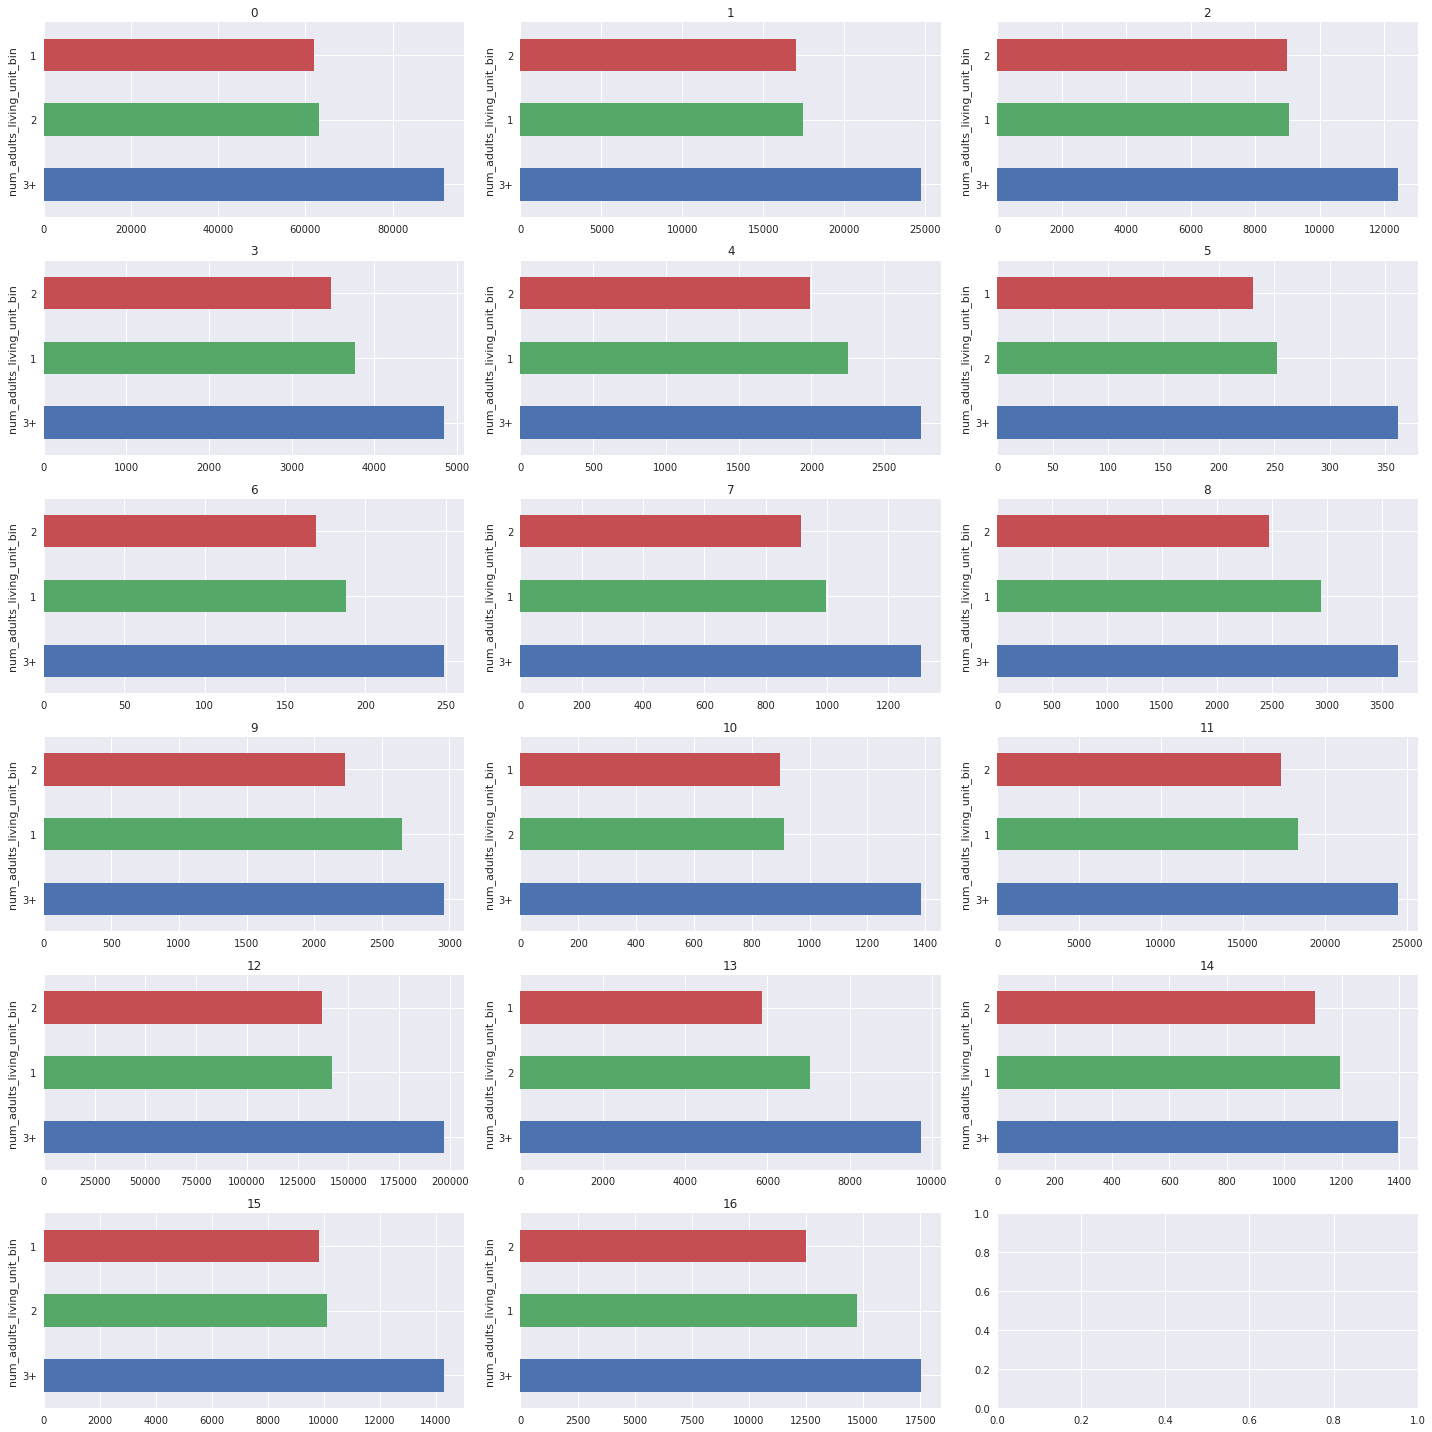

In [58]:
variable = "num_adults_living_unit_bin"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()



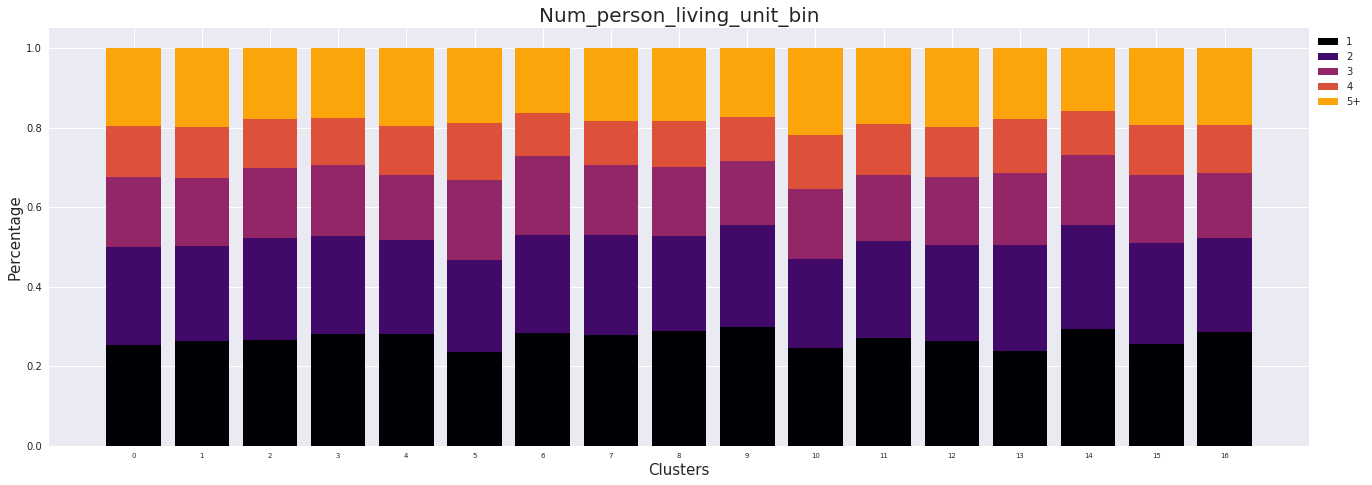

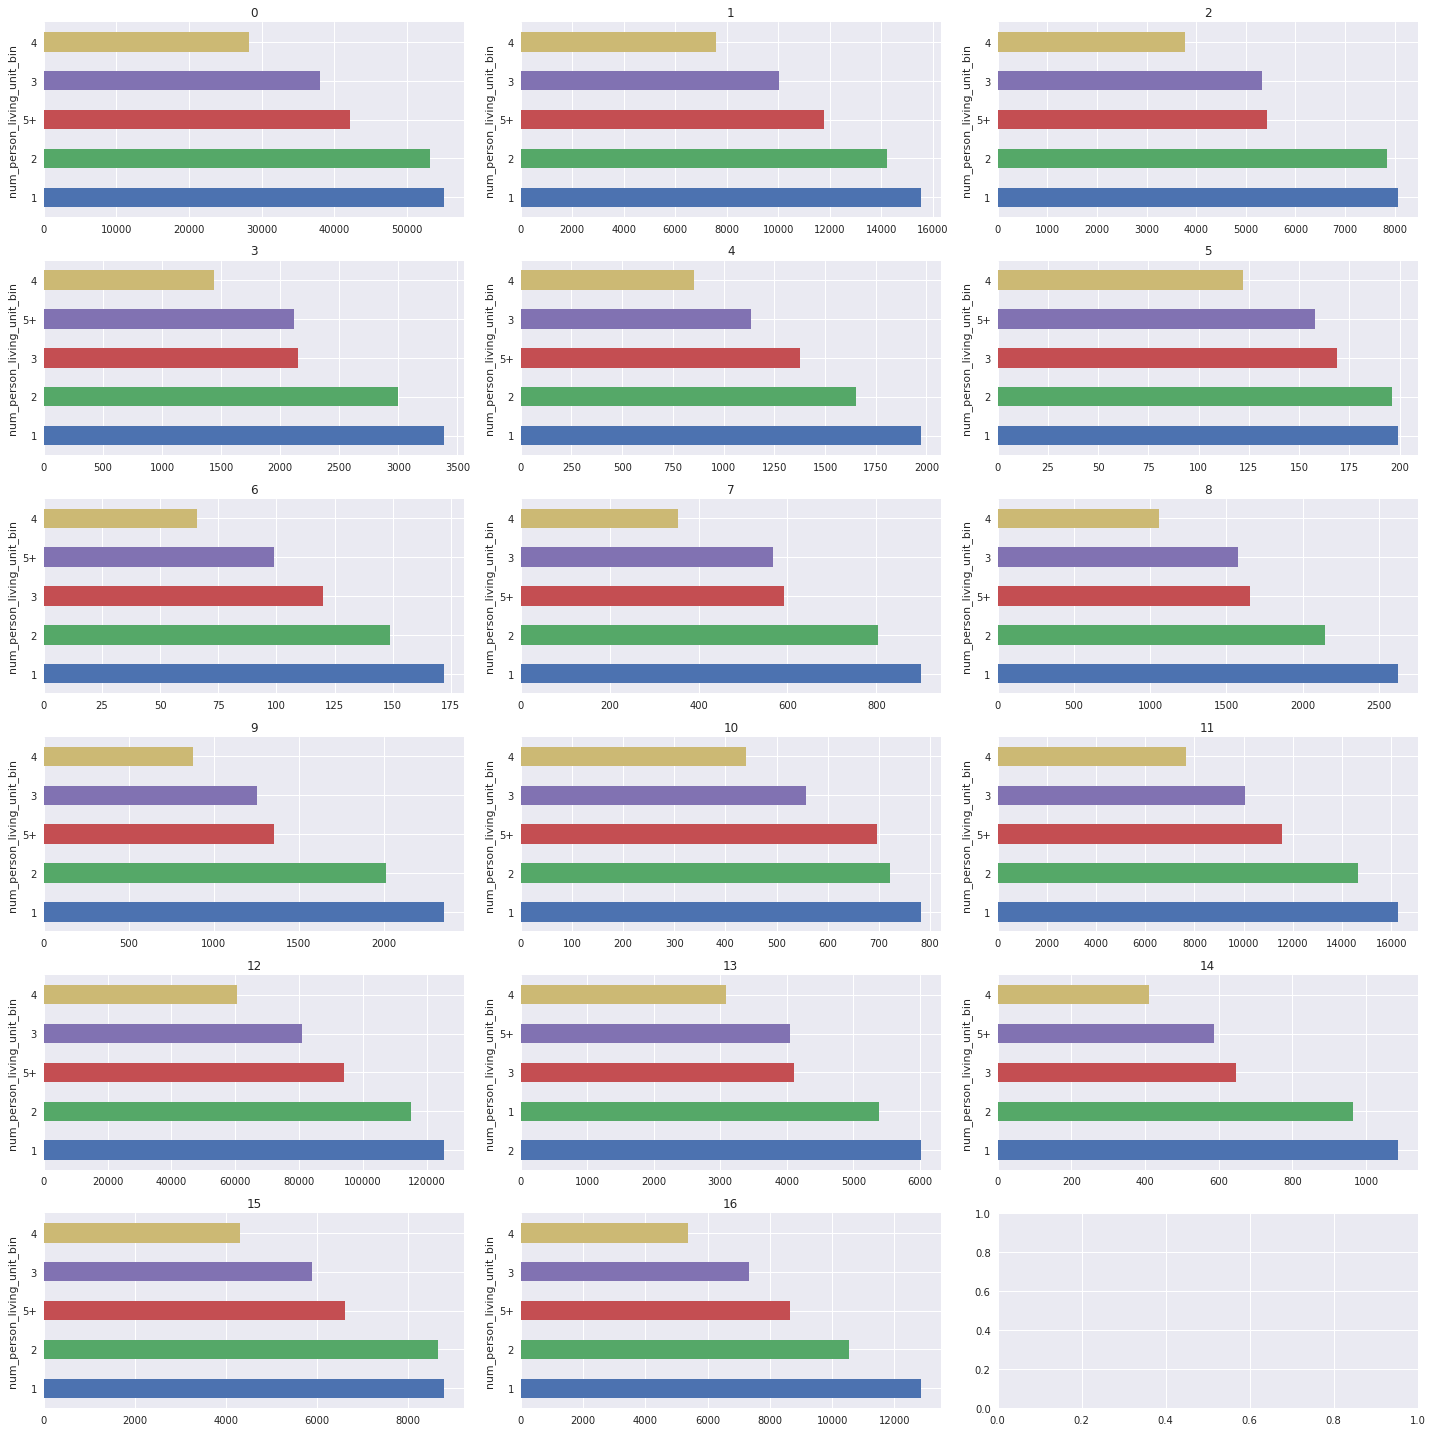

In [59]:
variable = "num_person_living_unit_bin"
df = merged_data.groupby(["prediction", variable]).size().unstack()
degList = [i for i in df.columns]

bar_l = range(17)

cm = plt.get_cmap('inferno')

f, ax = plt.subplots(1, figsize=(20,10))
ax.set_prop_cycle(cycler('color',[cm(1.*i/len(degList)) for i in range(len(degList))]))

bottom = np.zeros_like(bar_l).astype('float')
for i, deg in enumerate(degList):
    ax.bar(bar_l, df[deg]/df.sum(axis = 1), bottom = bottom, width=0.8, label=deg)
    bottom += df[deg].values/df.sum(axis = 1).values


ax.set_xticks(bar_l)
ax.set_xticklabels(df.index.values, size='x-small')
ax.legend(loc="upper left", bbox_to_anchor=(1,1), ncol=1)
f.subplots_adjust(right=1, bottom=0.3)
plt.title(variable.capitalize(), size = 20)
plt.xlabel("Clusters", size = 15)
plt.ylabel("Percentage", size = 15)
f.show()

agency_borough = merged_data.groupby([variable, "prediction"]).size().unstack()
#We'll arrange the subplots in three rows and two columns. 
#Since we have only 5 boroughs, one plot will be blank
COL_NUM = 3
ROW_NUM = 6
import matplotlib.pyplot as plt
fig, axes = plt.subplots(ROW_NUM, COL_NUM, figsize=(20,20))

for i, (borough, agency_count) in enumerate(agency_borough.items()):
    ax = axes[int(i/COL_NUM), i%COL_NUM]
    agency_count = agency_count.sort_values(ascending=False)[:5] 
    agency_count.plot(kind='barh', ax=ax)
    ax.set_title(borough)

# FYI - plt.tight_layout()
plt.tight_layout()

